In [10]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))


Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [53]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']

''' For data collected before 2022.04 '''
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',  'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',   'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube'],
    ['Tube6mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,35,6-2,'Bi',6900,'Wearable','20210924'],
    ['MedTubePressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['PressBalloon2',      'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['Tube8mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['Pressure',           'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['FR3Tube8mm',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20211008'],
    ['FR3MedTube',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['SiMedTube',    'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['L0WsSi5-20Trek8kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',8000,'Trek','20220302'],
    ['L0WsSi5-20Trek9kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi5-20Trek10kV',     'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi6-16Trek9kVHVTop', 'L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi6-16Trek10kVHVTop','L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi5-20sTrek9kVHVBot','L0Ws',20,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,4.0,'Bi',9000,'Trek','20220302'],
]

''' For data collected since 2022.04 '''
# condiTable = [
#     ['MLSi20HV7kV.5Hz',       'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV1Hz',        'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    
#     ['MLSi20HV7kV10mL1Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV10mL2Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV10mL4Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV10mL10Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV10mL20Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    
#     ['MLSi20HV7kV6mL.5Hz',  'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV7mL.5Hz',  'Mylar',15,'Silicone',7,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV8mL.5Hz',  'Mylar',15,'Silicone',8,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
#     ['MLSi20HV7kV10mL.5Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402']
# ]

condiTable = pd.DataFrame(condiTable, columns = colNames)
condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['L0Ws',3,float('nan'),float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
# materialProperty.to_csv("MaterialProperty.csv", index=False)

In [54]:
'''
General Functions
'''

def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeFileName(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    return condi, names, trialNum

def decodeFileName2(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    print(names)
    freq = None
    freqInfo = re.findall('[\.]*\d+Hz', names)
    if freqInfo:
        freq = float(re.split('Hz', freqInfo[0])[0])
        print("Signal frequency (Hz) = %.3f" % freq)
    
    return condi, names, trialNum, freq

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure, cutOff=5, order=8):   
    print(rawData.shape)
    print(np.max(rawData))
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure, np.array([zipStart, zipEnd])

''' 
(For different signal frequency of repeated measurement) 
Identify pressure increasing duration and compute time-averaged pressure 
'''
def cutRepeatTrial(rawData, Fs, inactivePressure, cutOff=5, order=8): 
    print(rawData.shape)
    maxRawValue = np.max(rawData)
    print("max value of raw data = %.3f" % maxRawValue)
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
    
    samp = np.arange(len(rawData))
    
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    segPointInd = np.squeeze(np.argwhere(filtData > 0.25 * maxFiltPress)) # Find value larger than 25% of peak as valid segment data point
    
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > 1))# Index of point where large gap occurs (end and start of a seg)
    print(segPointInd[segGapInd]) # End index of a segment
    print(segPointInd[segGapInd+1]) # Start index of a segment
    
    cutInd = (0.5 * (segPointInd[segGapInd] + segPointInd[segGapInd+1])).astype(int) # Cut in the middle of a end and a start point
    
    avgSegLen = np.mean(np.diff(cutInd))
    print("Avg. segment length = %d" % avgSegLen)
    
    cutInd = np.insert(cutInd, 0, max(cutInd[0]-avgSegLen, 0))
    
    ''' Plot data segmentation index '''
#     ax0, _ = aPlot("Cut Segments")
#     ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
#     ax0.plot(samp[segPointInd], filtData[segPointInd], color='tab:blue')
#     ax0.plot(cutInd, np.zeros(cutInd.shape), '*g')
#     plt.show()
    return cutInd


In [13]:
''' 
Design and zipping state (Rerun needed only when adding a new design layout) 
'''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10],
    ['T5T4T3T2T', 45,18, -10,-4, -19,-8]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
# stateLayout.to_csv("StateLayout.csv", index=False)

''' 
Generate model by matched parameters after getting model data of Valid Arc Length 
(Rerun needed only when adding a new design layout) 
'''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
# stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

# md.to_csv("ValidArcLength.csv", index=False)
md.head(1)   

Data contains 1914 rows


dashHalfDist  dashSpace         R    triArc      triVol     rectVol  \
0           4.5      12.66  8.425705  9.999566  171.949277  138.938526   

   dashLength  6T5T4T3T2T1T  5T4T3T2T1TRT    T5T4T3T2T1  T5T4T3T2T1TR  \
0        12.0  12004.905481   9107.883005  10516.487969  11171.274325   

    5T4T3T2T1T     T5T4T3T2T  
0  9140.893756  10238.610918

In [ ]:
'''Measurement 2022 Duel Trial'''
# pressData = []
# Fs = 1000
# beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
# endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)

# for root, directories, files in walk(".\data\DualTrial"):
#     for fileName in files:
#          if (fileName[-3:] == 'csv'):    
#                 condi, names, trialNum = decodeFileName(fileName)
                
#                 data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
#                 data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
#                 dataMin = np.min(data) 
#                 if dataMin < 0:
#                     data = data-dataMin # Rectify data

#                 inactivePressure = np.min(data[:int(0.5*Fs)])

#                 for i in range(len(beginInd)): 
#                     avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
#                     P0 = data[beginInd[i]+segInd[0]]-inactivePressure

#                     print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
#                     print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
#                           (avgPressure, maxPressure, deltaT))
#                     pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
#                                     (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa


MLSi20HV7kV.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.12446000650335837
0.12007824257635624


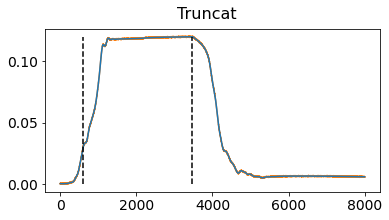


MLSi20HV7kV.5Hz - Trial22 - Seg1
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.121 (bar) in 1.431 (sec)

(8000,)
0.14944696783709716
0.14506085435525626


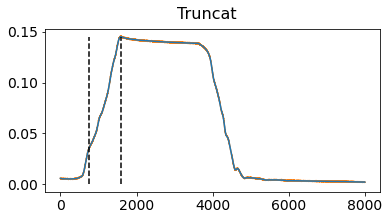


MLSi20HV7kV.5Hz - Trial22 - Seg2
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.146 (bar) in 0.414 (sec)

(8000,)
0.12207036771085061
0.11766996372932584


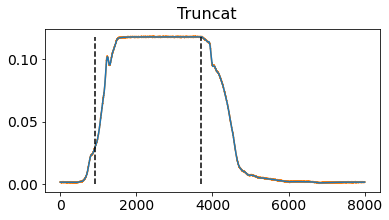


MLSi20HV7kV.5Hz - Trial22 - Seg3
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.118 (bar) in 1.396 (sec)

(8000,)
0.11963261538560781
0.11529216544731681


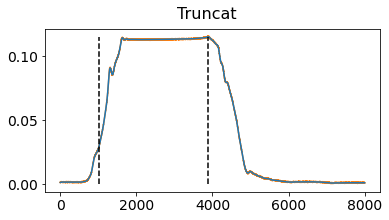


MLSi20HV7kV.5Hz - Trial22 - Seg4
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.116 (bar) in 1.436 (sec)

(8000,)
0.12361000075837239
0.11916164922461961


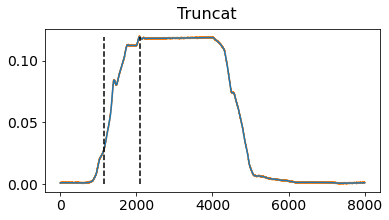


MLSi20HV7kV.5Hz - Trial22 - Seg5
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.120 (bar) in 0.462 (sec)

(8000,)
0.12130055118708973
0.11684166679964106


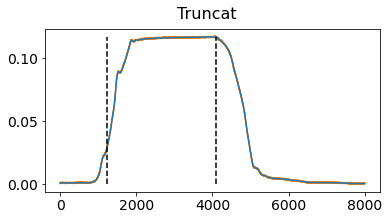


MLSi20HV7kV.5Hz - Trial22 - Seg6
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.117 (bar) in 1.426 (sec)

(8000,)
0.12017790208993843
0.11590217966140651


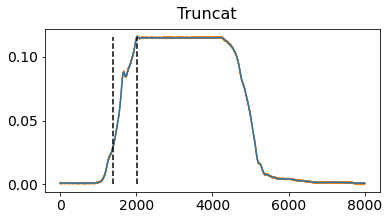


MLSi20HV7kV.5Hz - Trial22 - Seg7
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.116 (bar) in 0.323 (sec)

(8000,)
0.12250338950546612
0.11801035304984919


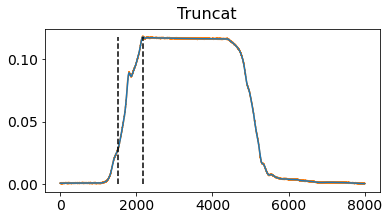


MLSi20HV7kV.5Hz - Trial22 - Seg8
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.119 (bar) in 0.323 (sec)

(8000,)
0.12128451334284471
0.11689383537652083


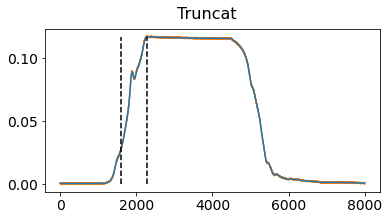


MLSi20HV7kV.5Hz - Trial22 - Seg9
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.117 (bar) in 0.340 (sec)

(8000,)
0.12224678399754582
0.11793008531738544


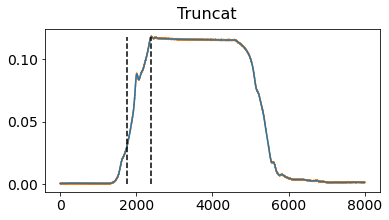


MLSi20HV7kV.5Hz - Trial22 - Seg10
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.118 (bar) in 0.326 (sec)

(8000,)
0.12325716818498199
0.11885221470356787


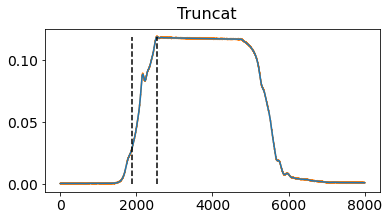


MLSi20HV7kV.5Hz - Trial22 - Seg11
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.119 (bar) in 0.326 (sec)

(8000,)
0.12150904316227497
0.11710101552303076


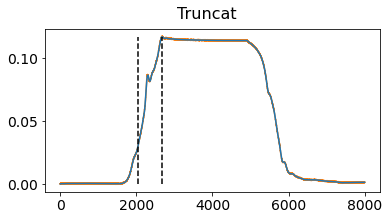


MLSi20HV7kV.5Hz - Trial22 - Seg12
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.118 (bar) in 0.321 (sec)

(8000,)
0.12447604434760338
0.12003614122389594


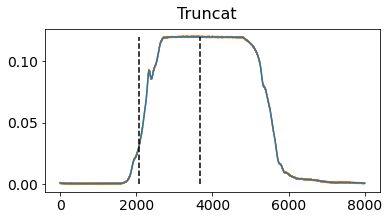


MLSi20HV7kV.5Hz - Trial22 - Seg13
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.121 (bar) in 0.799 (sec)

(8000,)
0.12256754088244619
0.11823510246690895


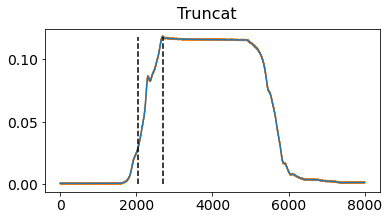


MLSi20HV7kV.5Hz - Trial22 - Seg14
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.119 (bar) in 0.323 (sec)

(8000,)
0.12460434710156354
0.12036413820518593


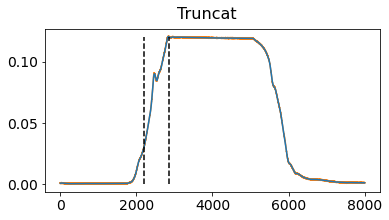


MLSi20HV7kV.5Hz - Trial22 - Seg15
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.121 (bar) in 0.323 (sec)

(8000,)
0.12336943309469711
0.11901235656116695


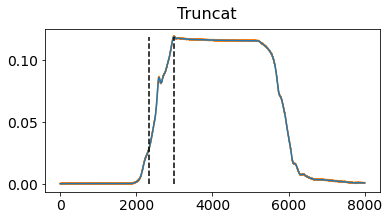


MLSi20HV7kV.5Hz - Trial22 - Seg16
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.119 (bar) in 0.324 (sec)

(8000,)
0.12250338950546612
0.11781600205324931


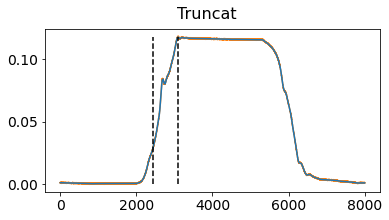


MLSi20HV7kV.5Hz - Trial22 - Seg17
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.119 (bar) in 0.327 (sec)

(5040,)
0.12470057416703365
0.12050010511925449


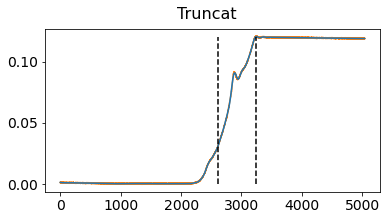


MLSi20HV7kV.5Hz - Trial22 - Seg18
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.121 (bar) in 0.321 (sec)

MLSi20HV7kV.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.11987318304928309
0.11570474122897847


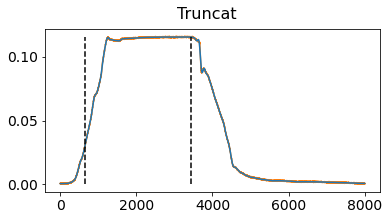


MLSi20HV7kV.5Hz - Trial23 - Seg1
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.116 (bar) in 1.399 (sec)

(8000,)
0.1357827245403414
0.13169366008575467


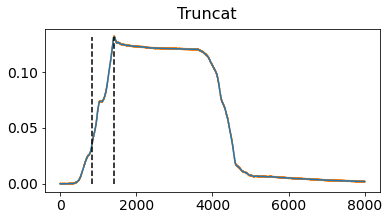


MLSi20HV7kV.5Hz - Trial23 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.132 (bar) in 0.297 (sec)

(8000,)
0.12282414639036648
0.1187370339316246


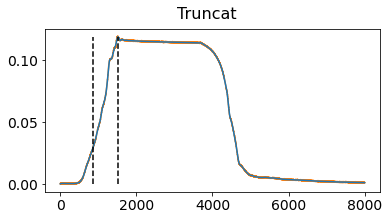


MLSi20HV7kV.5Hz - Trial23 - Seg3
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.119 (bar) in 0.327 (sec)

(8000,)
0.12117224843312958
0.11728159228361666


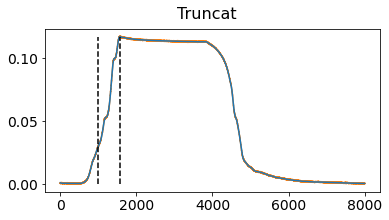


MLSi20HV7kV.5Hz - Trial23 - Seg4
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.118 (bar) in 0.291 (sec)

(8000,)
0.11735524150281519
0.11340563334654676


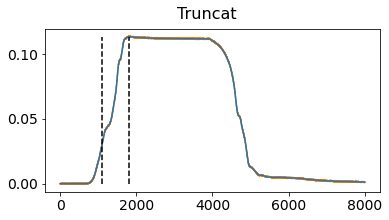


MLSi20HV7kV.5Hz - Trial23 - Seg5
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.114 (bar) in 0.359 (sec)

(8000,)
0.12059488604030892
0.11656393106563283


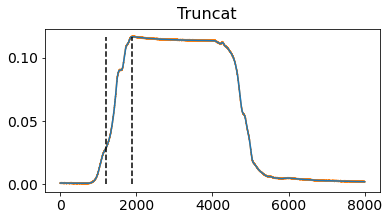


MLSi20HV7kV.5Hz - Trial23 - Seg6
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.117 (bar) in 0.342 (sec)

(8000,)
0.17034427888835624
0.16633542618983552


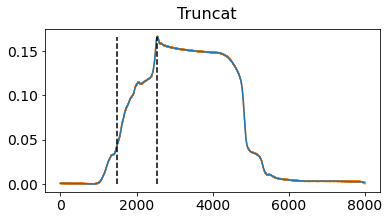


MLSi20HV7kV.5Hz - Trial23 - Seg7
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.167 (bar) in 0.537 (sec)

(8000,)
0.09830228253973324
0.09429916599336109


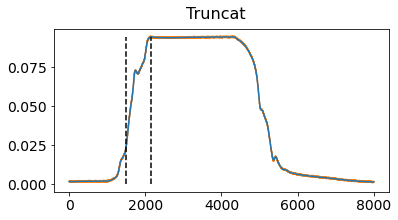


MLSi20HV7kV.5Hz - Trial23 - Seg8
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.095 (bar) in 0.334 (sec)

(8000,)
0.0987032286458587
0.09474417733772675


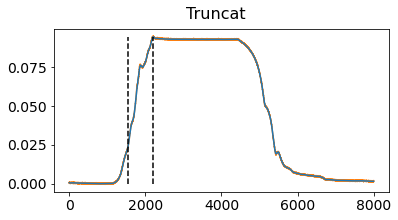


MLSi20HV7kV.5Hz - Trial23 - Seg9
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.095 (bar) in 0.332 (sec)

(8000,)
0.09118147969494504
0.08700948923251511


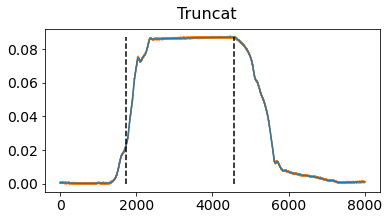


MLSi20HV7kV.5Hz - Trial23 - Seg10
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.088 (bar) in 1.427 (sec)

(8000,)
0.09876738002283877
0.09473035257665918


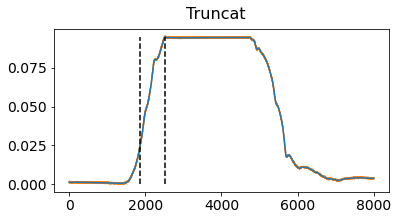


MLSi20HV7kV.5Hz - Trial23 - Seg11
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.095 (bar) in 0.337 (sec)

(8000,)
0.125005293207689
0.12113461123444072


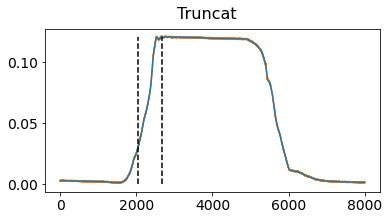


MLSi20HV7kV.5Hz - Trial23 - Seg12
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.121 (bar) in 0.309 (sec)

(8000,)
0.09551169764110003
0.09143750423102776


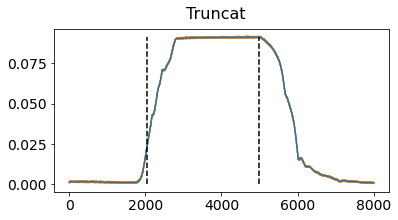


MLSi20HV7kV.5Hz - Trial23 - Seg13
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.092 (bar) in 1.479 (sec)

(8000,)
0.09997021834121517
0.09599558688104483


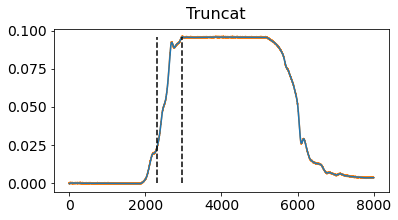


MLSi20HV7kV.5Hz - Trial23 - Seg14
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.096 (bar) in 0.331 (sec)

(8000,)
0.12008167502446833
0.1159551312010322


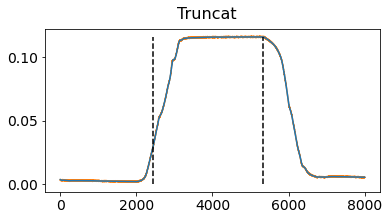


MLSi20HV7kV.5Hz - Trial23 - Seg15
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.117 (bar) in 1.440 (sec)

(8000,)
0.13852519590623957
0.13443258135961023


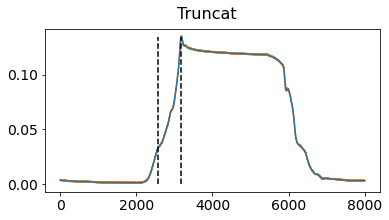


MLSi20HV7kV.5Hz - Trial23 - Seg16
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.135 (bar) in 0.304 (sec)

(8000,)
0.12694587236133623
0.12322871061323766


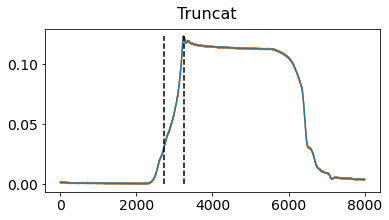


MLSi20HV7kV.5Hz - Trial23 - Seg17
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.123 (bar) in 0.259 (sec)

(8000,)
0.14859696209211118
0.1442855453861741


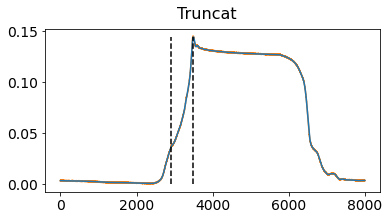


MLSi20HV7kV.5Hz - Trial23 - Seg18
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.145 (bar) in 0.295 (sec)

MLSi20HV7kV.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.16819520775952376
0.16566414544088498


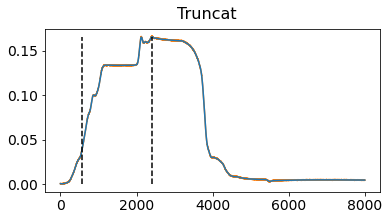


MLSi20HV7kV.5Hz - Trial24 - Seg1
Avg. Pressure of zipping = 0.126 (bar), Max. P. = 0.166 (bar) in 0.915 (sec)

(8000,)
0.09560792470657013
0.09323788956716293


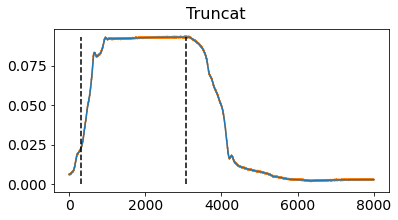


MLSi20HV7kV.5Hz - Trial24 - Seg2
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.094 (bar) in 1.373 (sec)

(8000,)
0.09278526411944689
0.09035641487977641


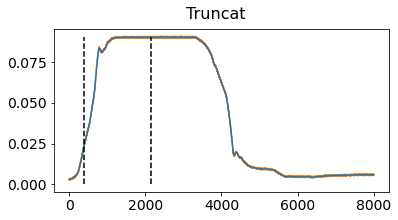


MLSi20HV7kV.5Hz - Trial24 - Seg3
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.091 (bar) in 0.879 (sec)

(8000,)
0.11785241467441077
0.11602771674216641


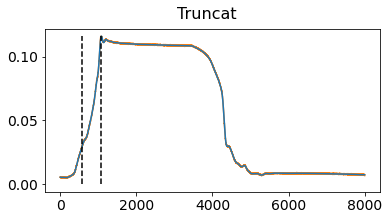


MLSi20HV7kV.5Hz - Trial24 - Seg4
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.116 (bar) in 0.258 (sec)

(8000,)
0.13743462249757832
0.1353107033039325


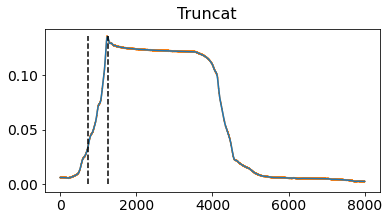


MLSi20HV7kV.5Hz - Trial24 - Seg5
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.136 (bar) in 0.258 (sec)

(8000,)
0.0847342663084476
0.08239205323825867


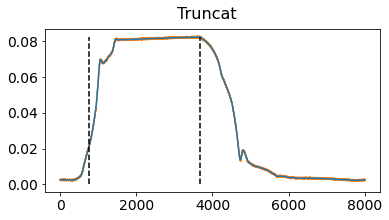


MLSi20HV7kV.5Hz - Trial24 - Seg6
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.083 (bar) in 1.458 (sec)

(8000,)
0.1036589225175694
0.10134837318318415


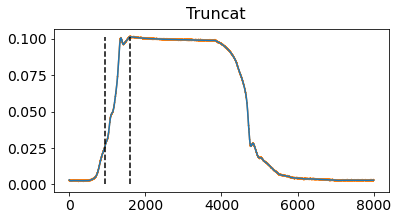


MLSi20HV7kV.5Hz - Trial24 - Seg7
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.102 (bar) in 0.338 (sec)

(8000,)
0.10835801088135982
0.10601244918836444


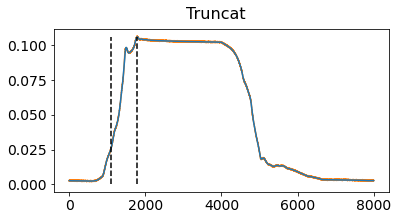


MLSi20HV7kV.5Hz - Trial24 - Seg8
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.107 (bar) in 0.340 (sec)

(8000,)
0.12290433561159159
0.12104743811625472


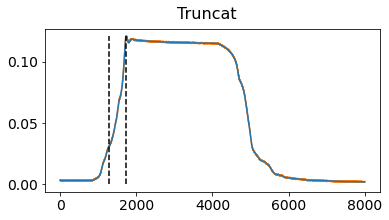


MLSi20HV7kV.5Hz - Trial24 - Seg9
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.121 (bar) in 0.235 (sec)

(8000,)
0.10430043628737015
0.10210698690024837


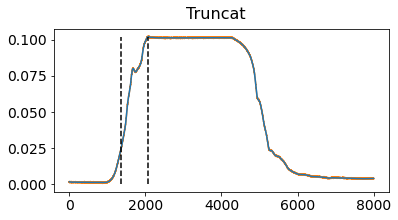


MLSi20HV7kV.5Hz - Trial24 - Seg10
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.102 (bar) in 0.354 (sec)

(8000,)
0.10181457042939228
0.0993967133256838


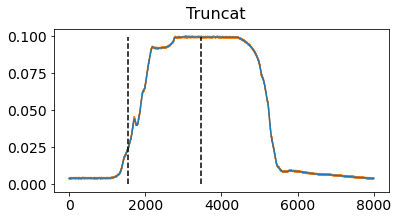


MLSi20HV7kV.5Hz - Trial24 - Seg11
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.100 (bar) in 0.954 (sec)

(8000,)
0.10285703030531848
0.10078001809070847


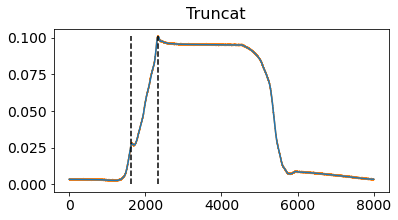


MLSi20HV7kV.5Hz - Trial24 - Seg12
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.101 (bar) in 0.361 (sec)

(8000,)
0.10335420347691406
0.10051740792026047


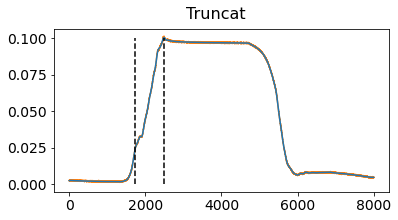


MLSi20HV7kV.5Hz - Trial24 - Seg13
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.102 (bar) in 0.376 (sec)

(8000,)
0.10142966216751184
0.09910470647106431


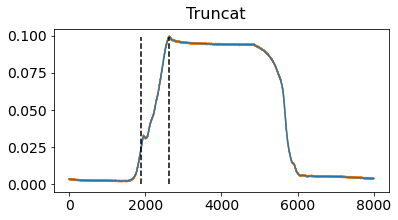


MLSi20HV7kV.5Hz - Trial24 - Seg14
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.100 (bar) in 0.368 (sec)

(8000,)
0.11557504079161814
0.1135314338085057


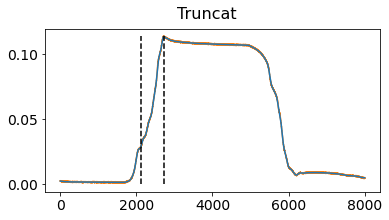


MLSi20HV7kV.5Hz - Trial24 - Seg15
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.114 (bar) in 0.305 (sec)

(8000,)
0.11976091813956796
0.11742831575666739


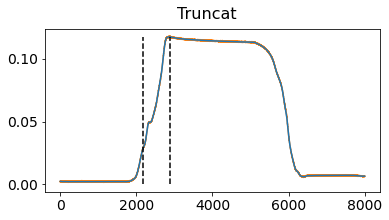


MLSi20HV7kV.5Hz - Trial24 - Seg16
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.118 (bar) in 0.345 (sec)

(8000,)
0.12073922663851408
0.11849222784751293


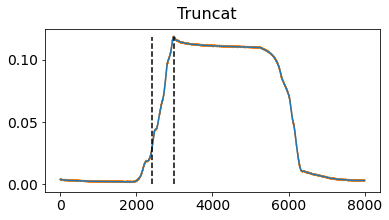


MLSi20HV7kV.5Hz - Trial24 - Seg17
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.119 (bar) in 0.285 (sec)

(8000,)
0.11847789059996648
0.1161122351115239


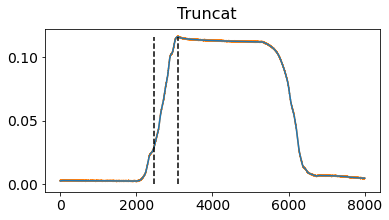


MLSi20HV7kV.5Hz - Trial24 - Seg18
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.117 (bar) in 0.317 (sec)

MLSi20HV7kV.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.11980903167230302
0.11688695192778611


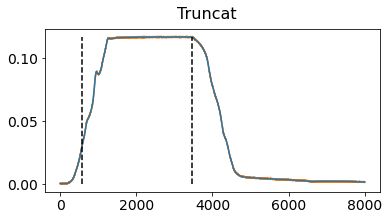


MLSi20HV7kV.5Hz - Trial25 - Seg1
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.118 (bar) in 1.445 (sec)

(8000,)
0.12373830351233255
0.1209751350181714


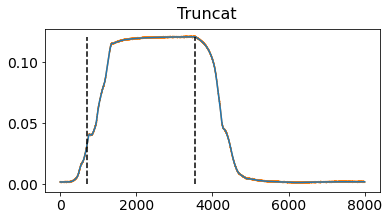


MLSi20HV7kV.5Hz - Trial25 - Seg2
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.121 (bar) in 1.420 (sec)

(8000,)
0.13164496072512666
0.1288338862528672


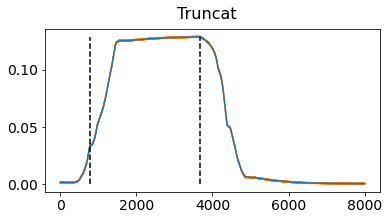


MLSi20HV7kV.5Hz - Trial25 - Seg3
Avg. Pressure of zipping = 0.114 (bar), Max. P. = 0.129 (bar) in 1.446 (sec)

(8000,)
0.12462038494580856
0.12174326917186155


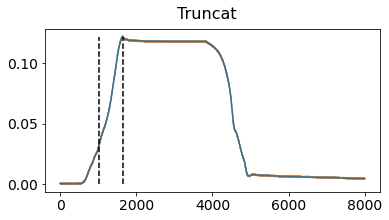


MLSi20HV7kV.5Hz - Trial25 - Seg4
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.122 (bar) in 0.316 (sec)

(8000,)
0.18084906686884333
0.17599275910950818


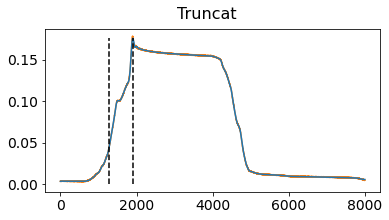


MLSi20HV7kV.5Hz - Trial25 - Seg5
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.179 (bar) in 0.312 (sec)

(8000,)
0.11095614164905282
0.1082859104774504


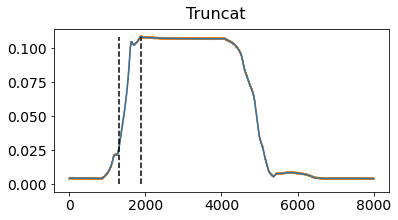


MLSi20HV7kV.5Hz - Trial25 - Seg6
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.109 (bar) in 0.292 (sec)

(8000,)
0.12332131956196206
0.12049275158657163


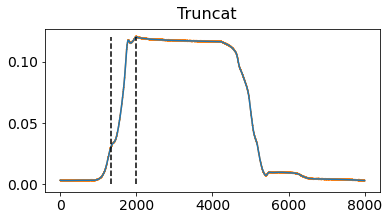


MLSi20HV7kV.5Hz - Trial25 - Seg7
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.121 (bar) in 0.336 (sec)

(8000,)
0.10685045352232808
0.10411029116886106


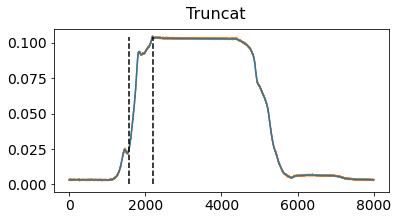


MLSi20HV7kV.5Hz - Trial25 - Seg8
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.105 (bar) in 0.310 (sec)

(8000,)
0.1046051553280255
0.10185037758359229


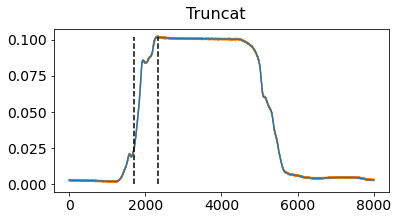


MLSi20HV7kV.5Hz - Trial25 - Seg9
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.102 (bar) in 0.314 (sec)

(8000,)
0.11138916344366831
0.10866130361697042


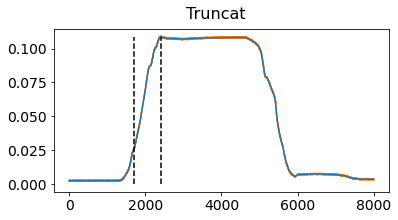


MLSi20HV7kV.5Hz - Trial25 - Seg10
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.109 (bar) in 0.345 (sec)

(8000,)
0.10609667484281221
0.10342687673476479


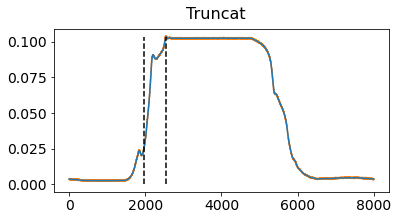


MLSi20HV7kV.5Hz - Trial25 - Seg11
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.104 (bar) in 0.291 (sec)

(8000,)
0.10446081472982033
0.10178509560278587


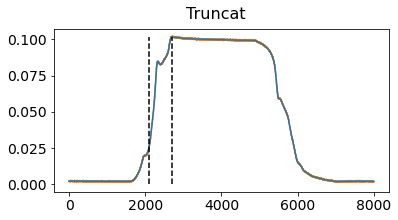


MLSi20HV7kV.5Hz - Trial25 - Seg12
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.102 (bar) in 0.302 (sec)

(8000,)
0.09977776421027494
0.09696840126812789


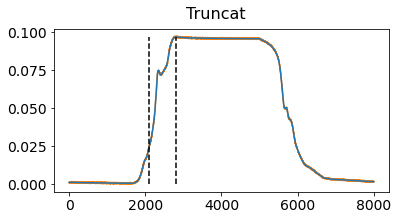


MLSi20HV7kV.5Hz - Trial25 - Seg13
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.098 (bar) in 0.357 (sec)

(8000,)
0.14136389433760785
0.13731189873271496


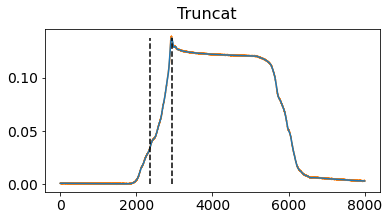


MLSi20HV7kV.5Hz - Trial25 - Seg14
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.139 (bar) in 0.284 (sec)

(8000,)
0.09899190984226904
0.09621989619051582


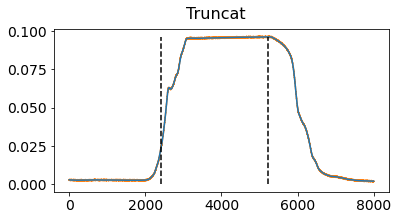


MLSi20HV7kV.5Hz - Trial25 - Seg15
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.097 (bar) in 1.409 (sec)

(8000,)
0.09883153139981884
0.09606943978732392


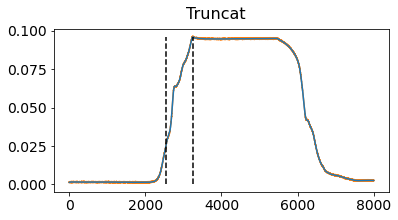


MLSi20HV7kV.5Hz - Trial25 - Seg16
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.097 (bar) in 0.360 (sec)

(8000,)
0.0960088708126956
0.09328420204760594


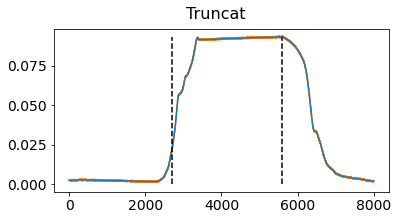


MLSi20HV7kV.5Hz - Trial25 - Seg17
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.094 (bar) in 1.444 (sec)

(8000,)
0.09889568277679892
0.0962861214351043


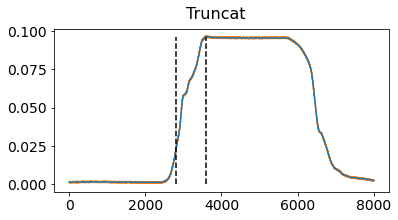


MLSi20HV7kV.5Hz - Trial25 - Seg18
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.097 (bar) in 0.395 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.132815723355013
0.13094905527136474


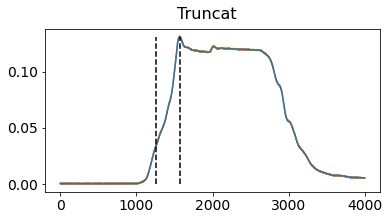


MLSi20HV7kV1Hz - Trial26 - Seg1
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.131 (bar) in 0.159 (sec)

(4000,)
0.11517409468549268
0.11321682191745548


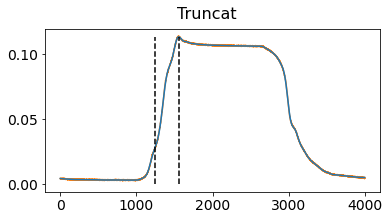


MLSi20HV7kV1Hz - Trial26 - Seg2
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.114 (bar) in 0.154 (sec)

(4000,)
0.11344200750703068
0.11112313334876991


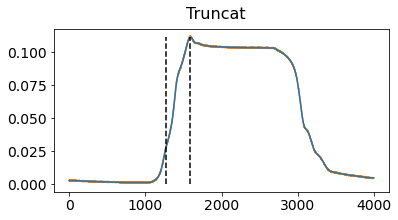


MLSi20HV7kV1Hz - Trial26 - Seg3
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.112 (bar) in 0.161 (sec)

(4000,)
0.1051183663438661
0.10332630437324761


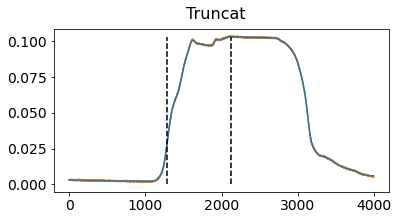


MLSi20HV7kV1Hz - Trial26 - Seg4
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.104 (bar) in 0.423 (sec)

(4000,)
0.10227966791249782
0.10028802591633385


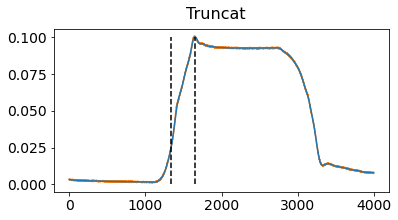


MLSi20HV7kV1Hz - Trial26 - Seg5
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.101 (bar) in 0.156 (sec)

(4000,)
0.1001787103164004
0.09834435352500252


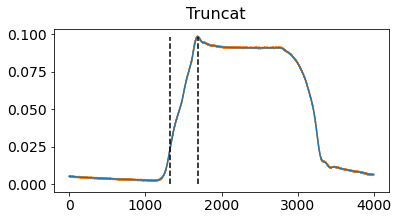


MLSi20HV7kV1Hz - Trial26 - Seg6
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.099 (bar) in 0.180 (sec)

(4000,)
0.098959834153779
0.09717305630456072


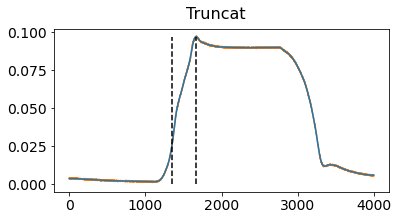


MLSi20HV7kV1Hz - Trial26 - Seg7
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.098 (bar) in 0.160 (sec)

(4000,)
0.09616924925514578
0.09448379357485029


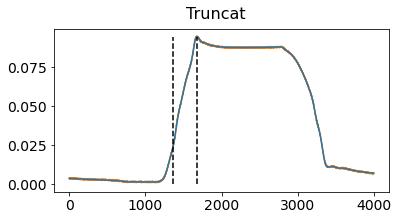


MLSi20HV7kV1Hz - Trial26 - Seg8
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.095 (bar) in 0.159 (sec)

(4000,)
0.092881491184917
0.09074153132152289


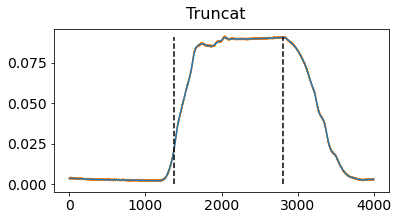


MLSi20HV7kV1Hz - Trial26 - Seg9
Avg. Pressure of zipping = 0.082 (bar), Max. P. = 0.091 (bar) in 0.715 (sec)

(4000,)
0.1060004477773421
0.10424763801838895


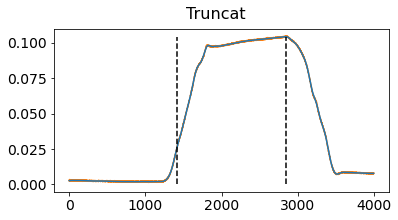


MLSi20HV7kV1Hz - Trial26 - Seg10
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.105 (bar) in 0.713 (sec)

(4000,)
0.13413082658310452
0.13178667943372613


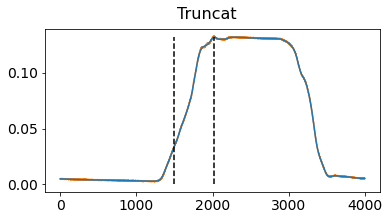


MLSi20HV7kV1Hz - Trial26 - Seg11
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.133 (bar) in 0.267 (sec)

(4000,)
0.12383453057780265
0.12201711187295479


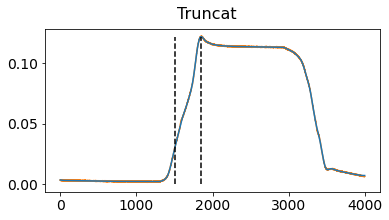


MLSi20HV7kV1Hz - Trial26 - Seg12
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.122 (bar) in 0.172 (sec)

(4000,)
0.11907129083703216
0.11680592514602244


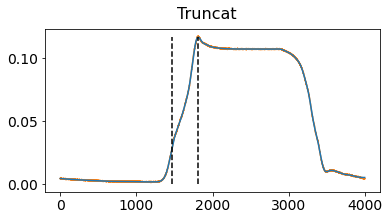


MLSi20HV7kV1Hz - Trial26 - Seg13
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.118 (bar) in 0.171 (sec)

(4000,)
0.11642504653660411
0.11425914316747761


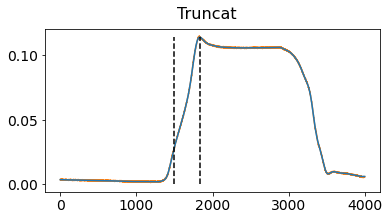


MLSi20HV7kV1Hz - Trial26 - Seg14
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.115 (bar) in 0.167 (sec)

(4000,)
0.11522220821822773
0.11300309220801179


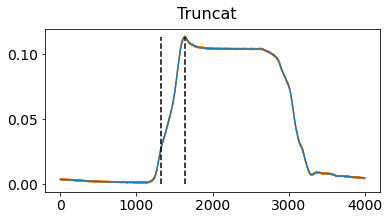


MLSi20HV7kV1Hz - Trial26 - Seg15
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.114 (bar) in 0.154 (sec)

(4000,)
0.11409955912107643
0.11174478495531705


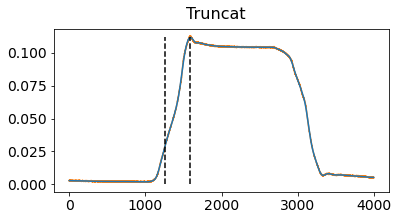


MLSi20HV7kV1Hz - Trial26 - Seg16
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.113 (bar) in 0.169 (sec)

(4000,)
0.1169382575524447
0.11443995350607396


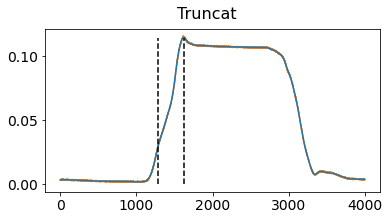


MLSi20HV7kV1Hz - Trial26 - Seg17
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.116 (bar) in 0.171 (sec)

(4000,)
0.12070715095002404
0.11843705542875604


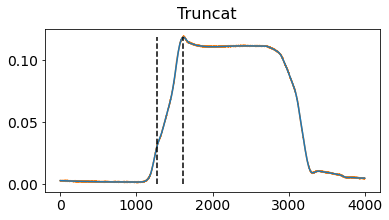


MLSi20HV7kV1Hz - Trial26 - Seg18
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.119 (bar) in 0.175 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.12340150878318715
0.11704415563219545


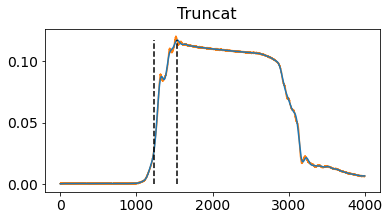


MLSi20HV7kV1Hz - Trial01 - Seg1
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.120 (bar) in 0.150 (sec)

(4000,)
0.11504579193153253
0.11075886342942895


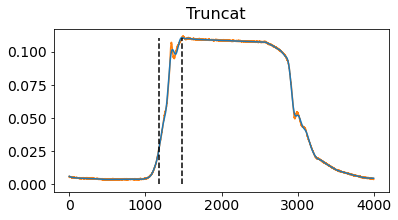


MLSi20HV7kV1Hz - Trial01 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.112 (bar) in 0.150 (sec)

(4000,)
0.12532605009258938
0.11854960864517668


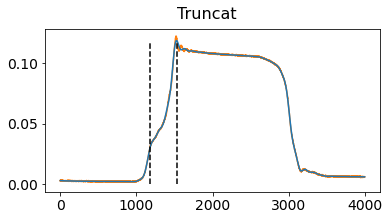


MLSi20HV7kV1Hz - Trial01 - Seg3
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.122 (bar) in 0.175 (sec)

(4000,)
0.1066098858586528
0.10062912456725852


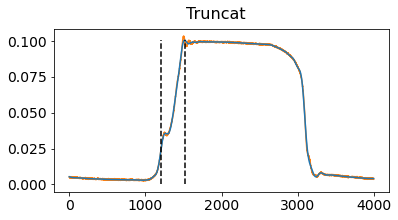


MLSi20HV7kV1Hz - Trial01 - Seg4
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.103 (bar) in 0.153 (sec)

(4000,)
0.10014663462791036
0.09513012946021138


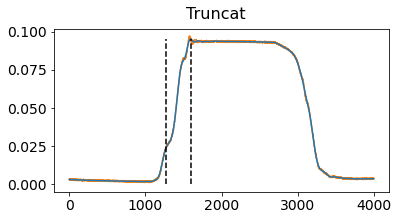


MLSi20HV7kV1Hz - Trial01 - Seg5
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.097 (bar) in 0.162 (sec)

(4000,)
0.1260477530836152
0.11771053788963727


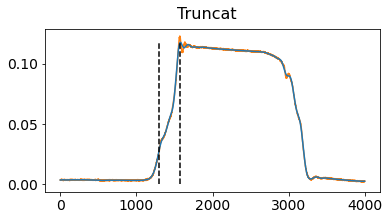


MLSi20HV7kV1Hz - Trial01 - Seg6
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.123 (bar) in 0.138 (sec)

(4000,)
0.1094646221342661
0.10528637078762378


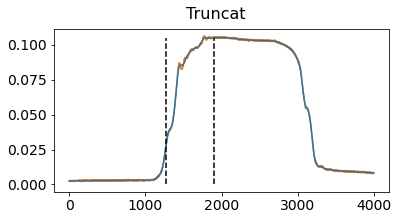


MLSi20HV7kV1Hz - Trial01 - Seg7
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.106 (bar) in 0.316 (sec)

(4000,)
0.11453258091569193
0.10612757593067554


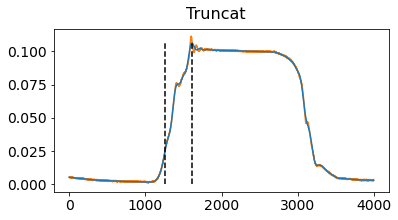


MLSi20HV7kV1Hz - Trial01 - Seg8
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.111 (bar) in 0.175 (sec)

(4000,)
0.10927216800332587
0.10429075358580607


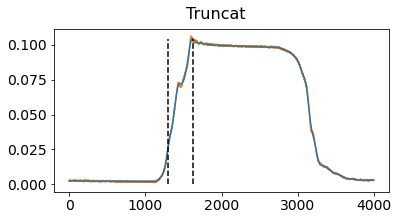


MLSi20HV7kV1Hz - Trial01 - Seg9
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.106 (bar) in 0.162 (sec)

(4000,)
0.10620893975252735
0.1017996335362668


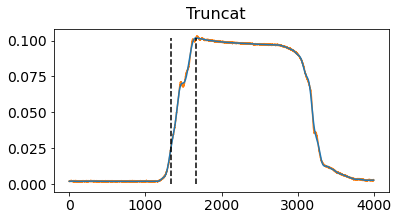


MLSi20HV7kV1Hz - Trial01 - Seg10
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.103 (bar) in 0.165 (sec)

(4000,)
0.10710705903024838
0.10197642797728886


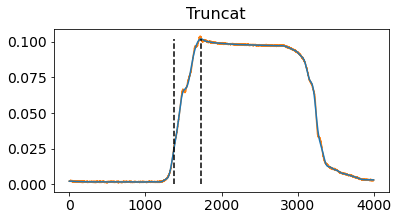


MLSi20HV7kV1Hz - Trial01 - Seg11
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.104 (bar) in 0.177 (sec)

(4000,)
0.10556742598272661
0.10074191889877356


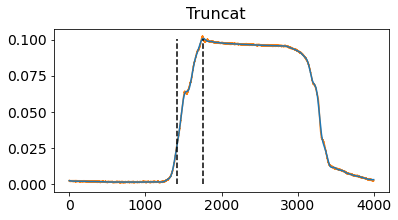


MLSi20HV7kV1Hz - Trial01 - Seg12
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.102 (bar) in 0.175 (sec)

(4000,)
0.10636931819497754
0.10146534143107645


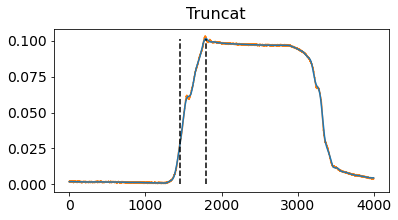


MLSi20HV7kV1Hz - Trial01 - Seg13
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.103 (bar) in 0.173 (sec)

(4000,)
0.10389949018124468
0.09999158545983837


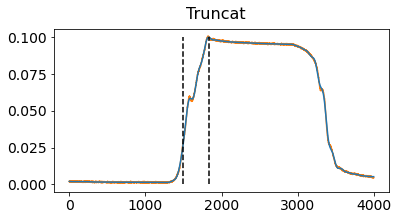


MLSi20HV7kV1Hz - Trial01 - Seg14
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.101 (bar) in 0.170 (sec)

(4000,)
0.10693064274355318
0.1030357859363905


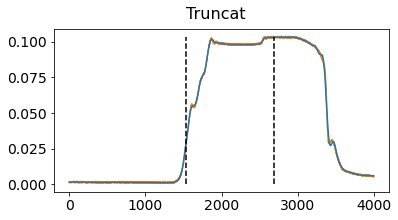


MLSi20HV7kV1Hz - Trial01 - Seg15
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.104 (bar) in 0.582 (sec)

(4000,)
0.11400333205560632
0.10710257984275141


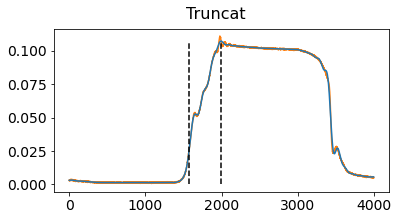


MLSi20HV7kV1Hz - Trial01 - Seg16
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.111 (bar) in 0.208 (sec)

(4000,)
0.1169382575524447
0.10876380888781509


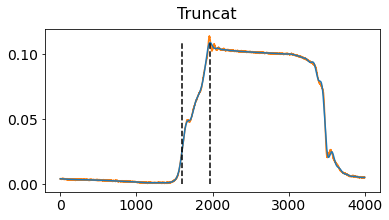


MLSi20HV7kV1Hz - Trial01 - Seg17
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.114 (bar) in 0.183 (sec)

(4000,)
0.11292879649119009
0.10438451296168054


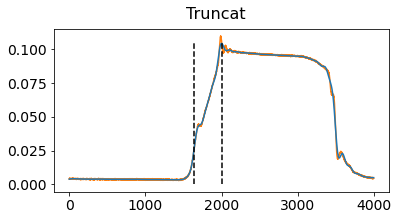


MLSi20HV7kV1Hz - Trial01 - Seg18
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.110 (bar) in 0.180 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.11583164629953843
0.11225746612519126


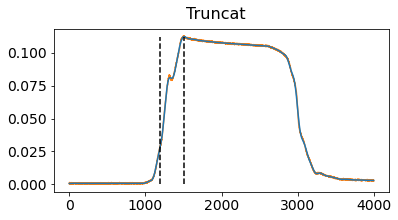


MLSi20HV7kV1Hz - Trial02 - Seg1
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.113 (bar) in 0.158 (sec)

(4000,)
0.11005802237133178
0.10557607460208883


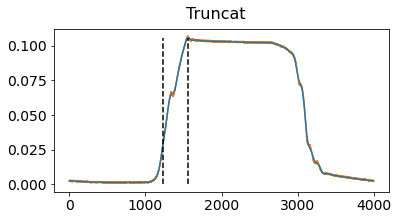


MLSi20HV7kV1Hz - Trial02 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.107 (bar) in 0.169 (sec)

(4000,)
0.11134104991093326
0.10696109089649426


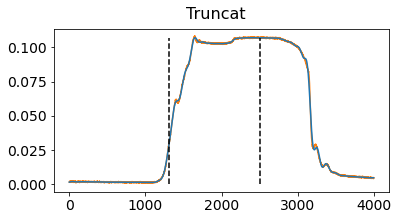


MLSi20HV7kV1Hz - Trial02 - Seg3
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.108 (bar) in 0.602 (sec)

(4000,)
0.11963261538560781
0.11382989579048748


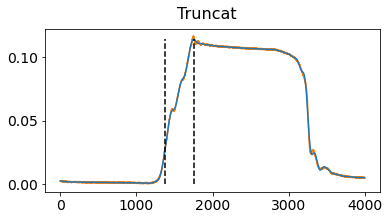


MLSi20HV7kV1Hz - Trial02 - Seg4
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.116 (bar) in 0.186 (sec)

(4000,)
0.12107602136765948
0.11267218614133256


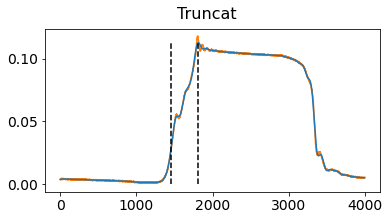


MLSi20HV7kV1Hz - Trial02 - Seg5
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.118 (bar) in 0.179 (sec)

(4000,)
0.11461277013691702
0.1062846027969292


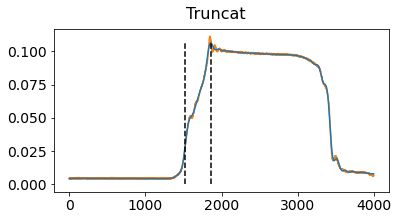


MLSi20HV7kV1Hz - Trial02 - Seg6
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.111 (bar) in 0.170 (sec)

(4000,)
0.11102029302603289
0.10469276602734394


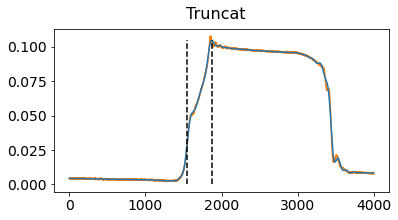


MLSi20HV7kV1Hz - Trial02 - Seg7
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.108 (bar) in 0.165 (sec)

(4000,)
0.1098976439288816
0.10470824542013525


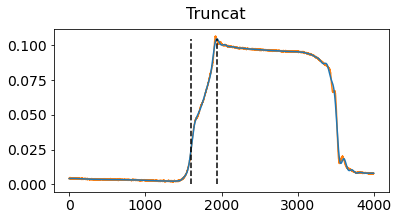


MLSi20HV7kV1Hz - Trial02 - Seg8
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.107 (bar) in 0.169 (sec)

(4000,)
0.1083419730371148
0.10398070038718692


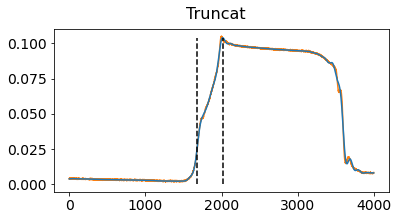


MLSi20HV7kV1Hz - Trial02 - Seg9
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.105 (bar) in 0.168 (sec)

(4000,)
0.10709102118600336
0.10322748480518437


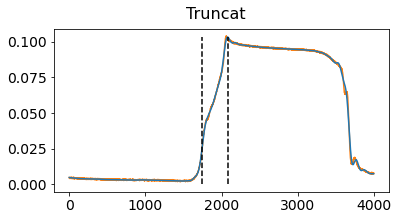


MLSi20HV7kV1Hz - Trial02 - Seg10
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.104 (bar) in 0.167 (sec)

(4000,)
0.10442873904133029
0.10159541121062113


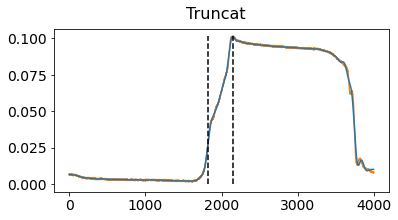


MLSi20HV7kV1Hz - Trial02 - Seg11
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.167 (sec)

(4000,)
0.10107682959412144
0.09852958822614281


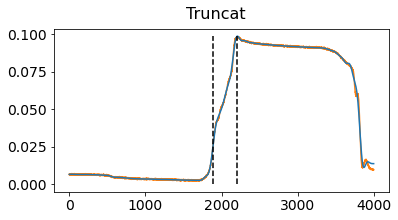


MLSi20HV7kV1Hz - Trial02 - Seg12
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.098 (bar) in 0.162 (sec)

(4000,)
0.10199098671608749
0.0965656292010594


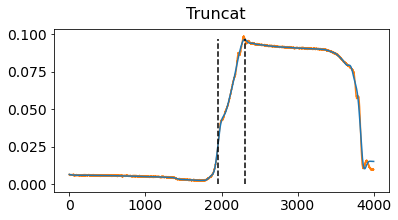


MLSi20HV7kV1Hz - Trial02 - Seg13
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.099 (bar) in 0.178 (sec)

(4000,)
0.10420420922190003
0.09798059765336689


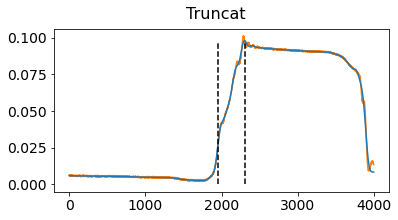


MLSi20HV7kV1Hz - Trial02 - Seg14
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.177 (sec)

(4000,)
0.10418817137765501
0.09752673494450156


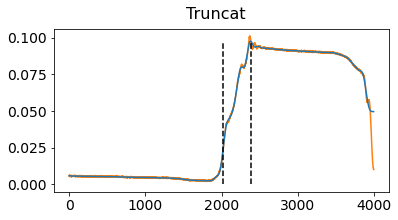


MLSi20HV7kV1Hz - Trial02 - Seg15
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.179 (sec)

(4000,)
0.10442873904133029
0.09808117183164689


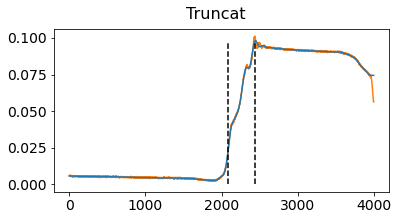


MLSi20HV7kV1Hz - Trial02 - Seg16
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.101 (bar) in 0.178 (sec)

(4000,)
0.10369099820605944
0.09762231968683667


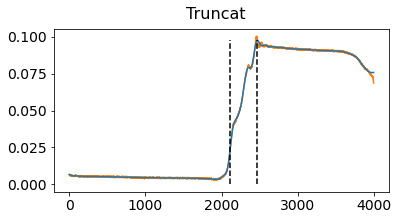


MLSi20HV7kV1Hz - Trial02 - Seg17
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.100 (bar) in 0.178 (sec)

(4000,)
0.10157400276571701
0.0962558176227653


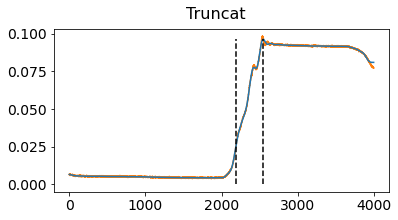


MLSi20HV7kV1Hz - Trial02 - Seg18
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.098 (bar) in 0.180 (sec)

MLSi20HV7kV.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.1125920017620447
0.10951379700771537


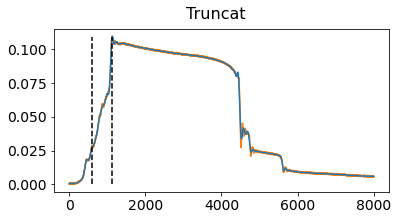


MLSi20HV7kV.5Hz - Trial03 - Seg1
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.110 (bar) in 0.270 (sec)

(8000,)
0.1106033090756624
0.09963440372233211


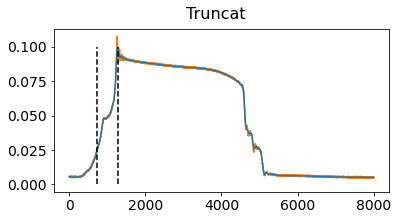


MLSi20HV7kV.5Hz - Trial03 - Seg2
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.108 (bar) in 0.270 (sec)

(8000,)
0.100707959176486
0.090766854198889


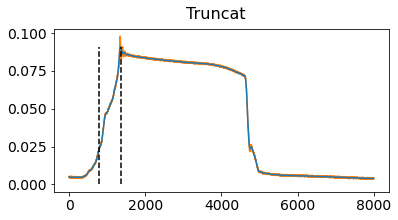


MLSi20HV7kV.5Hz - Trial03 - Seg3
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.098 (bar) in 0.284 (sec)

(8000,)
0.09049185239240924
0.0833002058442519


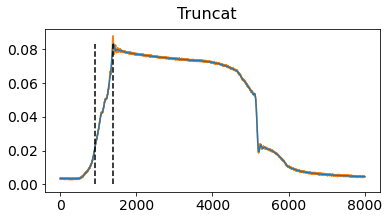


MLSi20HV7kV.5Hz - Trial03 - Seg4
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.088 (bar) in 0.247 (sec)

(8000,)
0.08114178919756347
0.07190846475630651


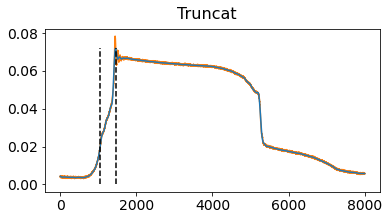


MLSi20HV7kV.5Hz - Trial03 - Seg5
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.078 (bar) in 0.209 (sec)

(8000,)
0.0669322591964771
0.061575910372417136


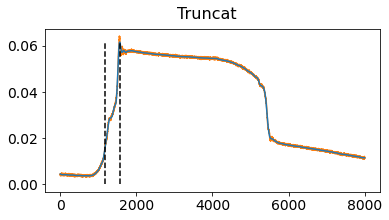


MLSi20HV7kV.5Hz - Trial03 - Seg6
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.064 (bar) in 0.195 (sec)

(8000,)
0.05580199529043428
0.05066211961444913


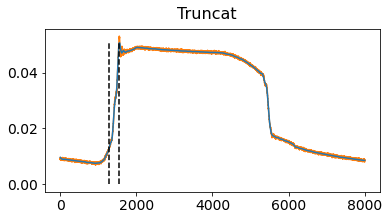


MLSi20HV7kV.5Hz - Trial03 - Seg7
Avg. Pressure of zipping = 0.027 (bar), Max. P. = 0.053 (bar) in 0.141 (sec)

(8000,)
0.04864911675715604
0.042551316022579576


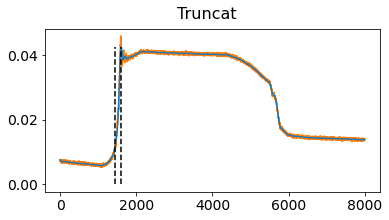


MLSi20HV7kV.5Hz - Trial03 - Seg8
Avg. Pressure of zipping = 0.024 (bar), Max. P. = 0.046 (bar) in 0.085 (sec)

(8000,)
0.04528116946570216
0.04185004796151824


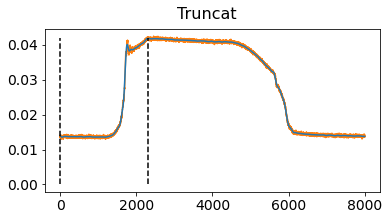


MLSi20HV7kV.5Hz - Trial03 - Seg9
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.157 (sec)

(8000,)
0.0459226832355029
0.042339603514040265


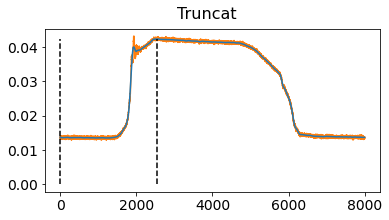


MLSi20HV7kV.5Hz - Trial03 - Seg10
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.272 (sec)

(8000,)
0.04598683461248297
0.04258645025847471


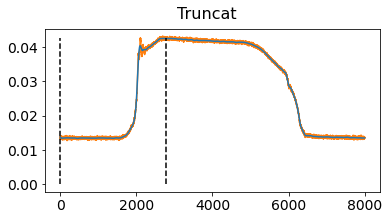


MLSi20HV7kV.5Hz - Trial03 - Seg11
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.043 (bar) in 1.387 (sec)

(8000,)
0.04704533233265419
0.04300676252352458


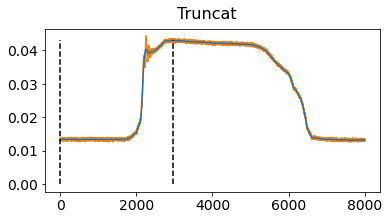


MLSi20HV7kV.5Hz - Trial03 - Seg12
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.044 (bar) in 1.478 (sec)

(8000,)
0.04651608347256858
0.04311052926057473


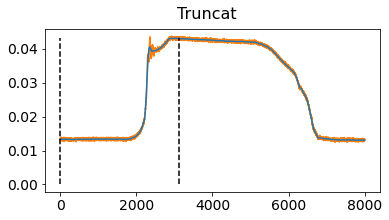


MLSi20HV7kV.5Hz - Trial03 - Seg13
Avg. Pressure of zipping = 0.021 (bar), Max. P. = 0.044 (bar) in 1.558 (sec)

(8000,)
0.04717363508661434
0.043282111027120165


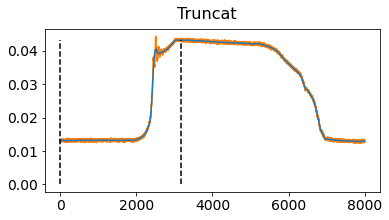


MLSi20HV7kV.5Hz - Trial03 - Seg14
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.044 (bar) in 1.591 (sec)

(8000,)
0.04691702957869404
0.0434457023629664


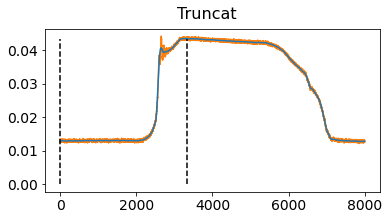


MLSi20HV7kV.5Hz - Trial03 - Seg15
Avg. Pressure of zipping = 0.020 (bar), Max. P. = 0.044 (bar) in 1.667 (sec)

(8000,)
0.04771892179094497
0.043524037773117454


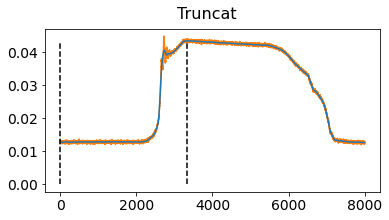


MLSi20HV7kV.5Hz - Trial03 - Seg16
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.045 (bar) in 1.671 (sec)

(8000,)
0.04770288394669995
0.04361789615804651


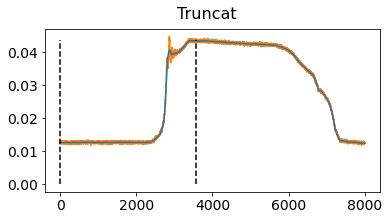


MLSi20HV7kV.5Hz - Trial03 - Seg17
Avg. Pressure of zipping = 0.019 (bar), Max. P. = 0.045 (bar) in 1.778 (sec)

(8000,)
0.04751042981575973
0.043490037181539376


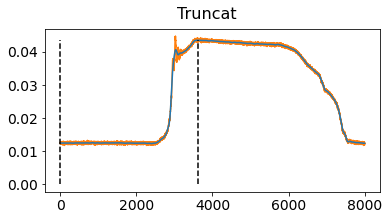


MLSi20HV7kV.5Hz - Trial03 - Seg18
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.045 (bar) in 1.806 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.08197575709830443
0.07181859184938892


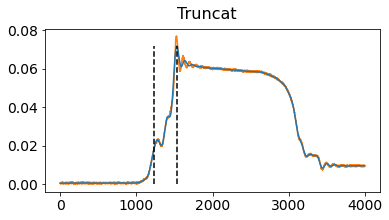


MLSi20HV7kV1Hz - Trial04 - Seg1
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.077 (bar) in 0.150 (sec)

(4000,)
0.06625866973818632
0.06010959434732606


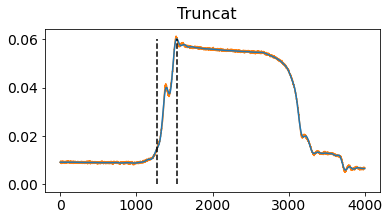


MLSi20HV7kV1Hz - Trial04 - Seg2
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.061 (bar) in 0.128 (sec)

(4000,)
0.06425393920755902
0.05776572140975074


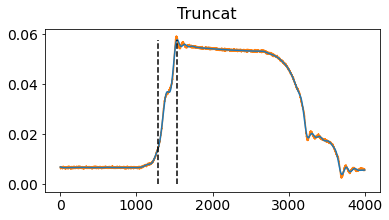


MLSi20HV7kV1Hz - Trial04 - Seg3
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.059 (bar) in 0.125 (sec)

(4000,)
0.06095014329308521
0.054427230823658315


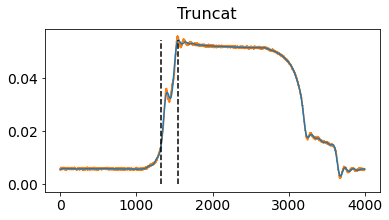


MLSi20HV7kV1Hz - Trial04 - Seg4
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.056 (bar) in 0.116 (sec)

(4000,)
0.05740577971493613
0.05218523501874313


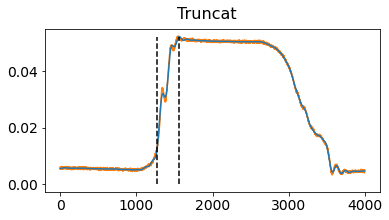


MLSi20HV7kV1Hz - Trial04 - Seg5
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.052 (bar) in 0.144 (sec)

(4000,)
0.05771049875559148
0.05232965674262066


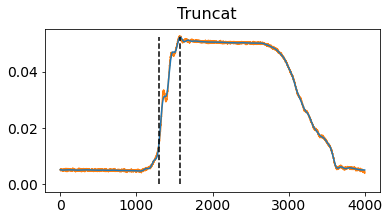


MLSi20HV7kV1Hz - Trial04 - Seg6
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.142 (sec)

(4000,)
0.05493595170120328
0.049853919779709974


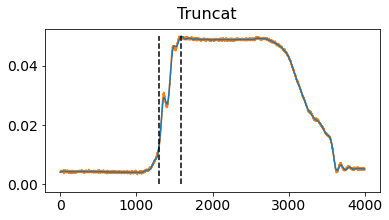


MLSi20HV7kV1Hz - Trial04 - Seg7
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.050 (bar) in 0.147 (sec)

(4000,)
0.056555773969950145
0.05173029355312207


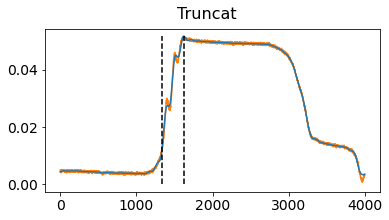


MLSi20HV7kV1Hz - Trial04 - Seg8
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.052 (bar) in 0.141 (sec)

(4000,)
0.057534082468896276
0.05124949820150679


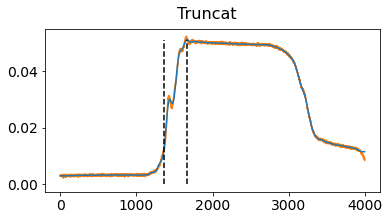


MLSi20HV7kV1Hz - Trial04 - Seg9
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.052 (bar) in 0.150 (sec)

(4000,)
0.05758219600163133
0.05156958779411677


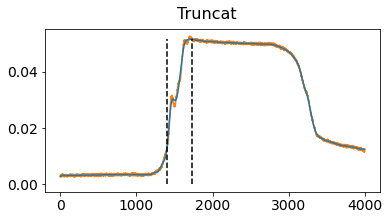


MLSi20HV7kV1Hz - Trial04 - Seg10
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.165 (sec)

(4000,)
0.05820767192718705
0.051785428564115846


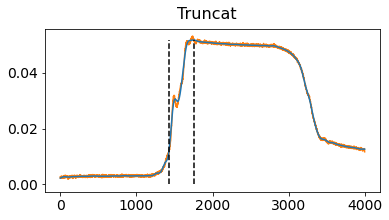


MLSi20HV7kV1Hz - Trial04 - Seg11
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.053 (bar) in 0.160 (sec)

(4000,)
0.05886522354123281
0.05236731315043382


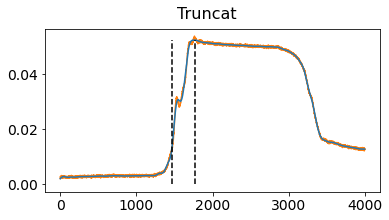


MLSi20HV7kV1Hz - Trial04 - Seg12
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.054 (bar) in 0.151 (sec)

(4000,)
0.05899352629519296
0.05266255774667028


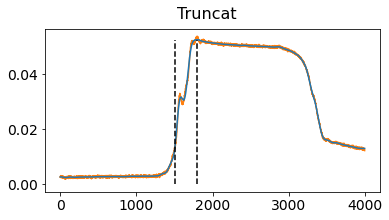


MLSi20HV7kV1Hz - Trial04 - Seg13
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.054 (bar) in 0.147 (sec)

(4000,)
0.0587689964757627
0.05288798757493453


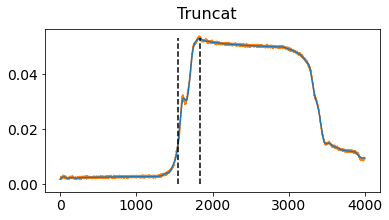


MLSi20HV7kV1Hz - Trial04 - Seg14
Avg. Pressure of zipping = 0.038 (bar), Max. P. = 0.054 (bar) in 0.145 (sec)

(4000,)
0.05775861228832654
0.05266430004444954


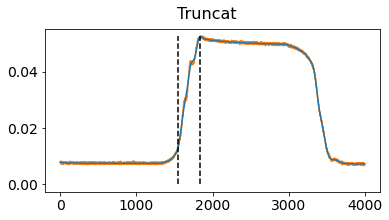


MLSi20HV7kV1Hz - Trial04 - Seg15
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.146 (sec)

(4000,)
0.05852842881208742
0.05292676661472159


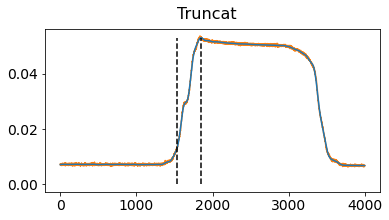


MLSi20HV7kV1Hz - Trial04 - Seg16
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.157 (sec)

(4000,)
0.058303898992657165
0.052795556624578674


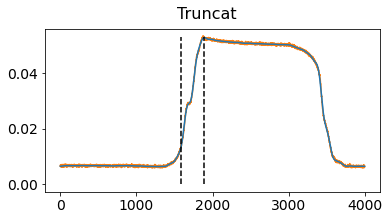


MLSi20HV7kV1Hz - Trial04 - Seg17
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.053 (bar) in 0.153 (sec)

(4000,)
0.05862465587755753
0.05274000191634297


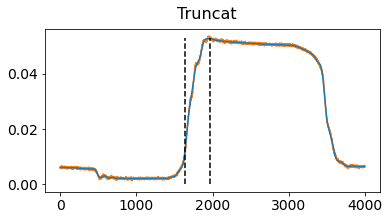


MLSi20HV7kV1Hz - Trial04 - Seg18
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.054 (bar) in 0.165 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.1111967093127281
0.10774621887157387


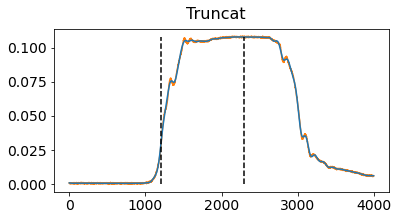


MLSi20HV7kV1Hz - Trial05 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.108 (bar) in 0.545 (sec)

(4000,)
0.11785241467441077
0.1133595396825308


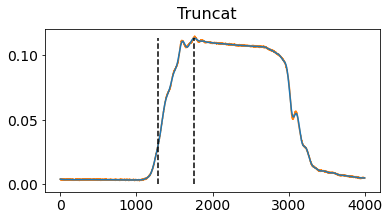


MLSi20HV7kV1Hz - Trial05 - Seg2
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.115 (bar) in 0.242 (sec)

(4000,)
0.11045896847745725
0.10680748099723097


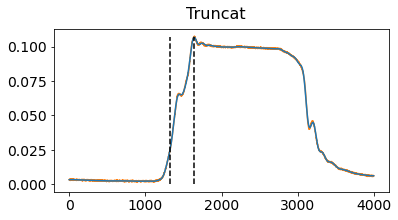


MLSi20HV7kV1Hz - Trial05 - Seg3
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.108 (bar) in 0.156 (sec)

(4000,)
0.08373991996525647
0.08050362221350618


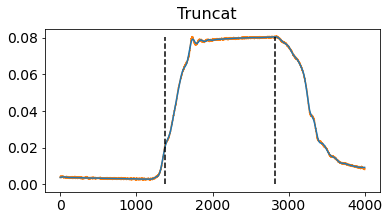


MLSi20HV7kV1Hz - Trial05 - Seg4
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.081 (bar) in 0.726 (sec)

(4000,)
0.08502294750485793
0.08145686661806843


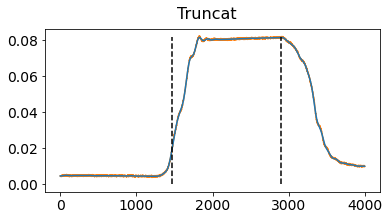


MLSi20HV7kV1Hz - Trial05 - Seg5
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.082 (bar) in 0.716 (sec)

(4000,)
0.08968996018015832
0.08533048990275315


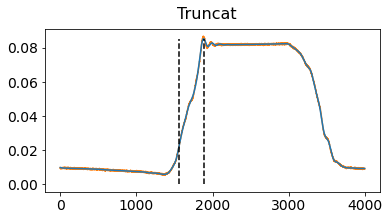


MLSi20HV7kV1Hz - Trial05 - Seg6
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.087 (bar) in 0.164 (sec)

(4000,)
0.09066826867910445
0.08641241323468202


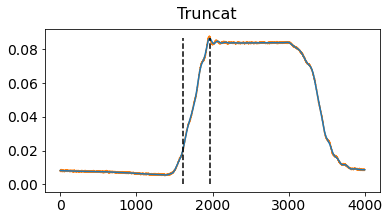


MLSi20HV7kV1Hz - Trial05 - Seg7
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.088 (bar) in 0.172 (sec)

(4000,)
0.09260884783275168
0.08864178830903902


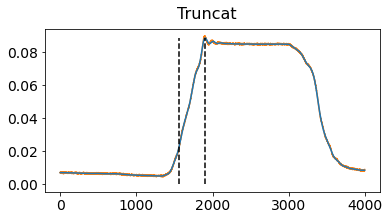


MLSi20HV7kV1Hz - Trial05 - Seg8
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.090 (bar) in 0.173 (sec)

(4000,)
0.09472584327309412
0.09082168338265567


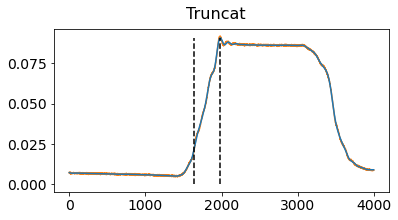


MLSi20HV7kV1Hz - Trial05 - Seg9
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.092 (bar) in 0.171 (sec)

(4000,)
0.09634566554184099
0.09236567388831748


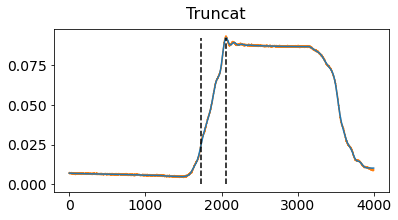


MLSi20HV7kV1Hz - Trial05 - Seg10
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.093 (bar) in 0.169 (sec)

(4000,)
0.09620132494363581
0.09226963407060344


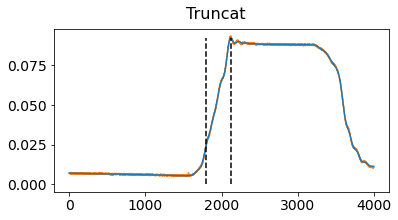


MLSi20HV7kV1Hz - Trial05 - Seg11
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.093 (bar) in 0.165 (sec)

(4000,)
0.10022682384913545
0.09597044084914091


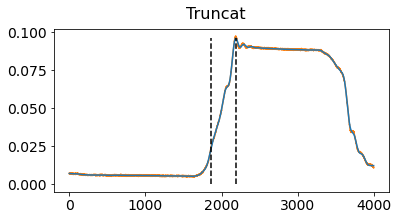


MLSi20HV7kV1Hz - Trial05 - Seg12
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.097 (bar) in 0.162 (sec)

(4000,)
0.10215136515853768
0.09746785542400091


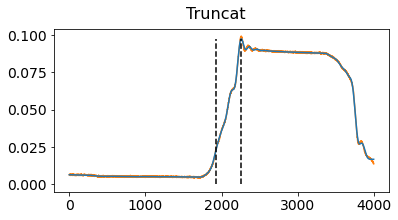


MLSi20HV7kV1Hz - Trial05 - Seg13
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.099 (bar) in 0.163 (sec)

(4000,)
0.0955758490180801
0.09130877314725543


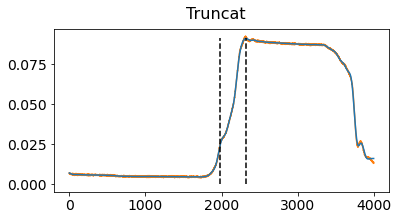


MLSi20HV7kV1Hz - Trial05 - Seg14
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.093 (bar) in 0.173 (sec)

(4000,)
0.09843058529369339
0.0941519180193803


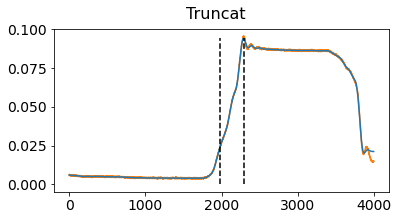


MLSi20HV7kV1Hz - Trial05 - Seg15
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.096 (bar) in 0.157 (sec)

(4000,)
0.09677868733645649
0.09269853145408272


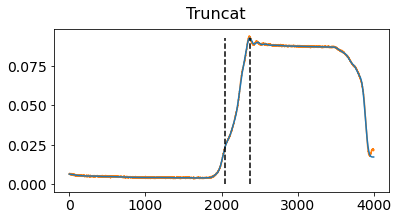


MLSi20HV7kV1Hz - Trial05 - Seg16
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.094 (bar) in 0.164 (sec)

(4000,)
0.09676264949221146
0.09304496761721388


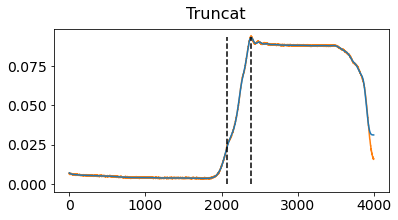


MLSi20HV7kV1Hz - Trial05 - Seg17
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.094 (bar) in 0.160 (sec)

(4000,)
0.09642585476306607
0.09232470791850478


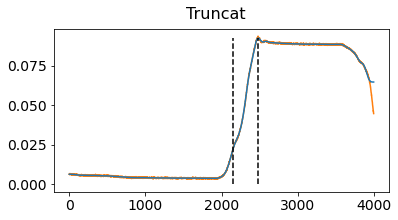


MLSi20HV7kV1Hz - Trial05 - Seg18
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.094 (bar) in 0.163 (sec)

MLSi20HV7kV1Hz
Signal frequency (Hz) = 1.000
(4000,)
0.12524586087136427
0.11440354083667635


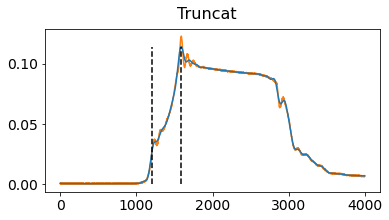


MLSi20HV7kV1Hz - Trial06 - Seg1
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.123 (bar) in 0.191 (sec)

(4000,)
0.13121193893051114
0.12461769276112894


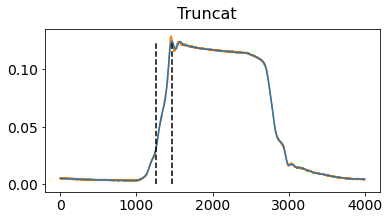


MLSi20HV7kV1Hz - Trial06 - Seg2
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.129 (bar) in 0.104 (sec)

(4000,)
0.09358715633169781
0.09013054196184474


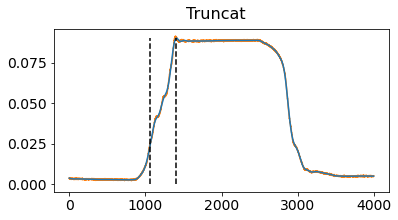


MLSi20HV7kV1Hz - Trial06 - Seg3
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.091 (bar) in 0.176 (sec)

(4000,)
0.09820605547426313
0.09552156727724972


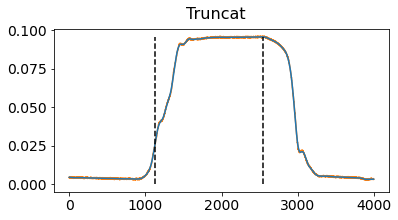


MLSi20HV7kV1Hz - Trial06 - Seg4
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.096 (bar) in 0.711 (sec)

(4000,)
0.11127689853395319
0.10868797474673944


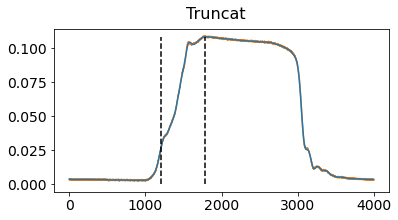


MLSi20HV7kV1Hz - Trial06 - Seg5
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.109 (bar) in 0.289 (sec)

(4000,)
0.1250854824289141
0.1174904281131849


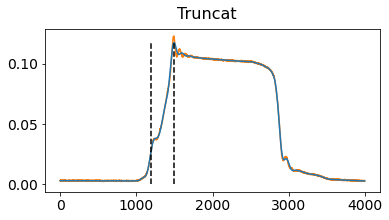


MLSi20HV7kV1Hz - Trial06 - Seg6
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.123 (bar) in 0.148 (sec)

(4000,)
0.12696191020558126
0.11752161787782109


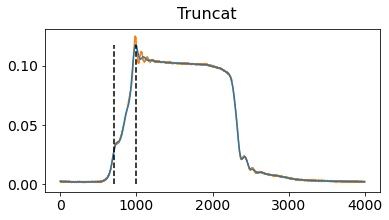


MLSi20HV7kV1Hz - Trial06 - Seg7
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.125 (bar) in 0.140 (sec)

(4000,)
0.1263043585915355
0.1177286220544128


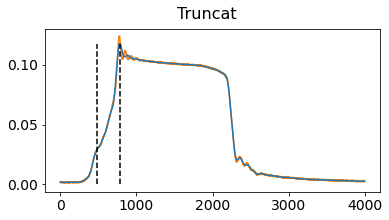


MLSi20HV7kV1Hz - Trial06 - Seg8
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.124 (bar) in 0.147 (sec)

(4000,)
0.12051469681908383
0.1147684053754253


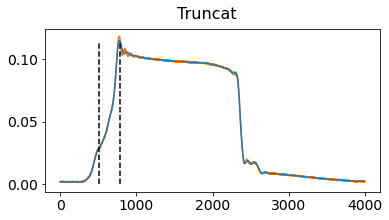


MLSi20HV7kV1Hz - Trial06 - Seg9
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.118 (bar) in 0.136 (sec)

(4000,)
0.12421943883968309
0.11545748323492994


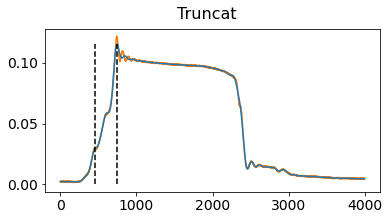


MLSi20HV7kV1Hz - Trial06 - Seg10
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.122 (bar) in 0.147 (sec)

(4000,)
0.11132501206668824
0.10724632024783366


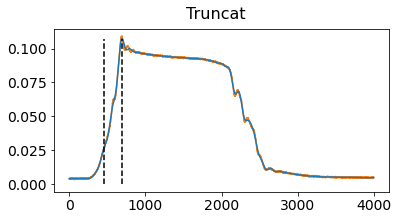


MLSi20HV7kV1Hz - Trial06 - Seg11
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.109 (bar) in 0.119 (sec)

(4000,)
0.09543150841987494
0.09193539119098912


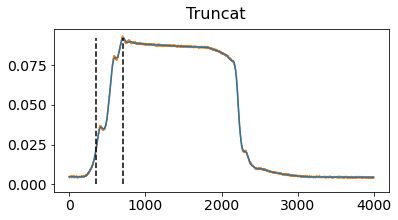


MLSi20HV7kV1Hz - Trial06 - Seg12
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.093 (bar) in 0.176 (sec)

(4000,)
0.09607302218967567
0.0933119684484494


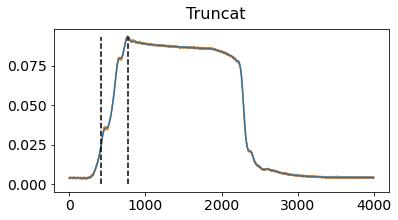


MLSi20HV7kV1Hz - Trial06 - Seg13
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.094 (bar) in 0.178 (sec)

(4000,)
0.0941805565687635
0.0919807169681357


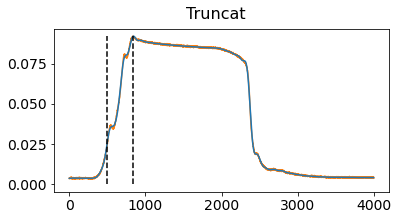


MLSi20HV7kV1Hz - Trial06 - Seg14
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.092 (bar) in 0.176 (sec)

(4000,)
0.09337866435651257
0.09103878156563062


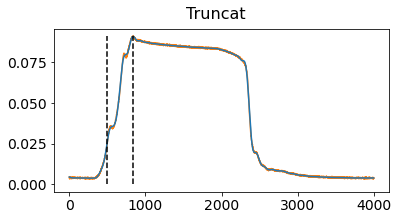


MLSi20HV7kV1Hz - Trial06 - Seg15
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.091 (bar) in 0.174 (sec)

(4000,)
0.09169469071078562
0.08912099770282854


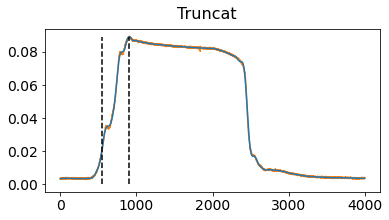


MLSi20HV7kV1Hz - Trial06 - Seg16
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.089 (bar) in 0.177 (sec)

(4000,)
0.09029939826146902
0.08794109227038395


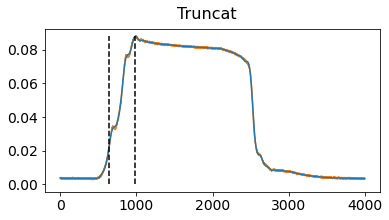


MLSi20HV7kV1Hz - Trial06 - Seg17
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.088 (bar) in 0.173 (sec)

(4000,)
0.092881491184917
0.0903005741368056


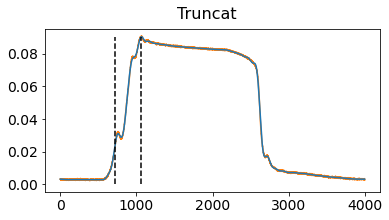


MLSi20HV7kV1Hz - Trial06 - Seg18
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.091 (bar) in 0.175 (sec)



In [18]:
'''Measurement 2022 Twenty Trial (Act4 Act6, with frequency of 0.5Hz, 1Hz)'''
'''
Shifted0.5s: 1-3, 5-7, 9-11, ...
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77]
'''

pressData = []
Fs = 2000

measureDataPath = ".\Data220401Relabelled\ValidData"
# measureDataPath = ".\Data220401Relabelled\Act6Volume"

for root, directories, files in walk(measureDataPath):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
#                 ax, _ = aPlot()
#                 ax.plot(data)
#                 ax.plot(beginInd, np.zeros(beginInd.shape), '*r')
#                 ax.plot(endInd, np.zeros(endInd.shape), '*g')
#                 plt.show()

                for i in range(len(beginInd)): 
#                     ax.plot(beginInd[i]+np.arange(len(data[beginInd[i]:endInd[i]])), data[beginInd[i]:endInd[i]])
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, 
                                                                               inactivePressure, 20, 8)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")

MLSi20HV7kV10mL.5Hz
Signal frequency (Hz) = 0.500
(164000,)
max value of raw data = 0.167
0.14486693691590977
[  8545  17505  26480  35434  44412  53314  62328  71322  80242  89212
  98208 107200 116160 125039 134081 143122 152010]
[ 13895  22848  31815  40782  49718  58650  67696  76694  85576  94587
 103586 112526 121471 130428 139439 148419 157401]
Avg. segment length = 8967
(8968,)
0.13858934728321964
0.12737545810651263


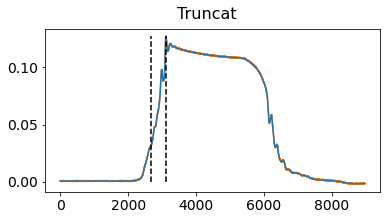


MLSi20HV7kV10mL.5Hz - Trial13 - Seg1
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.127 (bar) in 0.214 (sec)

(8956,)
0.12676945607464105
0.1153212115246584


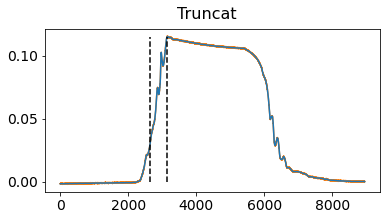


MLSi20HV7kV10mL.5Hz - Trial13 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.116 (bar) in 0.257 (sec)

(8971,)
0.12633643428002553
0.11482960873640563


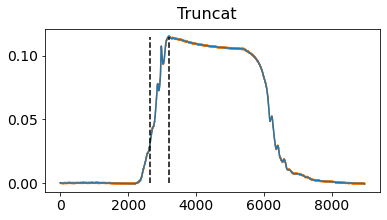


MLSi20HV7kV10mL.5Hz - Trial13 - Seg3
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.115 (bar) in 0.291 (sec)

(8961,)
0.12697794804982626
0.1155118255291952


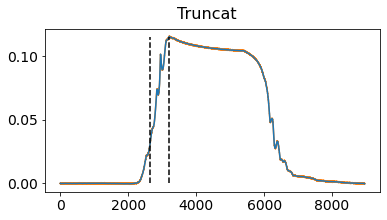


MLSi20HV7kV10mL.5Hz - Trial13 - Seg4
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.116 (bar) in 0.291 (sec)

(8957,)
0.12635247212427056
0.11483993878025586


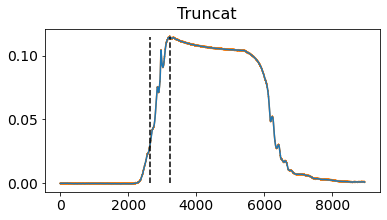


MLSi20HV7kV10mL.5Hz - Trial13 - Seg5
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.115 (bar) in 0.295 (sec)

(8917,)
0.13302421533019823
0.12164991476941242


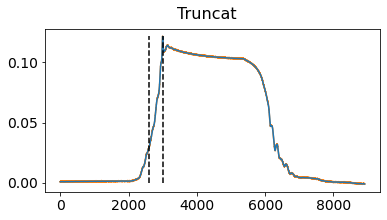


MLSi20HV7kV10mL.5Hz - Trial13 - Seg6
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.122 (bar) in 0.194 (sec)

(9030,)
0.1279562565487724
0.11658123531232437


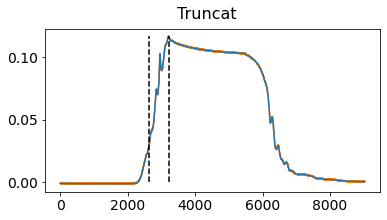


MLSi20HV7kV10mL.5Hz - Trial13 - Seg7
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.117 (bar) in 0.289 (sec)

(8996,)
0.12564680697748973
0.11428243205719774


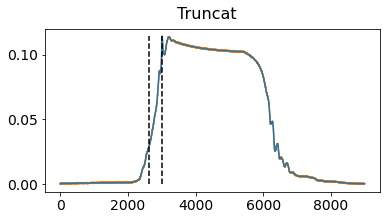


MLSi20HV7kV10mL.5Hz - Trial13 - Seg8
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.115 (bar) in 0.198 (sec)

(8901,)
0.12591945032965504
0.11454628602879224


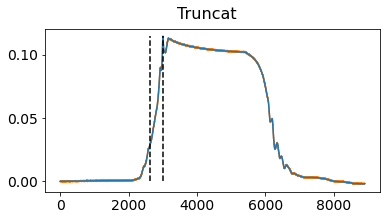


MLSi20HV7kV10mL.5Hz - Trial13 - Seg9
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.115 (bar) in 0.190 (sec)

(8990,)
0.1270741751152964
0.11571278059874274


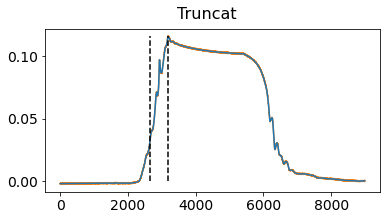


MLSi20HV7kV10mL.5Hz - Trial13 - Seg10
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.116 (bar) in 0.275 (sec)

(8998,)
0.12587133679692
0.11463648963178738


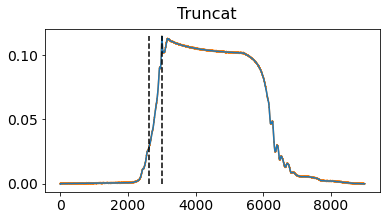


MLSi20HV7kV10mL.5Hz - Trial13 - Seg11
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.115 (bar) in 0.188 (sec)

(8966,)
0.16652727195804184
0.1553112592458571


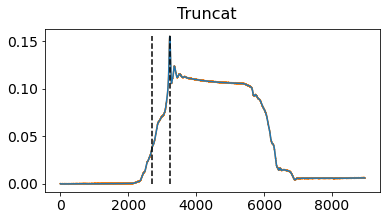


MLSi20HV7kV10mL.5Hz - Trial13 - Seg12
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.155 (bar) in 0.258 (sec)

(8952,)
0.15247812039940564
0.14099587952309323


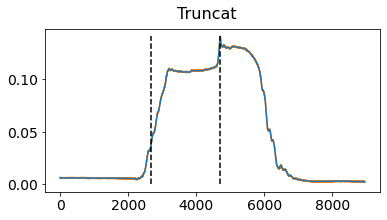


MLSi20HV7kV10mL.5Hz - Trial13 - Seg13
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.141 (bar) in 1.022 (sec)

(8918,)
0.15558946218293923
0.1441234524409565


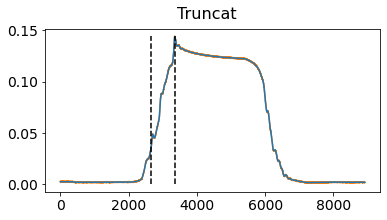


MLSi20HV7kV10mL.5Hz - Trial13 - Seg14
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.144 (bar) in 0.345 (sec)

(9027,)
0.15828382001610233
0.14680663175646566


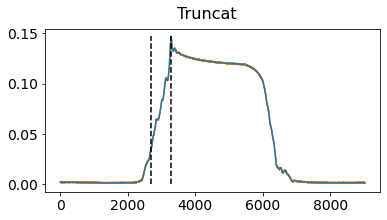


MLSi20HV7kV10mL.5Hz - Trial13 - Seg15
Avg. Pressure of zipping = 0.082 (bar), Max. P. = 0.147 (bar) in 0.291 (sec)

(9010,)
0.1559102190678396
0.14463972403268488


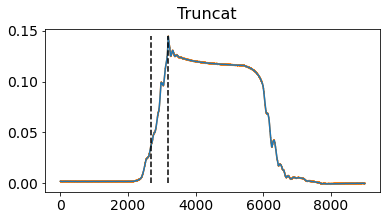


MLSi20HV7kV10mL.5Hz - Trial13 - Seg16
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.145 (bar) in 0.259 (sec)

(8935,)
0.16017628563701453
0.14865654057763536


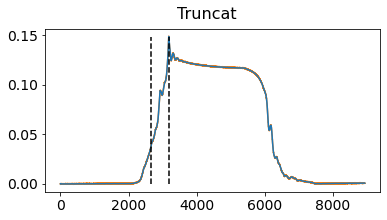


MLSi20HV7kV10mL.5Hz - Trial13 - Seg17
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.149 (bar) in 0.263 (sec)

MLSi20HV7kV10mL1Hz
Signal frequency (Hz) = 1.000
(82000,)
max value of raw data = 0.175
0.16556349861315117
[ 5296  9788 14218 18699 23190 27662 32136 36535 41026 45483 49958 54435
 58912 63382 67797 72284 76760]
[ 7934 12419 16897 21387 25847 30321 34786 39202 43678 48165 52643 57091
 61608 66076 70465 74934 79409]
Avg. segment length = 4466
(4467,)
0.1748188374327164
0.16644387608595723


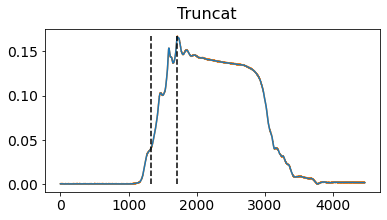


MLSi20HV7kV10mL1Hz - Trial14 - Seg1
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.167 (bar) in 0.190 (sec)

(4488,)
0.16019232348125953
0.15180289148564868


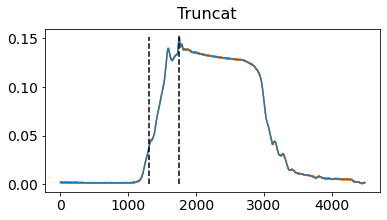


MLSi20HV7kV10mL1Hz - Trial14 - Seg2
Avg. Pressure of zipping = 0.099 (bar), Max. P. = 0.152 (bar) in 0.223 (sec)

(4454,)
0.1600800585715444
0.15186919100118046


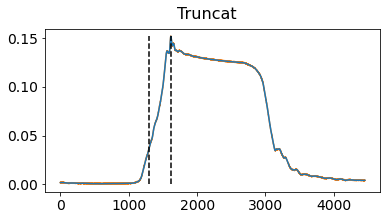


MLSi20HV7kV10mL1Hz - Trial14 - Seg3
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.152 (bar) in 0.158 (sec)

(4486,)
0.15728947367291118
0.1490547890199091


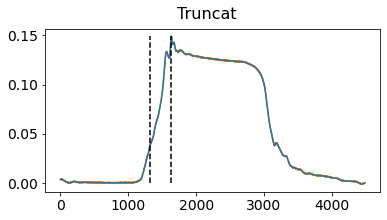


MLSi20HV7kV10mL1Hz - Trial14 - Seg4
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.149 (bar) in 0.159 (sec)

(4475,)
0.13616763280222186
0.1279254978722349


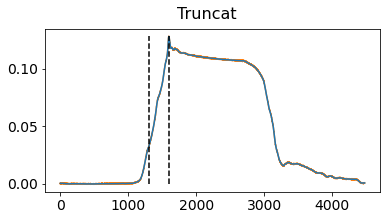


MLSi20HV7kV10mL1Hz - Trial14 - Seg5
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.128 (bar) in 0.147 (sec)

(4473,)
0.13422705364857462
0.12613615226017066


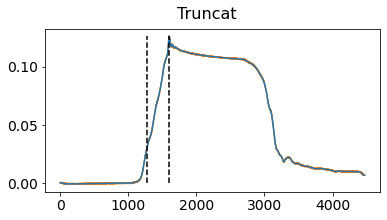


MLSi20HV7kV10mL1Hz - Trial14 - Seg6
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.126 (bar) in 0.161 (sec)

(4470,)
0.16679991531020716
0.15849945882327277


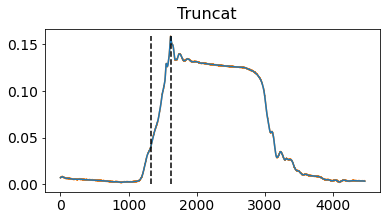


MLSi20HV7kV10mL1Hz - Trial14 - Seg7
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.159 (bar) in 0.147 (sec)

(4407,)
0.15531681883077392
0.14722828868602802


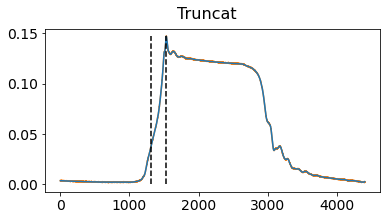


MLSi20HV7kV10mL1Hz - Trial14 - Seg8
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.147 (bar) in 0.113 (sec)

(4484,)
0.1445554253423665
0.13639327044616395


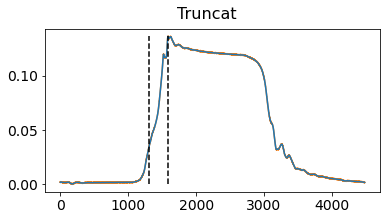


MLSi20HV7kV10mL1Hz - Trial14 - Seg9
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.137 (bar) in 0.141 (sec)

(4472,)
0.1390544447663252
0.13081002050930396


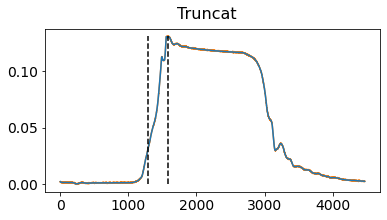


MLSi20HV7kV10mL1Hz - Trial14 - Seg10
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.131 (bar) in 0.144 (sec)

(4476,)
0.15796306313120195
0.14992401376655648


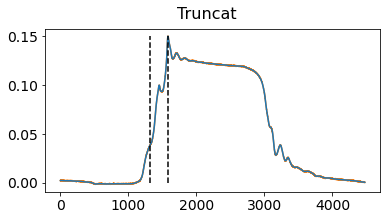


MLSi20HV7kV10mL1Hz - Trial14 - Seg11
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.150 (bar) in 0.136 (sec)

(4463,)
0.1385412337504846
0.13072083547447436


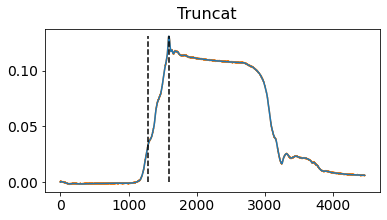


MLSi20HV7kV10mL1Hz - Trial14 - Seg12
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.131 (bar) in 0.153 (sec)

(4497,)
0.15730551151715622
0.14891360310927582


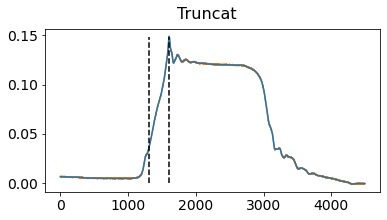


MLSi20HV7kV10mL1Hz - Trial14 - Seg13
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.149 (bar) in 0.147 (sec)

(4469,)
0.15255830962063074
0.1442340497790691


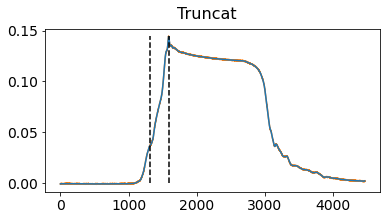


MLSi20HV7kV10mL1Hz - Trial14 - Seg14
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.145 (bar) in 0.140 (sec)

(4402,)
0.13571857316336133
0.12754095489832878


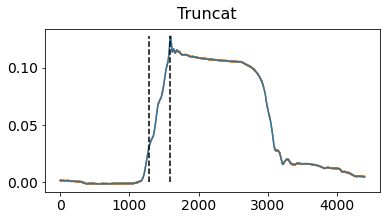


MLSi20HV7kV10mL1Hz - Trial14 - Seg15
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.128 (bar) in 0.153 (sec)

(4478,)
0.13292798826472813
0.1249619773027382


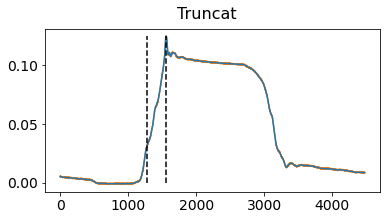


MLSi20HV7kV10mL1Hz - Trial14 - Seg16
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.125 (bar) in 0.140 (sec)

(4475,)
0.1598234530636241
0.1513702392740273


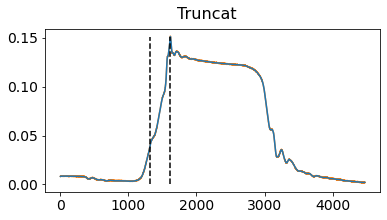


MLSi20HV7kV10mL1Hz - Trial14 - Seg17
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.152 (bar) in 0.152 (sec)

MLSi20HV7kV10mL2Hz
Signal frequency (Hz) = 2.000
(41000,)
max value of raw data = 0.181
0.16336610292411913
[ 3655  5908  8169 10434 12688 14953 17203 19455 21720 23973 26220 28424
 30682 32937 35187 37440]
[ 4999  7256  9507 11774 14033 16286 18539 20793 23056 25307 27503 29757
 32019 34273 36525 38771]
Avg. segment length = 2251
(2252,)
0.1811698237537437
0.17313791261490777


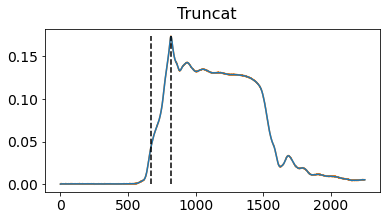


MLSi20HV7kV10mL2Hz - Trial16 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.174 (bar) in 0.074 (sec)

(2255,)
0.1564394679279252
0.14835949986426095


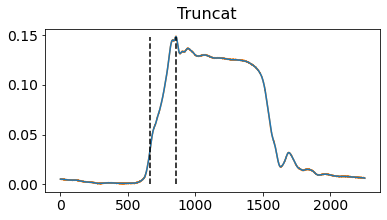


MLSi20HV7kV10mL2Hz - Trial16 - Seg2
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.149 (bar) in 0.095 (sec)

(2256,)
0.15283095297279606
0.14524146767875365


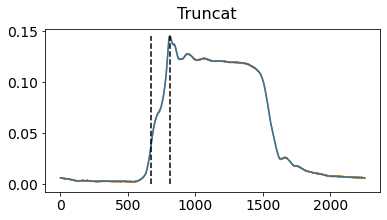


MLSi20HV7kV10mL2Hz - Trial16 - Seg3
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.145 (bar) in 0.070 (sec)

(2266,)
0.17470657252300126
0.16698330918277376


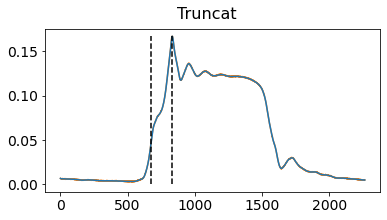


MLSi20HV7kV10mL2Hz - Trial16 - Seg4
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.167 (bar) in 0.081 (sec)

(2256,)
0.15647154361641524
0.1483392492521264


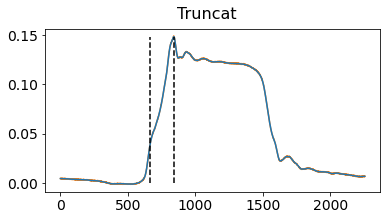


MLSi20HV7kV10mL2Hz - Trial16 - Seg5
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.149 (bar) in 0.089 (sec)

(2259,)
0.13650442753136724
0.12863137451309545


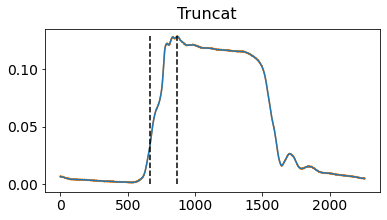


MLSi20HV7kV10mL2Hz - Trial16 - Seg6
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.129 (bar) in 0.102 (sec)

(2252,)
0.14099502391997243
0.1330734732562363


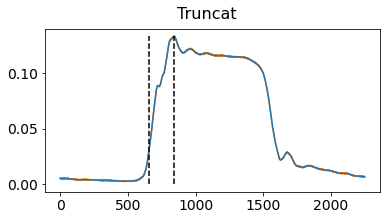


MLSi20HV7kV10mL2Hz - Trial16 - Seg7
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.133 (bar) in 0.091 (sec)

(2253,)
0.14261484618871928
0.13466230738647275


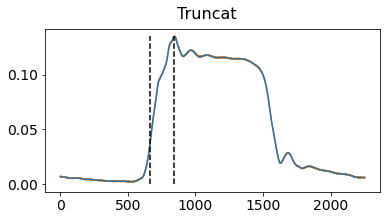


MLSi20HV7kV10mL2Hz - Trial16 - Seg8
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.135 (bar) in 0.092 (sec)

(2264,)
0.16923766763544995
0.16156477237157352


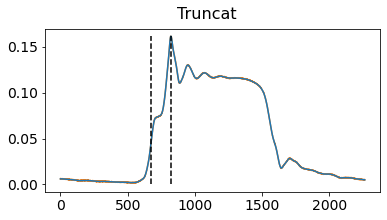


MLSi20HV7kV10mL2Hz - Trial16 - Seg9
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.162 (bar) in 0.076 (sec)

(2252,)
0.14203748379589862
0.1340411526178688


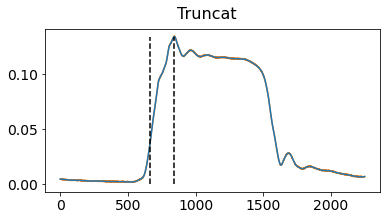


MLSi20HV7kV10mL2Hz - Trial16 - Seg10
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.134 (bar) in 0.092 (sec)

(2221,)
0.14104313745270747
0.13299166554010255


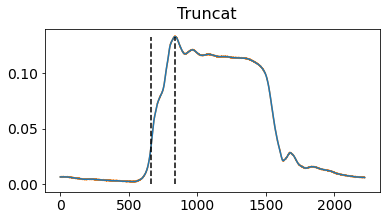


MLSi20HV7kV10mL2Hz - Trial16 - Seg11
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.133 (bar) in 0.088 (sec)

(2229,)
0.1405620021253569
0.13251935344306345


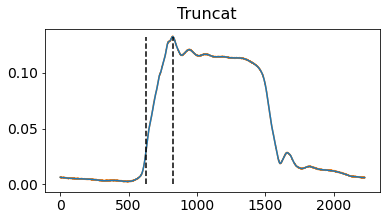


MLSi20HV7kV10mL2Hz - Trial16 - Seg12
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.133 (bar) in 0.096 (sec)

(2260,)
0.1688367215293245
0.16116910595572828


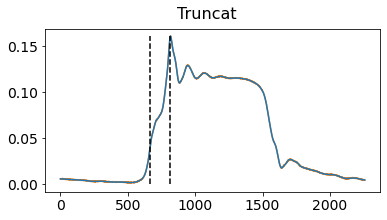


MLSi20HV7kV10mL2Hz - Trial16 - Seg13
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.161 (bar) in 0.075 (sec)

(2255,)
0.14009690464225139
0.1321855677793162


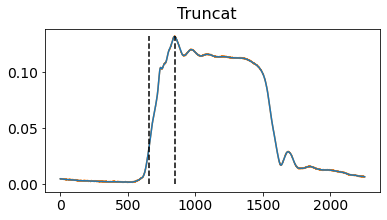


MLSi20HV7kV10mL2Hz - Trial16 - Seg14
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.132 (bar) in 0.094 (sec)

(2251,)
0.16394517903459385
0.15613225117465138


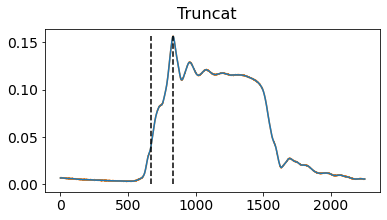


MLSi20HV7kV10mL2Hz - Trial16 - Seg15
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.156 (bar) in 0.083 (sec)

(2249,)
0.13860538512746468
0.1304618745807873


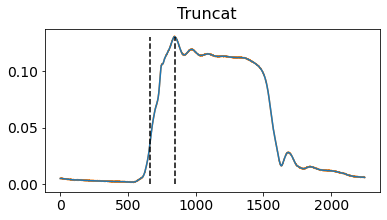


MLSi20HV7kV10mL2Hz - Trial16 - Seg16
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.131 (bar) in 0.092 (sec)

MLSi20HV7kV10mL4Hz
Signal frequency (Hz) = 4.000
(20500,)
max value of raw data = 0.188
0.16664044895718405
[ 2826  3957  5088  6221  7353  8485  9613 10741 11870 12996 14119 15248
 16375 17508 18633 19761]
[ 3505  4635  5765  6896  8027  9159 10285 11416 12542 13664 14791 15918
 17046 18176 19300 20431]
Avg. segment length = 1128
(1129,)
0.18800194540212156
0.17988984761267987


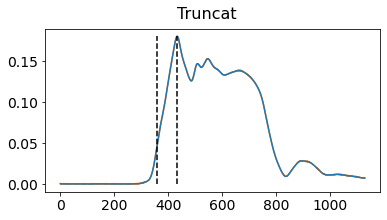


MLSi20HV7kV10mL4Hz - Trial17 - Seg1
Avg. Pressure of zipping = 0.117 (bar), Max. P. = 0.180 (bar) in 0.037 (sec)

(1131,)
0.16829143482499387
0.16015501488747308


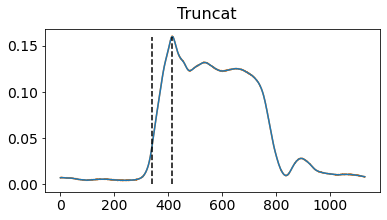


MLSi20HV7kV10mL4Hz - Trial17 - Seg2
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.161 (bar) in 0.038 (sec)

(1130,)
0.16169988084029127
0.15387250657442483


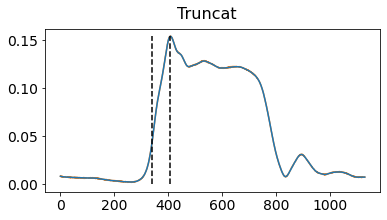


MLSi20HV7kV10mL4Hz - Trial17 - Seg3
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.154 (bar) in 0.035 (sec)

(1132,)
0.16917351625846988
0.1609772611376159


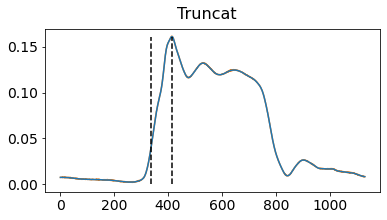


MLSi20HV7kV10mL4Hz - Trial17 - Seg4
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.161 (bar) in 0.038 (sec)

(1132,)
0.15568568924840934
0.1477630233798821


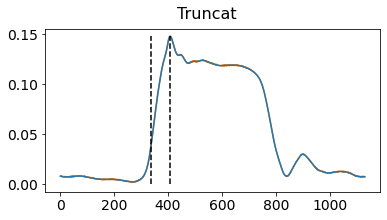


MLSi20HV7kV10mL4Hz - Trial17 - Seg5
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.148 (bar) in 0.036 (sec)

(1132,)
0.15159603896592963
0.14374157466771167


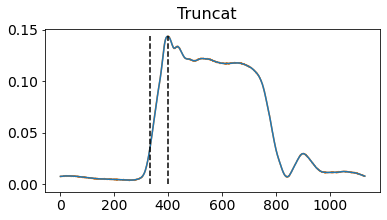


MLSi20HV7kV10mL4Hz - Trial17 - Seg6
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.144 (bar) in 0.033 (sec)

(1127,)
0.15032904927057317
0.14266377654398393


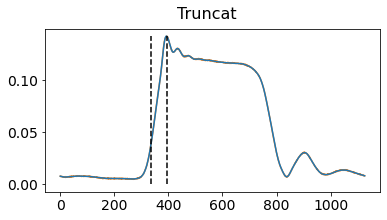


MLSi20HV7kV10mL4Hz - Trial17 - Seg7
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.143 (bar) in 0.029 (sec)

(1129,)
0.1398563369785761
0.13192846070931122


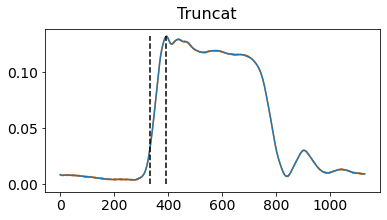


MLSi20HV7kV10mL4Hz - Trial17 - Seg8
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.132 (bar) in 0.030 (sec)

(1128,)
0.14229408930381893
0.13422171552617657


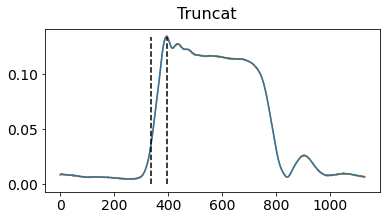


MLSi20HV7kV10mL4Hz - Trial17 - Seg9
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.135 (bar) in 0.029 (sec)

(1124,)
0.1496714976565274
0.14184729961360387


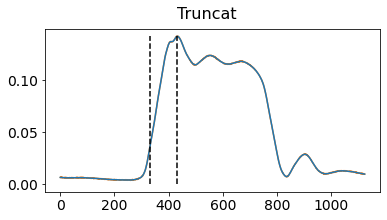


MLSi20HV7kV10mL4Hz - Trial17 - Seg10
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.142 (bar) in 0.051 (sec)

(1125,)
0.14035351015017167
0.13213496111465473


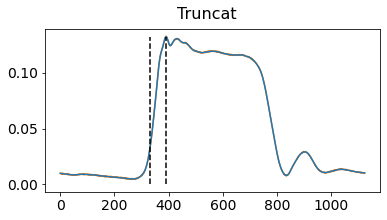


MLSi20HV7kV10mL4Hz - Trial17 - Seg11
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.133 (bar) in 0.029 (sec)

(1128,)
0.13935916380698055
0.1312973248105305


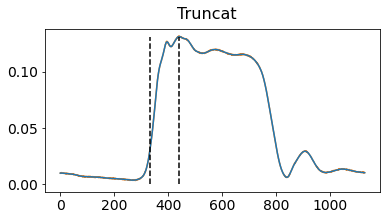


MLSi20HV7kV10mL4Hz - Trial17 - Seg12
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.132 (bar) in 0.053 (sec)

(1127,)
0.13783556860370377
0.13001569251318443


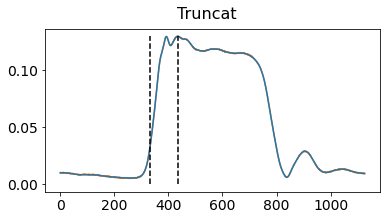


MLSi20HV7kV10mL4Hz - Trial17 - Seg13
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.130 (bar) in 0.051 (sec)

(1132,)
0.14069030487931708
0.13249489453570742


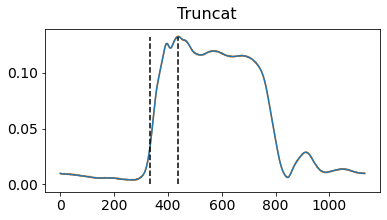


MLSi20HV7kV10mL4Hz - Trial17 - Seg14
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.133 (bar) in 0.053 (sec)

(1124,)
0.13692141148173773
0.12907656008386226


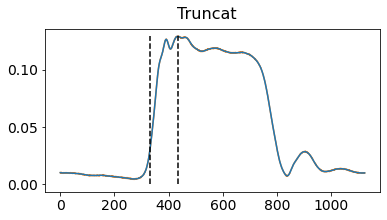


MLSi20HV7kV10mL4Hz - Trial17 - Seg15
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.129 (bar) in 0.051 (sec)

(1130,)
0.13850915806199457
0.13049003522620412


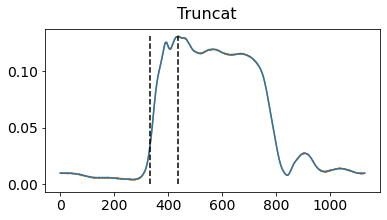


MLSi20HV7kV10mL4Hz - Trial17 - Seg16
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.131 (bar) in 0.051 (sec)

MLSi20HV7kV10mL10Hz
Signal frequency (Hz) = 10.000
(8200,)
max value of raw data = 0.199
0.18595847240965774
[2378 2814 3265 3718 4171 4625 5074 5528 5979 6433 6888 7340 7793]
[2634 3085 3537 3988 4438 4886 5338 5791 6245 6701 7154 7604 8059]
Avg. segment length = 451
(452,)
0.19866711182505886
0.19153768713026798


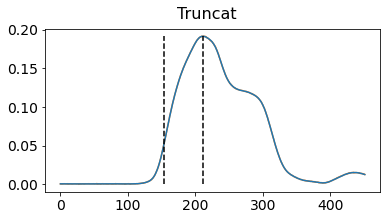


MLSi20HV7kV10mL10Hz - Trial18 - Seg1
Avg. Pressure of zipping = 0.140 (bar), Max. P. = 0.192 (bar) in 0.029 (sec)

(443,)
0.17690375718456877
0.16965008439211718


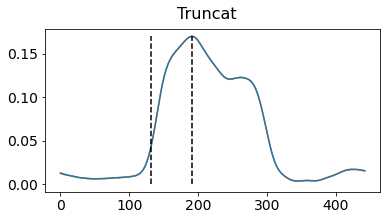


MLSi20HV7kV10mL10Hz - Trial18 - Seg2
Avg. Pressure of zipping = 0.131 (bar), Max. P. = 0.170 (bar) in 0.029 (sec)

(452,)
0.17578110808741748
0.16855631352670164


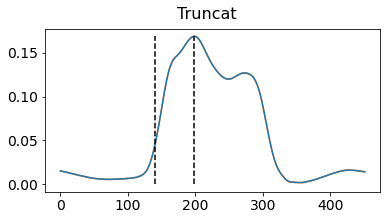


MLSi20HV7kV10mL10Hz - Trial18 - Seg3
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.169 (bar) in 0.029 (sec)

(452,)
0.17642262185721824
0.16943026489077978


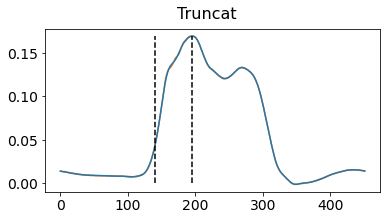


MLSi20HV7kV10mL10Hz - Trial18 - Seg4
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.169 (bar) in 0.028 (sec)

(451,)
0.17393675599924036
0.16680800936975573


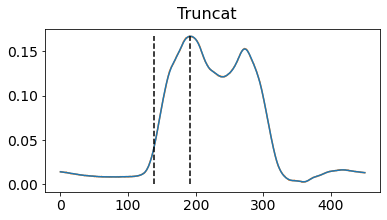


MLSi20HV7kV10mL10Hz - Trial18 - Seg5
Avg. Pressure of zipping = 0.124 (bar), Max. P. = 0.167 (bar) in 0.026 (sec)

(451,)
0.1876972263614662
0.18028279192145596


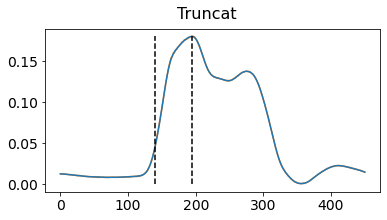


MLSi20HV7kV10mL10Hz - Trial18 - Seg6
Avg. Pressure of zipping = 0.140 (bar), Max. P. = 0.181 (bar) in 0.027 (sec)

(451,)
0.1841207870948271
0.17615686862612606


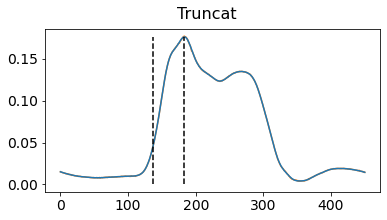


MLSi20HV7kV10mL10Hz - Trial18 - Seg7
Avg. Pressure of zipping = 0.130 (bar), Max. P. = 0.177 (bar) in 0.023 (sec)

(453,)
0.17983868268140715
0.1719907627224168


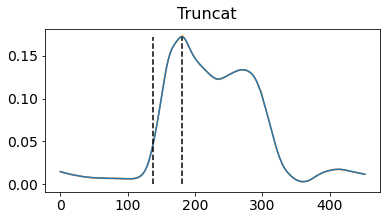


MLSi20HV7kV10mL10Hz - Trial18 - Seg8
Avg. Pressure of zipping = 0.126 (bar), Max. P. = 0.173 (bar) in 0.021 (sec)

(453,)
0.17521978353884185
0.16767608922682947


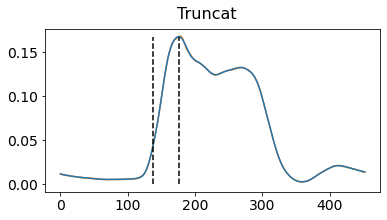


MLSi20HV7kV10mL10Hz - Trial18 - Seg9
Avg. Pressure of zipping = 0.122 (bar), Max. P. = 0.168 (bar) in 0.019 (sec)

(455,)
0.1763103569475031
0.16829931605735893


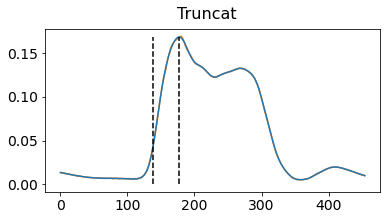


MLSi20HV7kV10mL10Hz - Trial18 - Seg10
Avg. Pressure of zipping = 0.123 (bar), Max. P. = 0.169 (bar) in 0.019 (sec)

(454,)
0.1671206721951075
0.1588786108021399


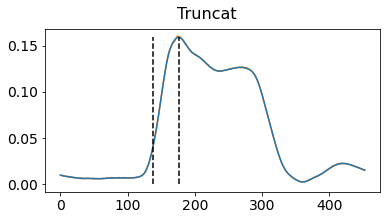


MLSi20HV7kV10mL10Hz - Trial18 - Seg11
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.160 (bar) in 0.019 (sec)

(451,)
0.17141881445277246
0.16251759693385842


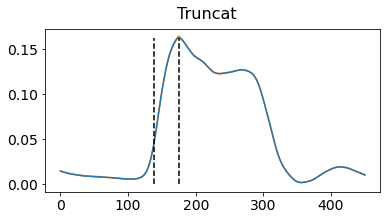


MLSi20HV7kV10mL10Hz - Trial18 - Seg12
Avg. Pressure of zipping = 0.119 (bar), Max. P. = 0.164 (bar) in 0.018 (sec)

(454,)
0.17592544868562265
0.16648918860574927


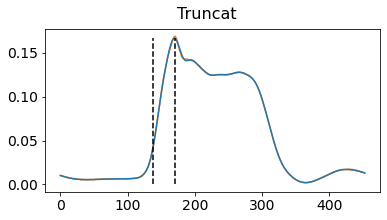


MLSi20HV7kV10mL10Hz - Trial18 - Seg13
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.169 (bar) in 0.016 (sec)

MLSi20HV7kV10mL20Hz
Signal frequency (Hz) = 20.000
(4100,)
max value of raw data = 0.204
0.17962349429732835
[2195 2408 2627 2833 3055 3272 3505 3726]
[2323 2540 2743 2967 3190 3414 3634 3858]
Avg. segment length = 219
(219,)
0.20441836274700548
0.18386939887722611


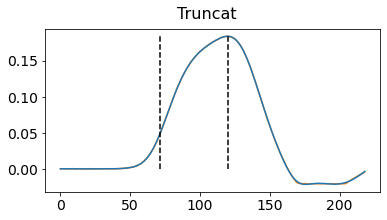


MLSi20HV7kV10mL20Hz - Trial19 - Seg1
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.184 (bar) in 0.025 (sec)

(215,)
0.20369665975597964
0.18304808428590105


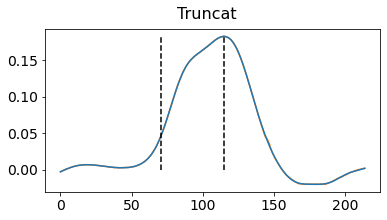


MLSi20HV7kV10mL20Hz - Trial19 - Seg2
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.183 (bar) in 0.022 (sec)

(211,)
0.19534094290432502
0.17561636470524142


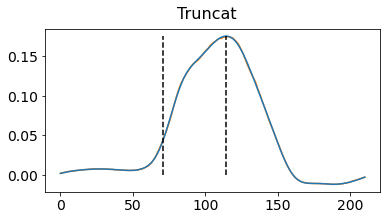


MLSi20HV7kV10mL20Hz - Trial19 - Seg3
Avg. Pressure of zipping = 0.131 (bar), Max. P. = 0.175 (bar) in 0.021 (sec)

(215,)
0.19901360923643424
0.17840909621272752


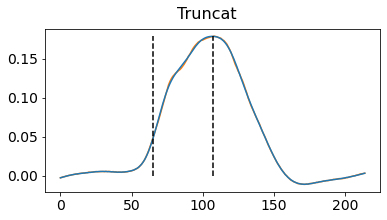


MLSi20HV7kV10mL20Hz - Trial19 - Seg4
Avg. Pressure of zipping = 0.135 (bar), Max. P. = 0.179 (bar) in 0.021 (sec)

(222,)
0.19694472732882687
0.17584205993872168


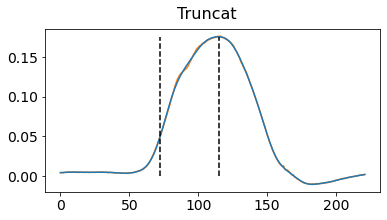


MLSi20HV7kV10mL20Hz - Trial19 - Seg5
Avg. Pressure of zipping = 0.134 (bar), Max. P. = 0.177 (bar) in 0.021 (sec)

(221,)
0.20355231915777447
0.1848420492473824


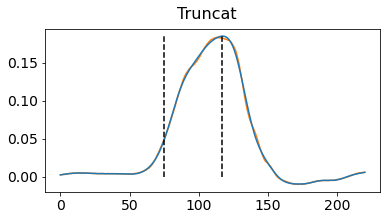


MLSi20HV7kV10mL20Hz - Trial19 - Seg6
Avg. Pressure of zipping = 0.137 (bar), Max. P. = 0.183 (bar) in 0.021 (sec)

(226,)
0.19971927438321507
0.17921003037903635


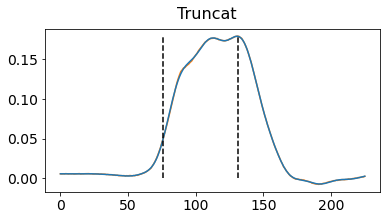


MLSi20HV7kV10mL20Hz - Trial19 - Seg7
Avg. Pressure of zipping = 0.148 (bar), Max. P. = 0.179 (bar) in 0.028 (sec)

(223,)
0.19325602315247262
0.17161875880058317


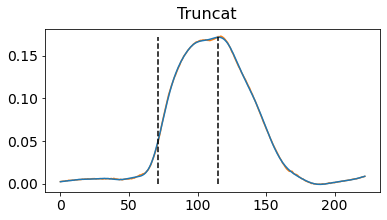


MLSi20HV7kV10mL20Hz - Trial19 - Seg8
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.173 (bar) in 0.022 (sec)



In [48]:
'''Measurement 2022 Frequency comparison'''
pressData = []
Fs = 2000

for root, directories, files in walk(".\Data220401Relabelled\Act6Freq"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
                cutInd = cutRepeatTrial(data, Fs, inactivePressure, 20, 8)           
                
                for i in range(len(cutInd)-1): 
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[cutInd[i]:cutInd[i+1]], Fs, 
                                                                               inactivePressure, 100, 10)
                    P0 = data[cutInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    (data[cutInd[i]:cutInd[i]+int(1.5*segInd[1])] - inactivePressure)*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")


# ''' Incorrect Index? '''
# for i in sigData.index:
#     ax,_=aPlot()
#     ax.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
#     ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 10], '--k')
#     ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 10], '--k')
#     ax.set_ylabel('Pressure_kPa')

(5000,)
0.05472745972601804
0.0477077924598191


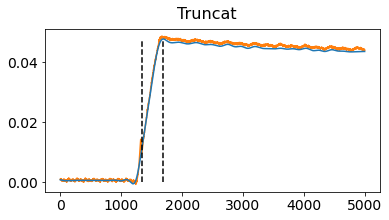


6mLBOPP12 - Trial06
Avg. Pressure of zipping = 0.034 (bar), Max. P. = 0.049 (bar) in 0.346 (sec)

(5000,)
0.05886522354123281
0.04912346144868569


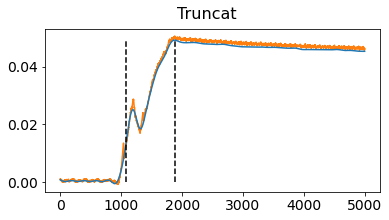


6mLBOPP12 - Trial07
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.051 (bar) in 0.805 (sec)

(5000,)
0.0513915881230542
0.04230256828986469


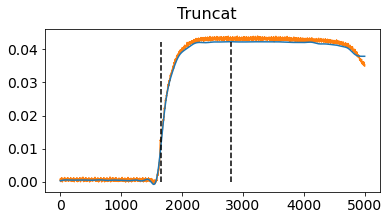


6mLBOPP12 - Trial08
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.044 (bar) in 1.148 (sec)

(5000,)
0.03427920831361948
0.030170123727611128


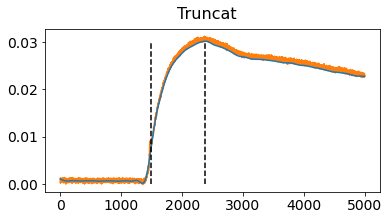


6mLBOPP12 - Trial11
Avg. Pressure of zipping = 0.025 (bar), Max. P. = 0.031 (bar) in 0.894 (sec)

(5000,)
0.04369342288544533
0.038931310844274536


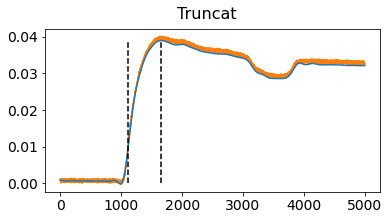


6mLBOPP12 - Trial12
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.040 (bar) in 0.545 (sec)

(5000,)
0.05557746547100402
0.04351493087075624


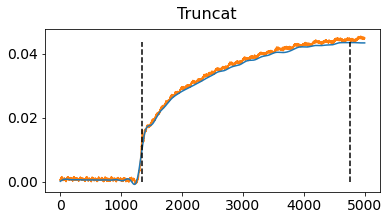


6mLBOPP16 - Trial04
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.045 (bar) in 3.412 (sec)

(5000,)
0.07139077989659223
0.062287784988741636


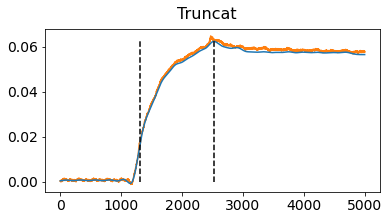


6mLBOPP16 - Trial05
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.065 (bar) in 1.221 (sec)

(5000,)
0.06807094613787341
0.057905572265647354


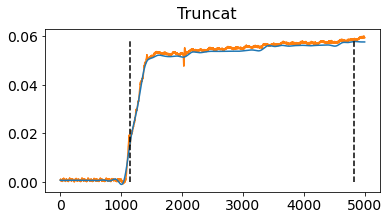


6mLBOPP16 - Trial06
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.060 (bar) in 3.694 (sec)

(5000,)
0.07241720192827342
0.059982106386711496


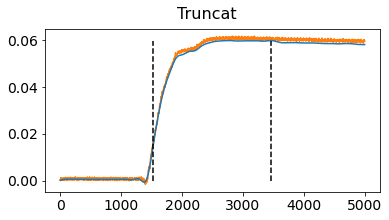


6mLBOPP16 - Trial07
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.062 (bar) in 1.931 (sec)

(5000,)
0.06398129585539371
0.05144548150863611


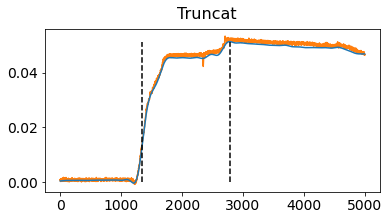


6mLBOPP16 - Trial08
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.053 (bar) in 1.439 (sec)

(5000,)
0.09134185813739522
0.08276217968287539


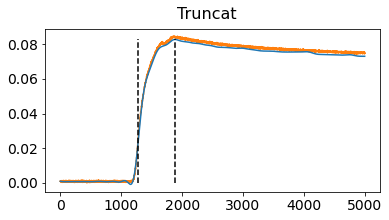


BOPP16ShiftedU7kV - Trial01
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.085 (bar) in 0.614 (sec)

(5000,)
0.08207198416377454
0.07077088080983744


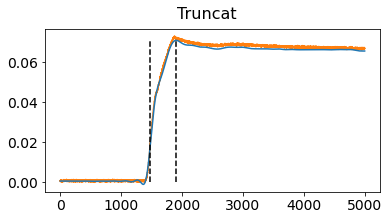


BOPP16ShiftedU7kV - Trial02
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.073 (bar) in 0.428 (sec)

(5000,)
0.07307475354231918
0.06012926944349377


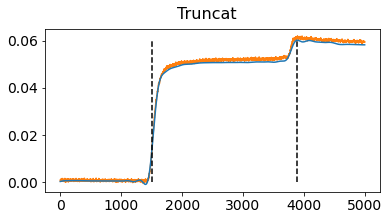


BOPP16ShiftedU7kV - Trial03
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.062 (bar) in 2.383 (sec)

(5000,)
0.09467772974035907
0.08423075374790973


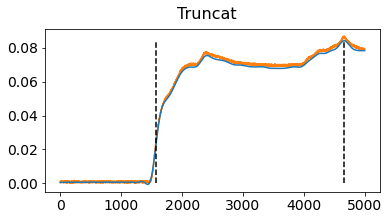


BOPP16ShiftedU7kV - Trial04
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.087 (bar) in 3.096 (sec)

(5000,)
0.06592187500904094
0.0534080216706563


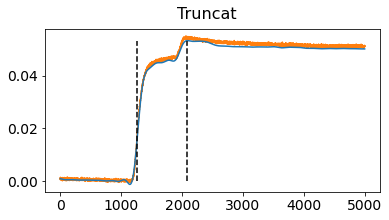


BOPP16ShiftedU7kV - Trial05
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.055 (bar) in 0.835 (sec)

(5000,)
0.13939123949547058
0.12676755127723754


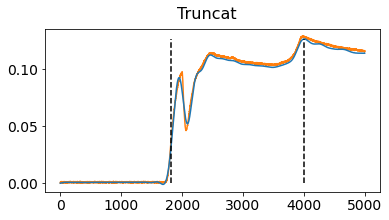


L0Ws16ShiftedU9kV - Trial01
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.129 (bar) in 2.188 (sec)

(5000,)
0.09555981117383508
0.08431035945612739


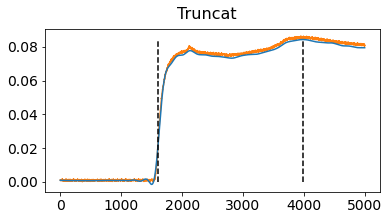


L0Ws16ShiftedU9kV - Trial02
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.086 (bar) in 2.378 (sec)

(5000,)
0.09076449574457456
0.075042657847824


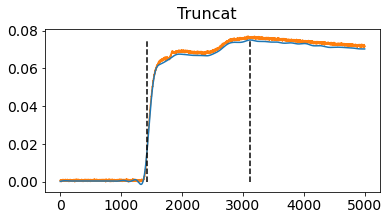


L0Ws16ShiftedU9kV - Trial03
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.077 (bar) in 1.689 (sec)

(5000,)
0.10385137664850963
0.09395322468884543


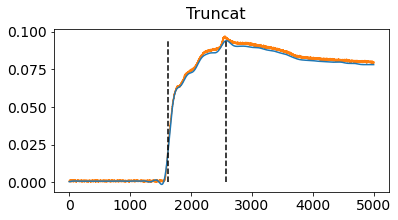


L0Ws16ShiftedU9kV - Trial04
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.097 (bar) in 0.952 (sec)

(5000,)
0.1099938709943517
0.09984011858492356


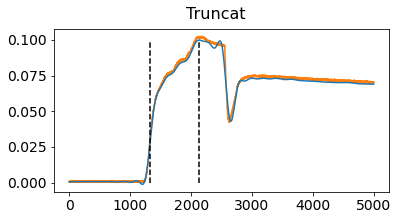


L0Ws16ShiftedU9kV - Trial05
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.103 (bar) in 0.813 (sec)

(5000,)
0.07198418013365793
0.05849075494258279


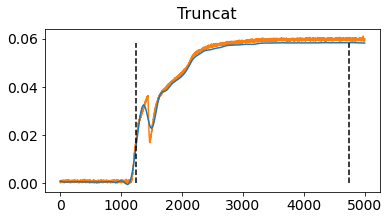


L0Ws16NoShift - Trial01
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.061 (bar) in 3.510 (sec)

(5000,)
0.06027655383479443
0.038758262497896226


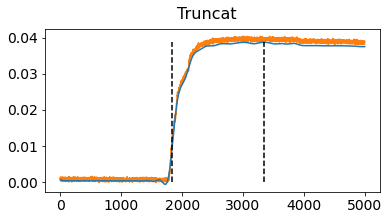


L0Ws16NoShift - Trial02
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.040 (bar) in 1.513 (sec)

(5000,)
0.049900068608267484
0.02950525494460549


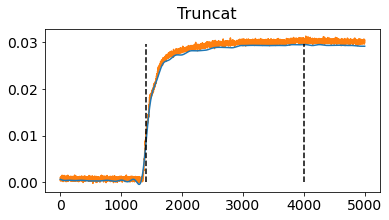


L0Ws16NoShift - Trial03
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.031 (bar) in 2.605 (sec)

(5000,)
0.04563400203909257
0.026633362631369305


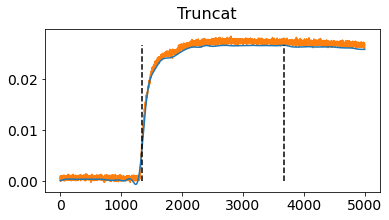


L0Ws16NoShift - Trial04
Avg. Pressure of zipping = 0.026 (bar), Max. P. = 0.028 (bar) in 2.324 (sec)

(5000,)
0.06829547595730368
0.04950243196779103


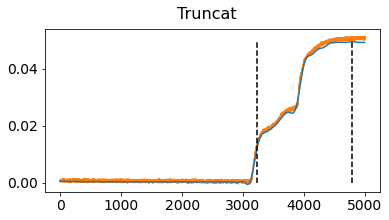


L0Ws16NoShift - Trial05
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.051 (bar) in 1.561 (sec)

(5000,)
0.03235466700421727
0.018814763325201413


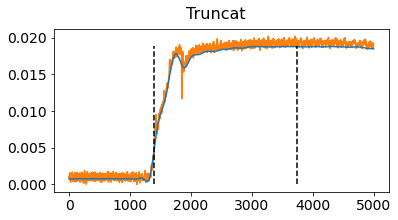


6mLL0Ws12SoftTube - Trial06
Avg. Pressure of zipping = 0.018 (bar), Max. P. = 0.020 (bar) in 2.342 (sec)

(5000,)
0.07137474205234721
0.0670736917222527


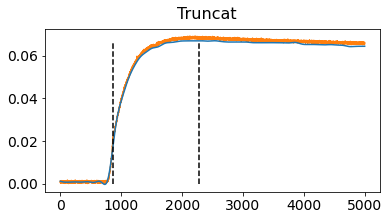


6mLL0Ws12SoftTube - Trial07
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.069 (bar) in 1.414 (sec)

(5000,)
0.060789764850635024
0.054268701170275546


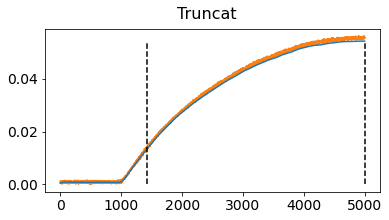


6mLL0Ws12SoftTube - Trial08
Avg. Pressure of zipping = 0.042 (bar), Max. P. = 0.056 (bar) in 3.570 (sec)

(5000,)
0.06932189798898486
0.060501434658617674


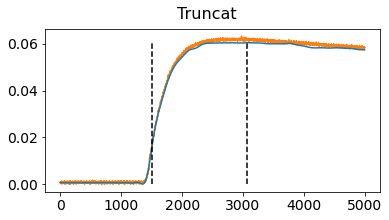


6mLL0Ws12SoftTube - Trial09
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.063 (bar) in 1.561 (sec)

(5000,)
0.05318782667849627
0.047616574421609804


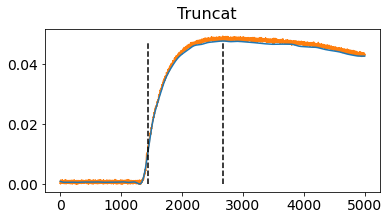


6mLL0Ws12SoftTube - Trial10
Avg. Pressure of zipping = 0.041 (bar), Max. P. = 0.049 (bar) in 1.229 (sec)

(5000,)
0.13738650896484325
0.1332312352623805


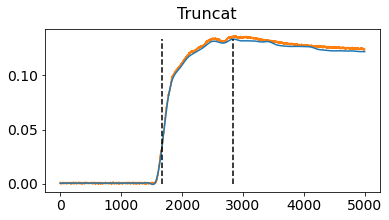


Mylar16 - Trial01
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.136 (bar) in 1.174 (sec)

(5000,)
0.11494956486606242
0.11132471507410525


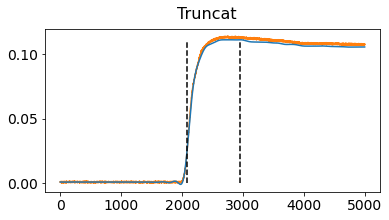


Mylar16 - Trial02
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.114 (bar) in 0.863 (sec)

(5000,)
0.11985714520503807
0.11607683648969624


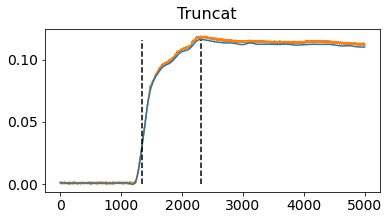


Mylar16 - Trial03
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.119 (bar) in 0.973 (sec)

(5000,)
0.12171753513746021
0.11765541980493789


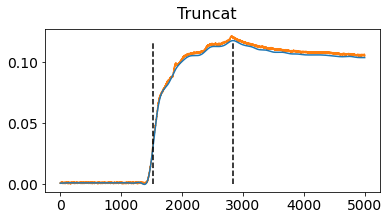


Mylar16 - Trial04
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.121 (bar) in 1.318 (sec)

(5000,)
0.09676264949221146
0.09358913100002687


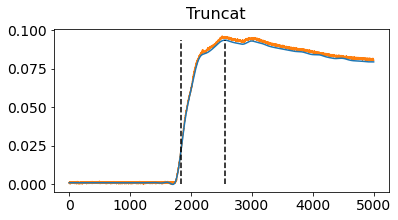


Mylar16 - Trial05
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.096 (bar) in 0.715 (sec)

(5000,)
0.1721405174437983
0.16841921291948636


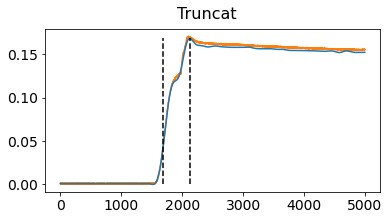


Mylar16NoShift - Trial01
Avg. Pressure of zipping = 0.122 (bar), Max. P. = 0.171 (bar) in 0.437 (sec)

(5000,)
0.14569411228376283
0.14224037336822515


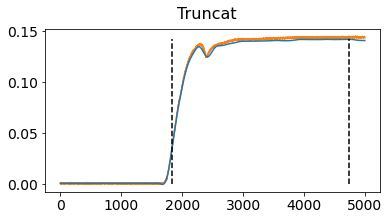


Mylar16NoShift - Trial02
Avg. Pressure of zipping = 0.136 (bar), Max. P. = 0.145 (bar) in 2.904 (sec)

(5000,)
0.1782927144718704
0.17547023105261603


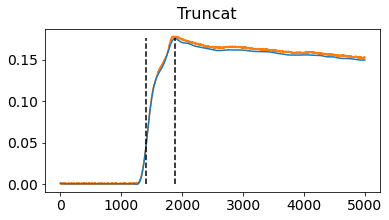


Mylar16NoShift - Trial03
Avg. Pressure of zipping = 0.134 (bar), Max. P. = 0.178 (bar) in 0.481 (sec)

(5000,)
0.16689614237567726
0.1624234426282226


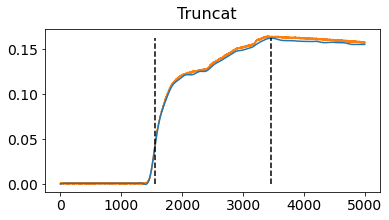


Mylar16NoShift - Trial04
Avg. Pressure of zipping = 0.132 (bar), Max. P. = 0.165 (bar) in 1.914 (sec)

(5000,)
0.11228728272138935
0.10345156225332104


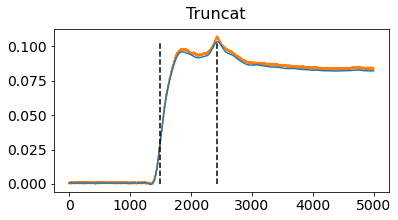


Mylar16NoShift - Trial05
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.108 (bar) in 0.950 (sec)

(5000,)
0.07984272381371697
0.07692932230575678


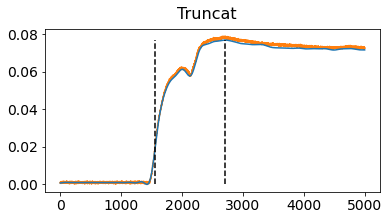


BOPP16 - Trial01
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.079 (bar) in 1.150 (sec)

(5000,)
0.05968315359772875
0.05446187456785792


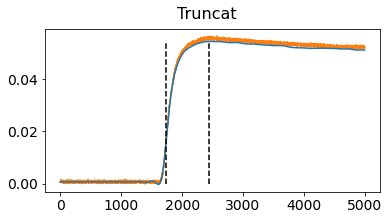


BOPP16 - Trial02
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.057 (bar) in 0.718 (sec)

(5000,)
0.04550569928513242
0.039886363449694616


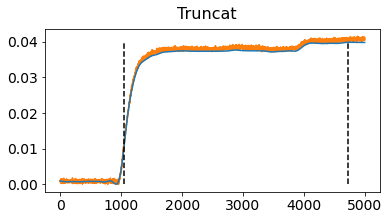


BOPP16 - Trial03
Avg. Pressure of zipping = 0.037 (bar), Max. P. = 0.042 (bar) in 3.689 (sec)

(5000,)
0.04282737929621434
0.03589414836728022


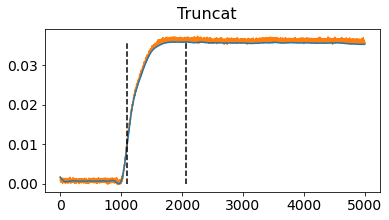


BOPP16 - Trial04
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.037 (bar) in 0.973 (sec)

(5000,)
0.045970796768237954
0.037515221913494226


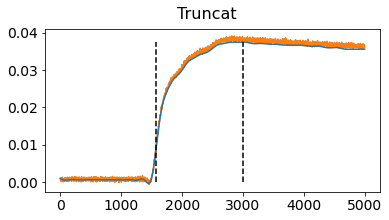


BOPP16 - Trial05
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.039 (bar) in 1.423 (sec)

(5000,)
0.0744860838358808
0.07157189006522968


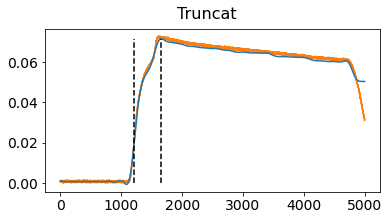


BOPP20 - Trial01
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.073 (bar) in 0.453 (sec)

(5000,)
0.07443797030314575
0.06806505508406496


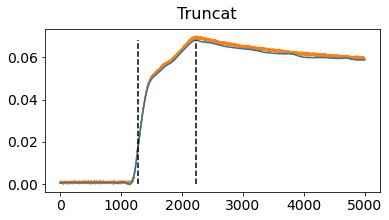


BOPP20 - Trial02
Avg. Pressure of zipping = 0.055 (bar), Max. P. = 0.070 (bar) in 0.952 (sec)

(5000,)
0.042314168280373744
0.02878738698116666


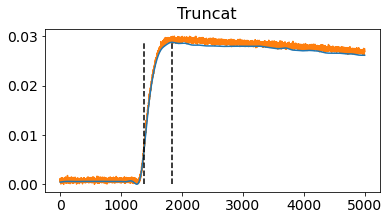


BOPP20 - Trial03
Avg. Pressure of zipping = 0.024 (bar), Max. P. = 0.030 (bar) in 0.455 (sec)

(5000,)
0.03782357189176857
0.027517760582741482


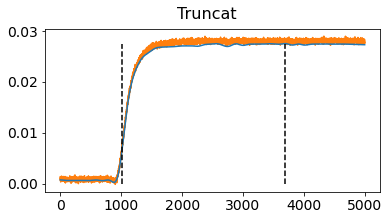


BOPP20 - Trial04
Avg. Pressure of zipping = 0.027 (bar), Max. P. = 0.029 (bar) in 2.673 (sec)

(5000,)
0.05079818788598851
0.03919396028444478


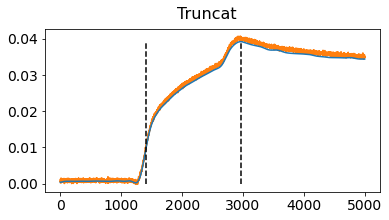


BOPP20 - Trial05
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.041 (bar) in 1.552 (sec)

(5000,)
0.09450131345366386
0.09226130512195181


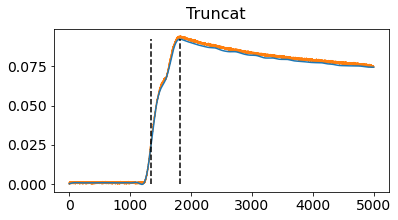


BOPP16U9kV - Trial01
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.094 (bar) in 0.483 (sec)

(5000,)
0.06585772363206087
0.05647393780744725


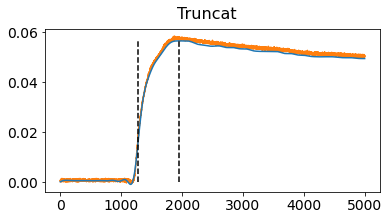


BOPP16U9kV - Trial02
Avg. Pressure of zipping = 0.047 (bar), Max. P. = 0.058 (bar) in 0.673 (sec)

(5000,)
0.0533000915882114
0.03807941787868408


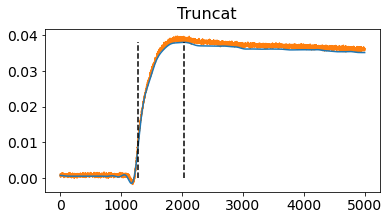


BOPP16U9kV - Trial03
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.040 (bar) in 0.747 (sec)

(5000,)
0.054839724635733174
0.0375760785565235


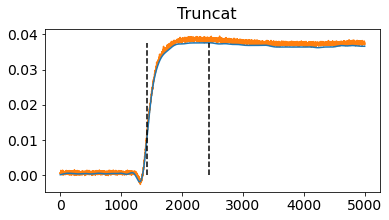


BOPP16U9kV - Trial04
Avg. Pressure of zipping = 0.035 (bar), Max. P. = 0.039 (bar) in 1.028 (sec)

(5000,)
0.05081422573023353
0.029741283485090912


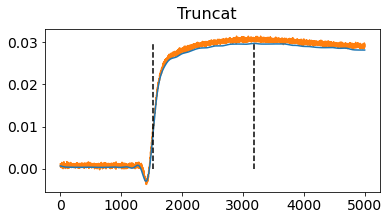


BOPP16U9kV - Trial05
Avg. Pressure of zipping = 0.028 (bar), Max. P. = 0.031 (bar) in 1.661 (sec)

(4200,)
0.09633933037982598
0.07573105176156185


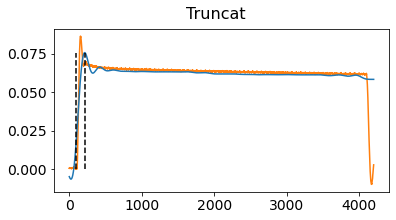


MLSi16SB7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.086 (bar) in 0.115 (sec)

(4200,)
0.06942782773668497
0.05237877397288375


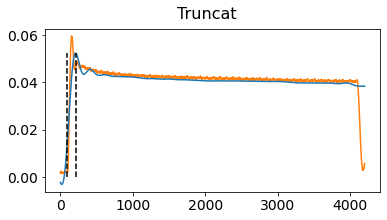


MLSi16SB7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.060 (bar) in 0.118 (sec)

(4200,)
0.0702297199489359
0.052050887772042524


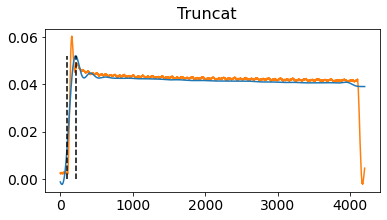


MLSi16SB7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.060 (bar) in 0.118 (sec)

(4200,)
0.13023363043156502
0.10789632834255662


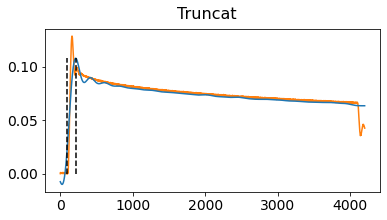


MLSi16SB7kV - Trial05 - Seg1
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.129 (bar) in 0.113 (sec)

(4200,)
0.11167784464007864
0.08292418873775591


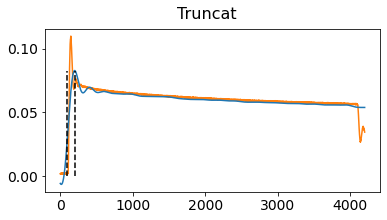


MLSi16SB7kV - Trial05 - Seg2
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.110 (bar) in 0.112 (sec)

(4200,)
0.07171153678149261
0.061036379121012896


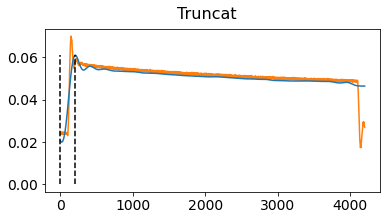


MLSi16SB7kV - Trial05 - Seg3
Avg. Pressure of zipping = 0.040 (bar), Max. P. = 0.070 (bar) in 0.207 (sec)

(4200,)
0.10537497185178639
0.09739144007769952


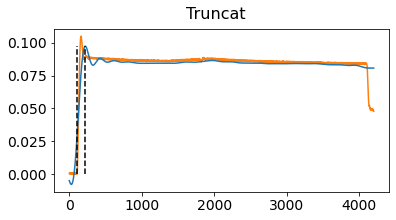


MLSi16CB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.105 (bar) in 0.118 (sec)

(4200,)
0.10221551653551775
0.08605132429351929


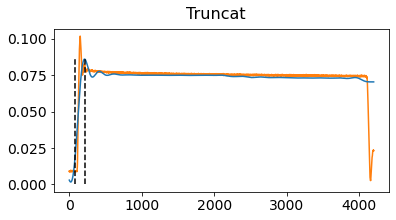


MLSi16CB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.102 (bar) in 0.126 (sec)

(4200,)
0.09833435822822327
0.08092364371988862


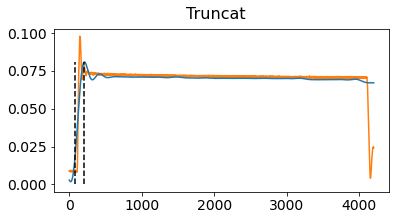


MLSi16CB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.098 (bar) in 0.125 (sec)

(4200,)
0.1034761710688592
0.07593493973336575


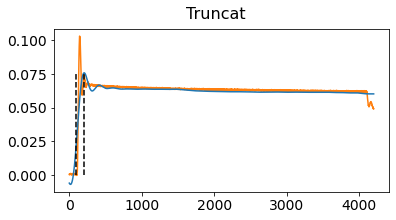


MLSi16CB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.103 (bar) in 0.114 (sec)

(4200,)
0.053309794270441406
0.04645680710690019


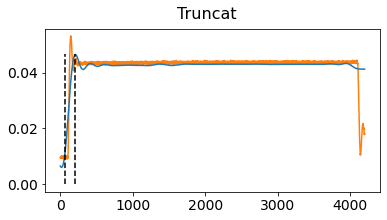


MLSi16CB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.053 (bar) in 0.142 (sec)

(4200,)
0.050374868773603025
0.04383113853108981


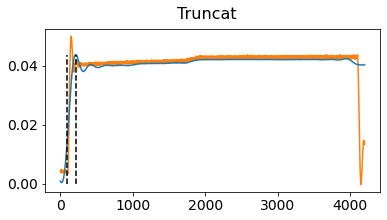


MLSi16CB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.032 (bar), Max. P. = 0.050 (bar) in 0.126 (sec)

(4200,)
0.139753774751091
0.1099131643992838


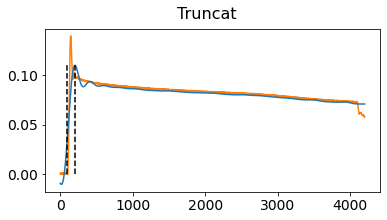


MLSi20SB7kV - Trial01 - Seg1
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.139 (bar) in 0.113 (sec)

(4200,)
0.10795072961321936
0.07611026507281507


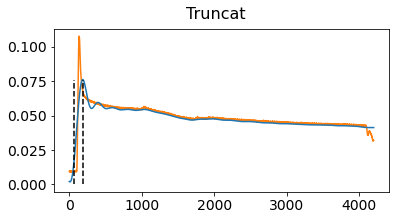


MLSi20SB7kV - Trial01 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.108 (bar) in 0.115 (sec)

(4200,)
0.10006011024467026
0.0677421850706301


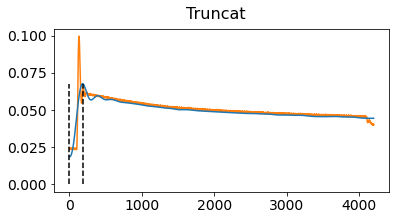


MLSi20SB7kV - Trial01 - Seg3
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.100 (bar) in 0.184 (sec)

(4200,)
0.07520778682690664
0.05113427355404691


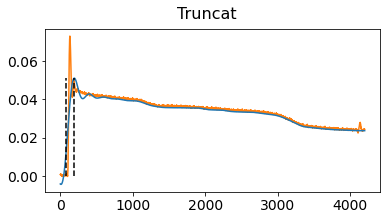


MLSi20SB7kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.073 (bar) in 0.112 (sec)

(4200,)
0.08840693264055684
0.0505988357545469


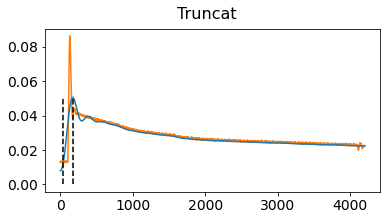


MLSi20SB7kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.036 (bar), Max. P. = 0.086 (bar) in 0.130 (sec)

(4200,)
0.0767474198744284
0.045912331595325824


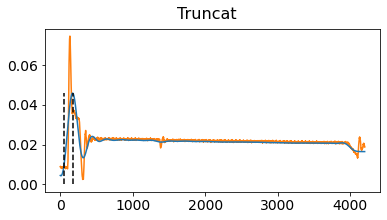


MLSi20SB7kV - Trial02 - Seg3
Avg. Pressure of zipping = 0.033 (bar), Max. P. = 0.075 (bar) in 0.112 (sec)

(4200,)
0.21899676316572728
0.11938676407888367


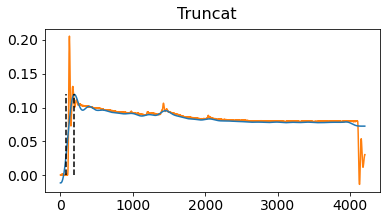


MLSi20B7kV - Trial03 - Seg1
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.205 (bar) in 0.114 (sec)

(4200,)
0.24465731395775683
0.1558532339746235


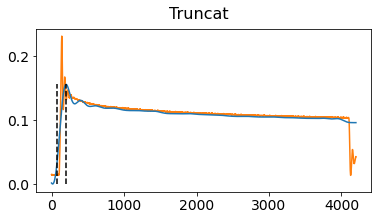


MLSi20B7kV - Trial03 - Seg2
Avg. Pressure of zipping = 0.115 (bar), Max. P. = 0.231 (bar) in 0.120 (sec)

(4200,)
0.15776427383824673
0.09808056692805531


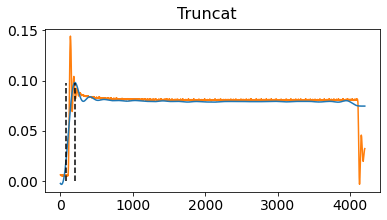


MLSi20B7kV - Trial03 - Seg3
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.144 (bar) in 0.117 (sec)

(4200,)
0.23955727948784095
0.14986875785983333


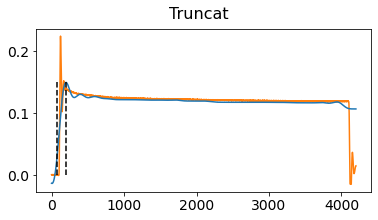


MLSi20B7kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.113 (bar), Max. P. = 0.224 (bar) in 0.118 (sec)

(4200,)
0.25787249761565206
0.14761076812844434


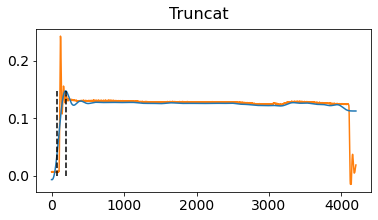


MLSi20B7kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.243 (bar) in 0.118 (sec)

(4200,)
0.27081503792138195
0.1527364436825859


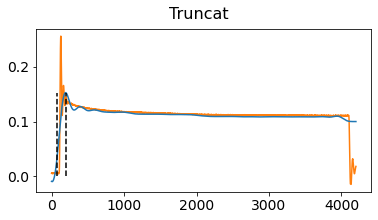


MLSi20B7kV - Trial04 - Seg3
Avg. Pressure of zipping = 0.114 (bar), Max. P. = 0.256 (bar) in 0.115 (sec)

(3500,)
0.09182299346474578
0.08463962135002308


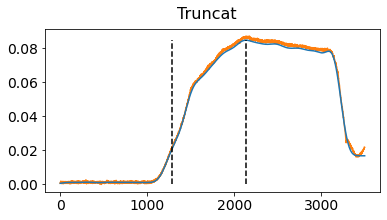


Tube6mmPressBalloon - Trial02
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.087 (bar) in 0.845 (sec)

(3500,)
0.08835881910782178
0.08283405774493774


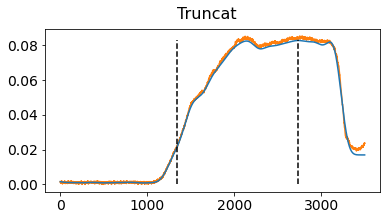


Tube6mmPressBalloon - Trial01
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.085 (bar) in 1.400 (sec)

(3500,)
0.10098060252865132
0.09501773883594844


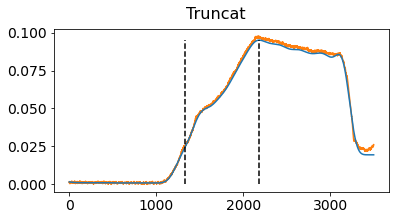


Tube6mmPressBalloon - Trial03
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.098 (bar) in 0.859 (sec)

(3500,)
0.10292118168229857
0.09872717602633486


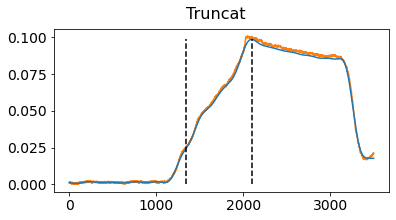


Tube6mmPressBalloon - Trial04
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.101 (bar) in 0.751 (sec)

(3500,)
0.0921116746611561
0.08537040221723312


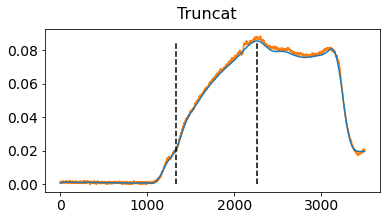


Tube6mmPressBalloon - Trial05
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.088 (bar) in 0.927 (sec)

(3500,)
0.08641190479215954
0.08404142829473685


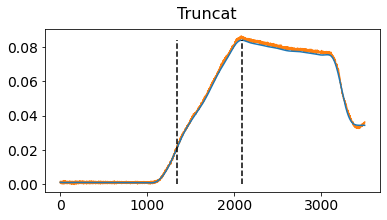


MedTubePressBalloon - Trial01
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.086 (bar) in 0.746 (sec)

(3500,)
0.06191241394778632
0.05888003640058733


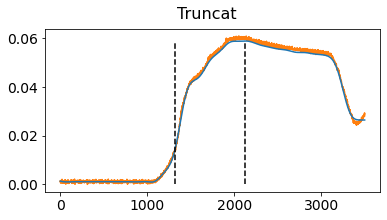


MedTubePressBalloon - Trial02
Avg. Pressure of zipping = 0.049 (bar), Max. P. = 0.061 (bar) in 0.807 (sec)

(3500,)
0.08181537865585424
0.07783402596561757


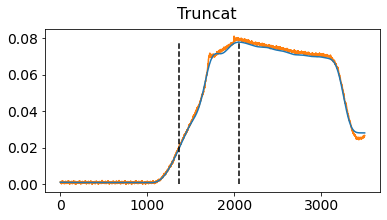


MedTubePressBalloon - Trial03
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.081 (bar) in 0.693 (sec)

(3500,)
0.08527955301277823
0.08013968803675267


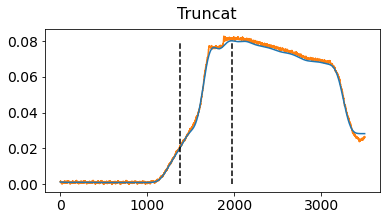


MedTubePressBalloon - Trial04
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.083 (bar) in 0.596 (sec)

(3500,)
0.07723825788400898
0.07538496573087282


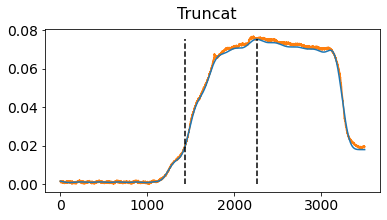


MedTubePressBalloon - Trial05
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.077 (bar) in 0.831 (sec)

(3500,)
0.1490460217309717
0.14345001928360257


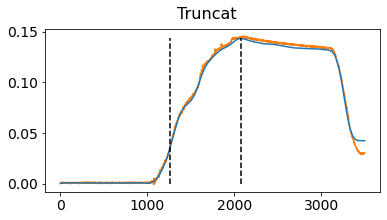


FR3Tube8mm - Trial01
Avg. Pressure of zipping = 0.107 (bar), Max. P. = 0.146 (bar) in 0.814 (sec)

(3500,)
0.15158000112168463
0.14778301209780095


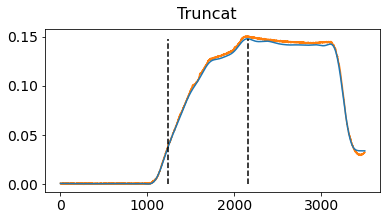


FR3Tube8mm - Trial02
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.150 (bar) in 0.917 (sec)

(3500,)
0.14777903203561524
0.14396476184788057


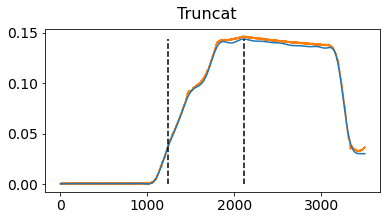


FR3Tube8mm - Trial05
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.147 (bar) in 0.875 (sec)

(3500,)
0.13541385412270598
0.12473560001143548


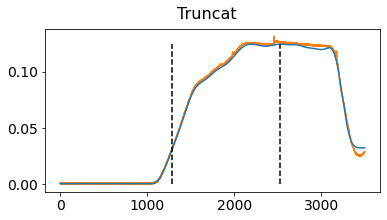


FR3Tube8mm - Trial06
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.132 (bar) in 1.244 (sec)

(3500,)
0.14069030487931708
0.13486288143064154


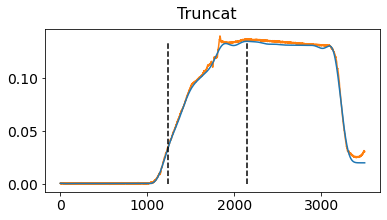


FR3Tube8mm - Trial07
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.140 (bar) in 0.907 (sec)

(3500,)
0.17121032247758722
0.15606324769230512


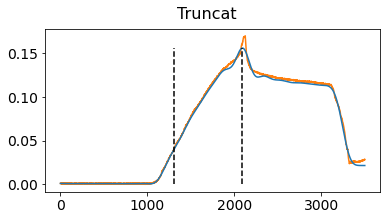


FR3Tube8mm - Trial08
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.170 (bar) in 0.792 (sec)

(3500,)
0.1612027076686957
0.15709419574752057


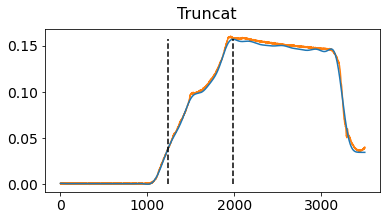


FR3Tube8mm - Trial09
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.160 (bar) in 0.744 (sec)

(3500,)
0.14266295972145435
0.13689973759985244


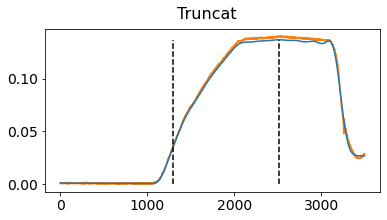


FR3Tube8mm - Trial10
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.140 (bar) in 1.220 (sec)

(3500,)
0.10550327460574653
0.10143006163666704


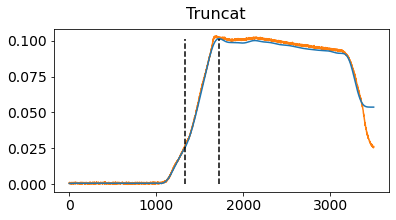


FR3MedTube - Trial01
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.103 (bar) in 0.392 (sec)

(3500,)
0.10747592944788381
0.1048267423158691


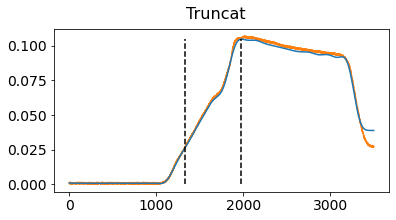


FR3MedTube - Trial02
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.107 (bar) in 0.649 (sec)

(3500,)
0.09118147969494504
0.08818226327996807


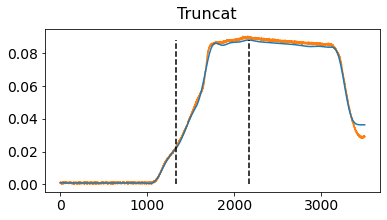


FR3MedTube - Trial03
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.091 (bar) in 0.836 (sec)

(3500,)
0.15549323511746913
0.1494508629472131


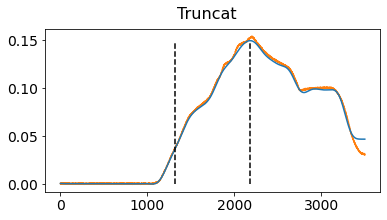


FR3MedTube - Trial04
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.154 (bar) in 0.861 (sec)

(3500,)
0.1151099433085126
0.11300713036262484


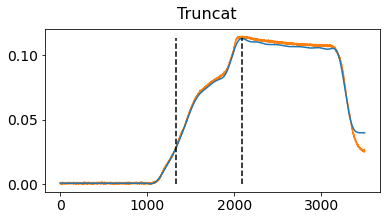


FR3MedTube - Trial05
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.115 (bar) in 0.757 (sec)

(3500,)
0.15533285667501895
0.15178539272630628


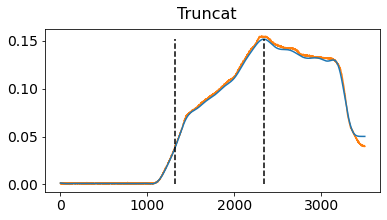


FR3MedTube - Trial06
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.155 (bar) in 1.022 (sec)

(3500,)
0.084205017448362
0.08122096837419933


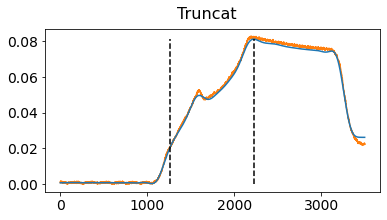


FR3MedTube - Trial07
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.083 (bar) in 0.963 (sec)

(3500,)
0.11810902018233106
0.11046397536642158


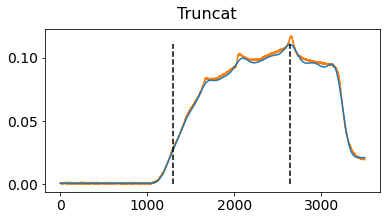


FR3MedTube - Trial08
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.117 (bar) in 1.339 (sec)

(3500,)
0.11820524724780117
0.11357842934072096


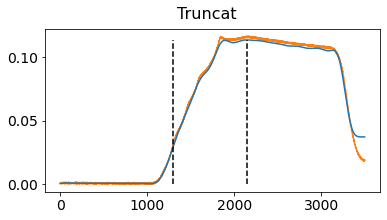


FR3MedTube - Trial09
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.117 (bar) in 0.850 (sec)

(3500,)
0.10553535029423657
0.10153575206319437


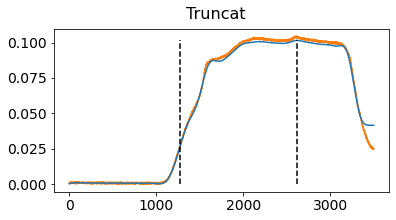


FR3MedTube - Trial10
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.105 (bar) in 1.351 (sec)

(3500,)
0.13007325198911485
0.12637062638064842


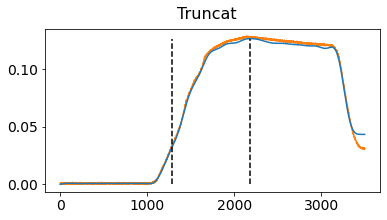


FR3MedTube - Trial11
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.129 (bar) in 0.904 (sec)

(3500,)
0.1372582062108831
0.1324129824839162


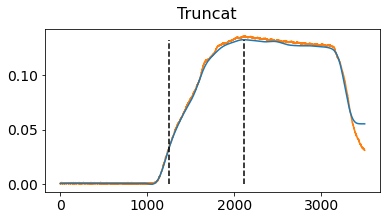


FR3MedTube - Trial12
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.136 (bar) in 0.859 (sec)

(3500,)
0.12854965678583807
0.12402659284629593


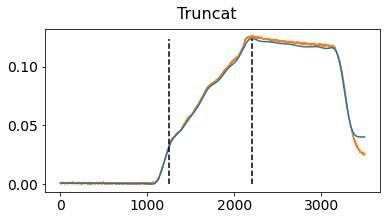


FR3MedTube - Trial13
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.126 (bar) in 0.959 (sec)

(3500,)
0.14460353887510158
0.1363764168323713


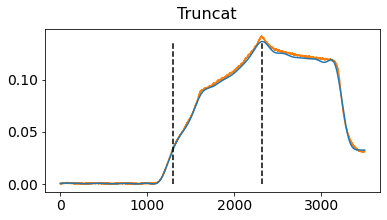


FR3MedTube - Trial14
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.142 (bar) in 1.022 (sec)

(3500,)
0.13461196191045507
0.12988041083814234


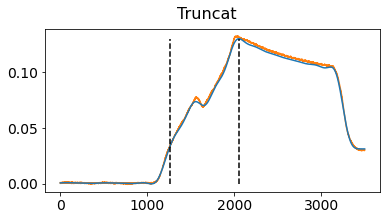


FR3MedTube - Trial15
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.132 (bar) in 0.797 (sec)

(3500,)
0.08253708164688008
0.07906516452761907


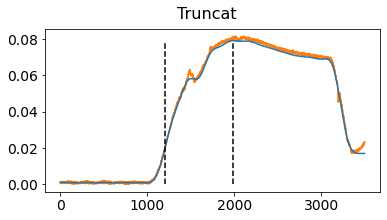


PressBalloon2 - Trial01
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.082 (bar) in 0.782 (sec)

(3500,)
0.09037958748269412
0.07553493129376099


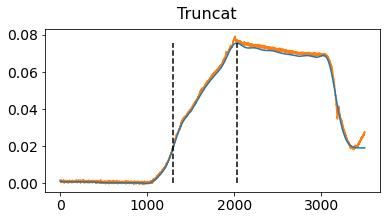


PressBalloon2 - Trial02
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.079 (bar) in 0.733 (sec)

(3500,)
0.08380407134223654
0.0757516674434008


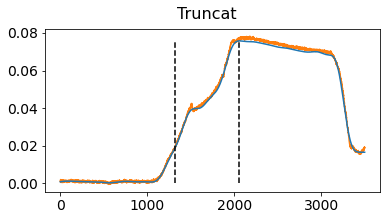


PressBalloon2 - Trial03
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.078 (bar) in 0.737 (sec)

(3500,)
0.07746912286545424
0.06452860176744966


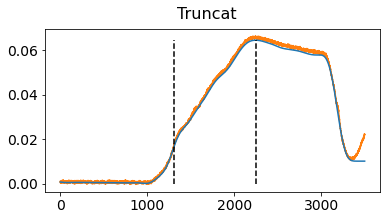


PressBalloon2 - Trial04
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.066 (bar) in 0.943 (sec)

(3500,)
0.0796021561500417
0.06676967512381266


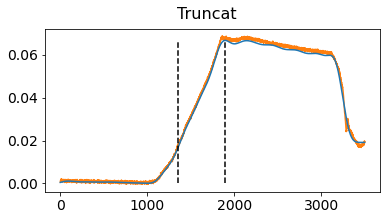


PressBalloon2 - Trial05
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.069 (bar) in 0.542 (sec)

(3500,)
0.10359477114058933
0.09849337484144802


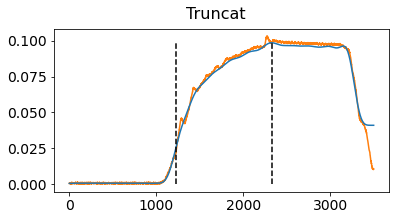


SiMedTube - Trial01
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.103 (bar) in 1.104 (sec)

(3500,)
0.10041927798007567
0.09741131041440193


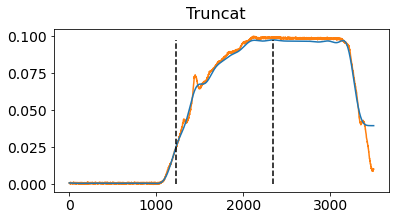


SiMedTube - Trial02
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.100 (bar) in 1.123 (sec)

(3500,)
0.10159004060996203
0.08093185638348757


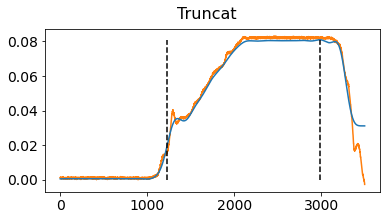


SiMedTube - Trial03
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.083 (bar) in 1.752 (sec)

(3500,)
0.11440427816173179
0.11120467714502709


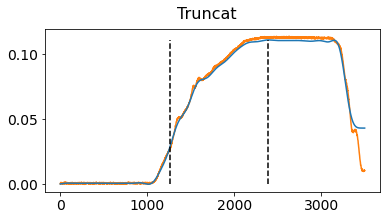


SiMedTube - Trial04
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.114 (bar) in 1.136 (sec)

(3500,)
0.08382010918648156
0.08029678058348522


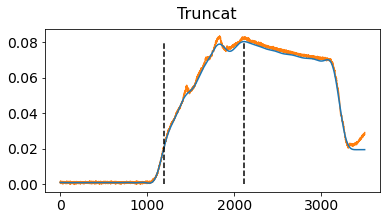


Tube8mmPressBalloon - Trial01
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.083 (bar) in 0.922 (sec)

(3500,)
0.08803806222292142
0.07498496477384538


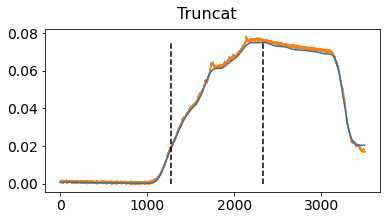


Tube8mmPressBalloon - Trial02
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.078 (bar) in 1.057 (sec)

(3500,)
0.09344281573349264
0.07745407445186003


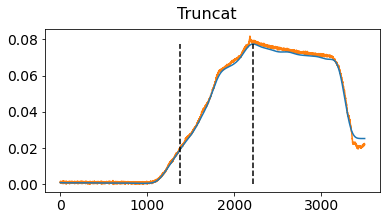


Tube8mmPressBalloon - Trial03
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.082 (bar) in 0.836 (sec)

(3500,)
0.08465407708722252
0.07758383079377158


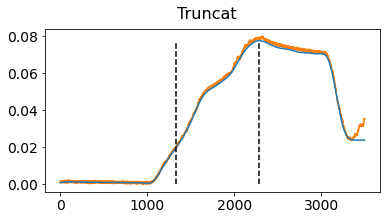


Tube8mmPressBalloon - Trial04
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.080 (bar) in 0.958 (sec)

(3500,)
0.08625786151172436
0.07549617084491277


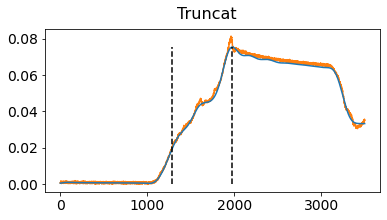


Tube8mmPressBalloon - Trial05
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.081 (bar) in 0.697 (sec)

(3500,)
0.09326006428478242
0.09125704894335461


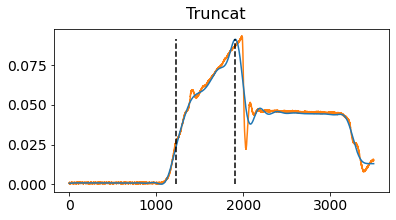


SiMedTube - Trial05
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.093 (bar) in 0.685 (sec)

(3500,)
0.09780510936813766
0.08775444672382506


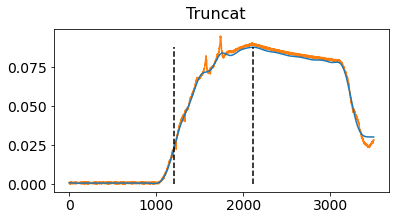


Pressure - Trial01
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.095 (bar) in 0.914 (sec)

(3500,)
0.08821447850961661
0.07166352997707635


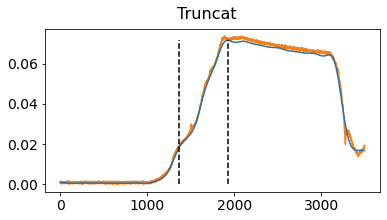


Pressure - Trial02
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.074 (bar) in 0.561 (sec)

(3500,)
0.09121355538343508
0.07406376718844093


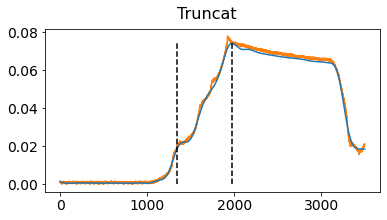


Pressure - Trial03
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.078 (bar) in 0.634 (sec)

(3500,)
0.08240877889291993
0.0675432767786049


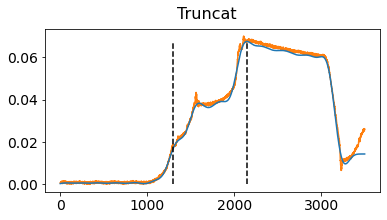


Pressure - Trial04
Avg. Pressure of zipping = 0.039 (bar), Max. P. = 0.070 (bar) in 0.848 (sec)

(3500,)
0.09802963918756792
0.0796075624800855


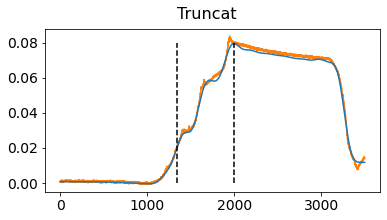


Pressure - Trial05
Avg. Pressure of zipping = 0.051 (bar), Max. P. = 0.084 (bar) in 0.657 (sec)

(1700,)
0.06603413991875606
0.06334361042850842


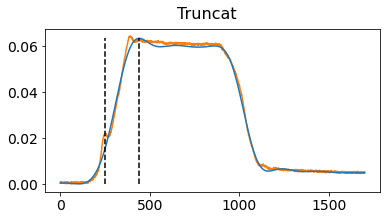


L0WsSi5-20Trek8kV - Trial02 - Seg1
Avg. Pressure of zipping = 0.046 (bar), Max. P. = 0.064 (bar) in 0.189 (sec)

(1700,)
0.06596998854177599
0.06179775461829704


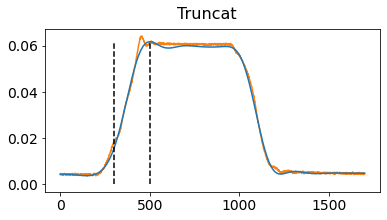


L0WsSi5-20Trek8kV - Trial02 - Seg2
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.064 (bar) in 0.200 (sec)

(1700,)
0.06670772937704685
0.06063478227548933


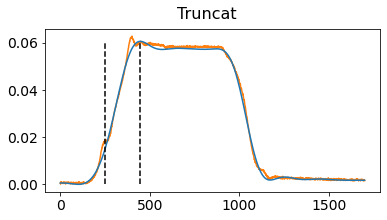


L0WsSi5-20Trek8kV - Trial03 - Seg1
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.063 (bar) in 0.196 (sec)

(1700,)
0.06579357225508078
0.05939205113318533


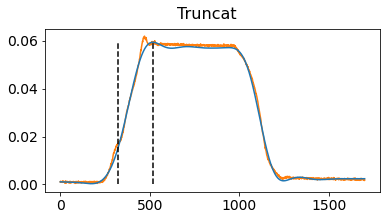


L0WsSi5-20Trek8kV - Trial03 - Seg2
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.062 (bar) in 0.196 (sec)

(1700,)
0.06707659979468227
0.060690842230282316


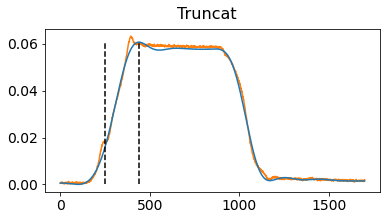


L0WsSi5-20Trek8kV - Trial04 - Seg1
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.063 (bar) in 0.192 (sec)

(1700,)
0.06673980506553688
0.060102214024893685


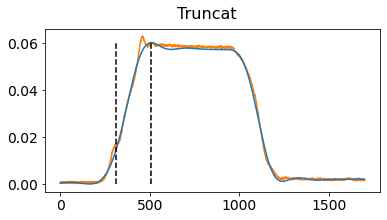


L0WsSi5-20Trek8kV - Trial04 - Seg2
Avg. Pressure of zipping = 0.043 (bar), Max. P. = 0.063 (bar) in 0.195 (sec)

(1700,)
0.06776622709721807
0.06161554812228058


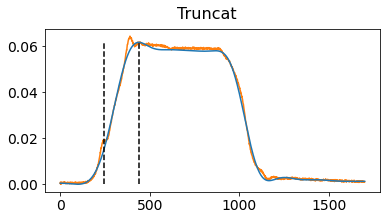


L0WsSi5-20Trek8kV - Trial05 - Seg1
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.064 (bar) in 0.193 (sec)

(1700,)
0.0671888647043974
0.06090293507697335


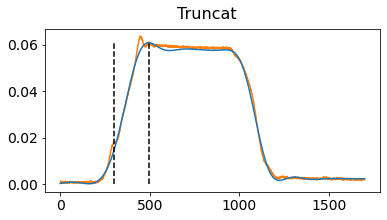


L0WsSi5-20Trek8kV - Trial05 - Seg2
Avg. Pressure of zipping = 0.044 (bar), Max. P. = 0.064 (bar) in 0.192 (sec)

(1700,)
0.08487860690665278
0.08123247138239291


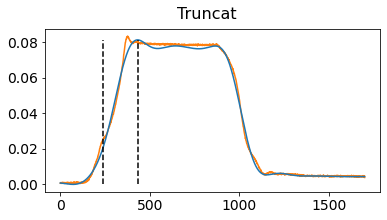


L0WsSi5-20Trek8kV - Trial06 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.083 (bar) in 0.192 (sec)

(1700,)
0.08242481673716495
0.0776574417140981


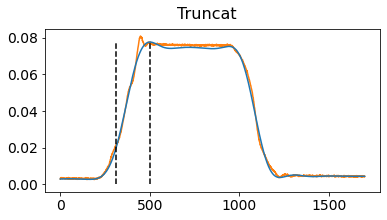


L0WsSi5-20Trek8kV - Trial06 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.081 (bar) in 0.191 (sec)

(1700,)
0.10181457042939228
0.09816919798153516


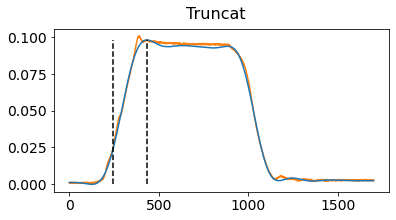


L0WsSi5-20Trek9kV - Trial07 - Seg1
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.101 (bar) in 0.187 (sec)

(1700,)
0.10343439269813916
0.09949106644876553


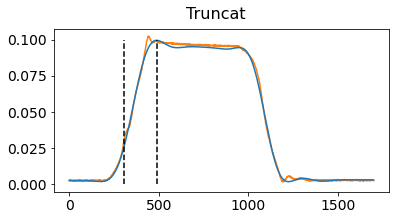


L0WsSi5-20Trek9kV - Trial07 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.102 (bar) in 0.184 (sec)

(1700,)
0.11963261538560781
0.09850643855584354


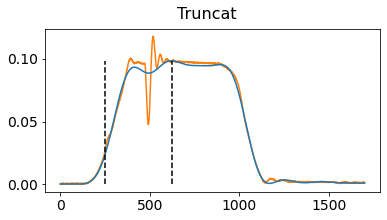


L0WsSi5-20Trek9kV - Trial08 - Seg1
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.118 (bar) in 0.369 (sec)

(1700,)
0.10327401425568897
0.09913766086928082


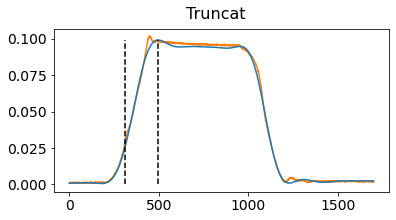


L0WsSi5-20Trek9kV - Trial08 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.102 (bar) in 0.186 (sec)

(1700,)
0.10290514383805355
0.09883477182786225


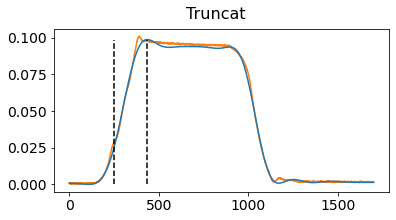


L0WsSi5-20Trek9kV - Trial09 - Seg1
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.101 (bar) in 0.186 (sec)

(1700,)
0.10362684682907937
0.09947580364770035


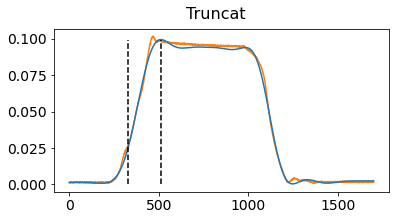


L0WsSi5-20Trek9kV - Trial09 - Seg2
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.102 (bar) in 0.184 (sec)

(1700,)
0.10318748987244887
0.10235763229194193


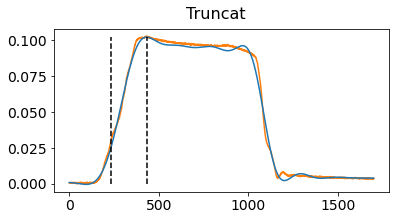


L0WsSi5-20Trek9kV - Trial10 - Seg1
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.103 (bar) in 0.197 (sec)

(1700,)
0.10320352771669389
0.10044414916093157


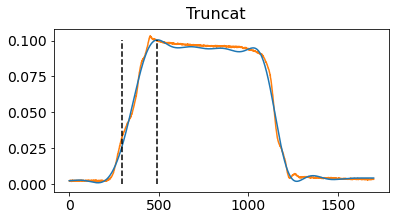


L0WsSi5-20Trek9kV - Trial10 - Seg2
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.103 (bar) in 0.200 (sec)

(1700,)
0.10943254644577606
0.10258322919988695


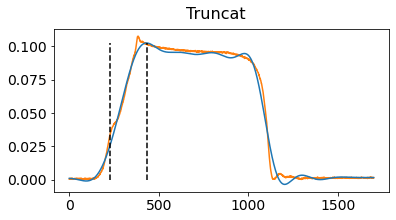


L0WsSi5-20Trek9kV - Trial11 - Seg1
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.108 (bar) in 0.203 (sec)

(1700,)
0.106770264301103
0.10060385293205044


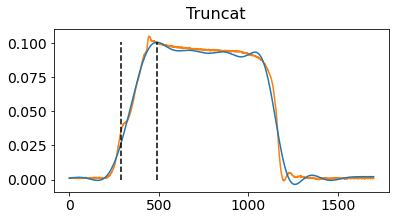


L0WsSi5-20Trek9kV - Trial11 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.105 (bar) in 0.203 (sec)

(1700,)
0.11032433056148208
0.10851312902125007


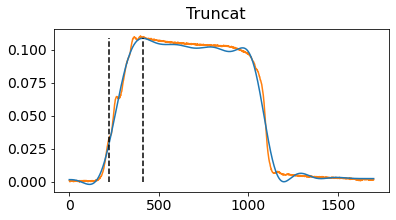


L0WsSi5-20Trek10kV - Trial13 - Seg1
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.110 (bar) in 0.191 (sec)

(1700,)
0.11013187643054187
0.1074074676313996


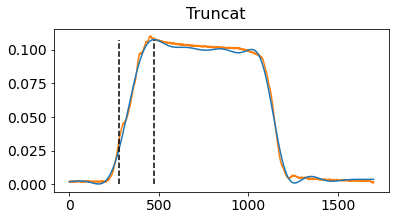


L0WsSi5-20Trek10kV - Trial13 - Seg2
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.110 (bar) in 0.195 (sec)

(1700,)
0.14909413526370674
0.12874279659645307


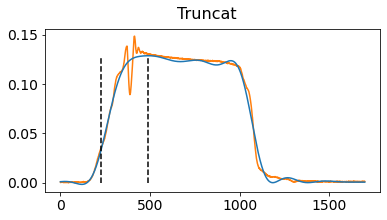


L0WsSi5-20Trek10kV - Trial14 - Seg1
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.149 (bar) in 0.265 (sec)

(1700,)
0.15831589570459237
0.12867816003565727


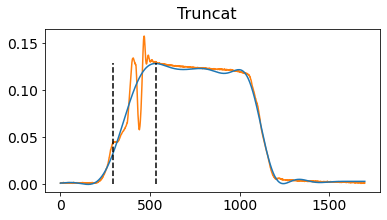


L0WsSi5-20Trek10kV - Trial14 - Seg2
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.158 (bar) in 0.238 (sec)

(1700,)
0.13614525979596184
0.12714789323633244


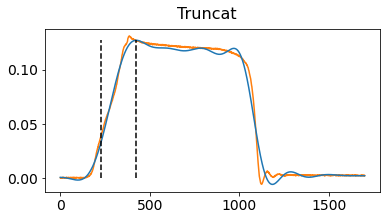


L0WsSi5-20Trek10kV - Trial15 - Seg1
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.131 (bar) in 0.199 (sec)

(1700,)
0.14353870599291535
0.12862551965057498


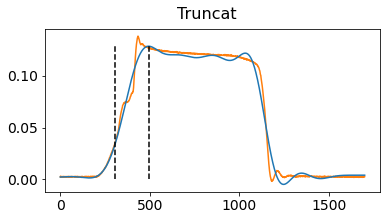


L0WsSi5-20Trek10kV - Trial15 - Seg2
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.138 (bar) in 0.190 (sec)

(1700,)
0.1343874320910248
0.13395844920985878


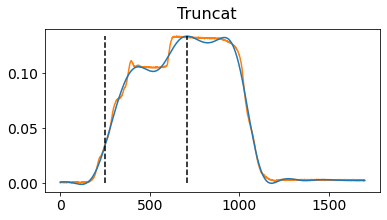


L0WsSi5-20Trek10kV - Trial16 - Seg1
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.134 (bar) in 0.459 (sec)

(1700,)
0.16967068943006544
0.1563384815986209


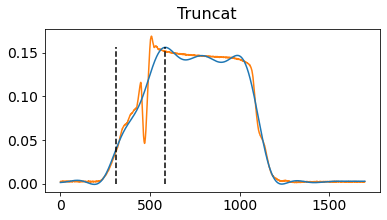


L0WsSi5-20Trek10kV - Trial16 - Seg2
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.169 (bar) in 0.275 (sec)

(1700,)
0.17601534058907778
0.1567058027202558


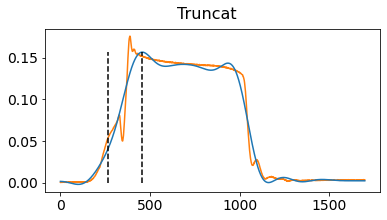


L0WsSi5-20Trek10kV - Trial17 - Seg1
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.176 (bar) in 0.194 (sec)

(1700,)
0.18140405625540398
0.1598872292296935


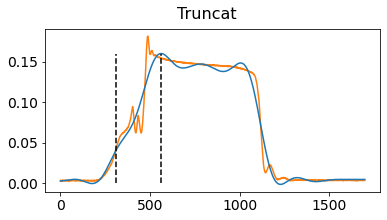


L0WsSi5-20Trek10kV - Trial17 - Seg2
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.181 (bar) in 0.253 (sec)

(1700,)
0.14299975445059973
0.13530045643960997


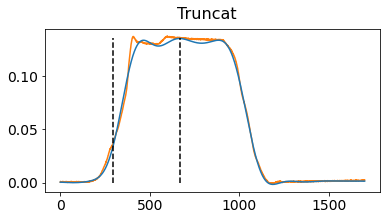


L0WsSi6-16Trek9kVHVTop - Trial04 - Seg1
Avg. Pressure of zipping = 0.117 (bar), Max. P. = 0.137 (bar) in 0.371 (sec)

(1700,)
0.13951954224943072
0.12932156231680472


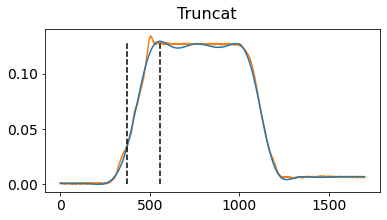


L0WsSi6-16Trek9kVHVTop - Trial04 - Seg2
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.134 (bar) in 0.185 (sec)

(1700,)
0.1664150070483267
0.15246306518733446


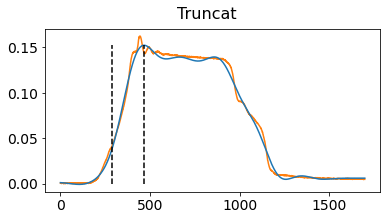


L0WsSi6-16Trek9kVHVTop - Trial07 - Seg1
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.162 (bar) in 0.179 (sec)

(1700,)
0.12418736315119305
0.11298590116780481


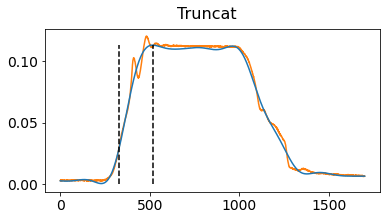


L0WsSi6-16Trek9kVHVTop - Trial07 - Seg2
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.120 (bar) in 0.189 (sec)

(1700,)
0.14944696783709716
0.12873803479758927


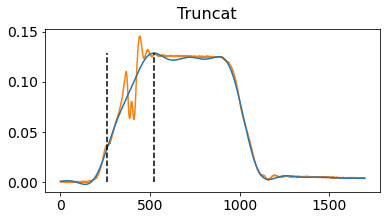


L0WsSi6-16Trek9kVHVTop - Trial08 - Seg1
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.146 (bar) in 0.264 (sec)

(1700,)
0.15788287390997688
0.13514730364877378


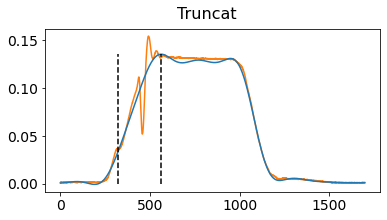


L0WsSi6-16Trek9kVHVTop - Trial08 - Seg2
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.154 (bar) in 0.241 (sec)

(1700,)
0.1443629712114263
0.13450993485527435


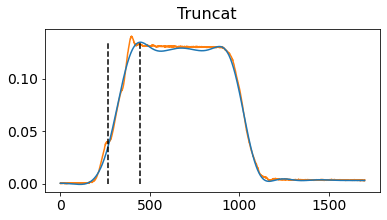


L0WsSi6-16Trek9kVHVTop - Trial09 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.140 (bar) in 0.183 (sec)

(1700,)
0.15271868806308092
0.13535019123600672


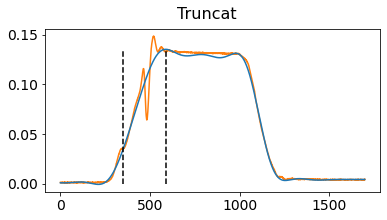


L0WsSi6-16Trek9kVHVTop - Trial09 - Seg2
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.149 (bar) in 0.239 (sec)

(1700,)
0.15182056878535988
0.14451798407403965


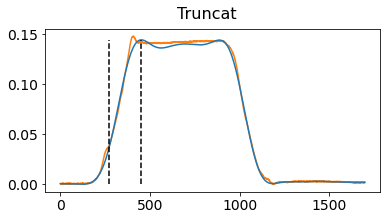


L0WsSi6-16Trek9kVHVTop - Trial10 - Seg1
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.148 (bar) in 0.180 (sec)

(1700,)
0.14757054006043
0.13264158220317093


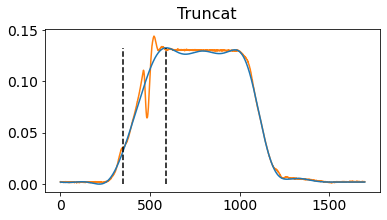


L0WsSi6-16Trek9kVHVTop - Trial10 - Seg2
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.144 (bar) in 0.239 (sec)

(1700,)
0.24875329940225155
0.21074444301941492


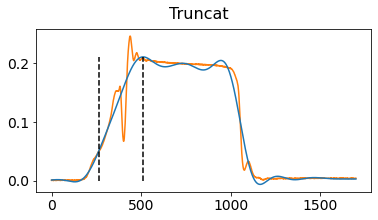


L0WsSi6-16Trek10kVHVTop - Trial16 - Seg1
Avg. Pressure of zipping = 0.147 (bar), Max. P. = 0.246 (bar) in 0.244 (sec)

(1700,)
0.20102467492907658
0.19855017523836668


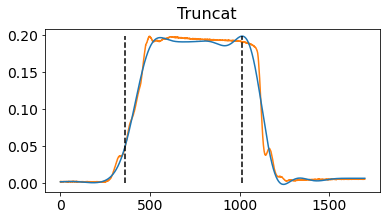


L0WsSi6-16Trek10kVHVTop - Trial16 - Seg2
Avg. Pressure of zipping = 0.179 (bar), Max. P. = 0.198 (bar) in 0.652 (sec)

(1700,)
0.15021678436085803
0.13773986225030244


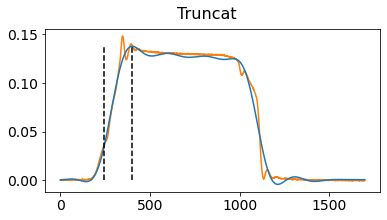


L0WsSi6-16Trek10kVHVTop - Trial17 - Seg1
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.148 (bar) in 0.157 (sec)

(1700,)
0.14139597002609788
0.13273809596623673


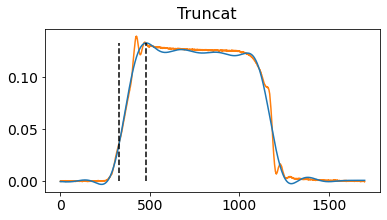


L0WsSi6-16Trek10kVHVTop - Trial17 - Seg2
Avg. Pressure of zipping = 0.098 (bar), Max. P. = 0.139 (bar) in 0.154 (sec)

(1700,)
0.18591702565026916
0.1732188033685126


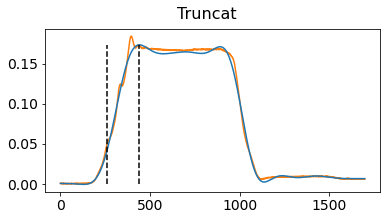


L0WsSi6-16Trek10kVHVTop - Trial18 - Seg1
Avg. Pressure of zipping = 0.127 (bar), Max. P. = 0.184 (bar) in 0.179 (sec)

(1700,)
0.17382449108952525
0.17359558646980852


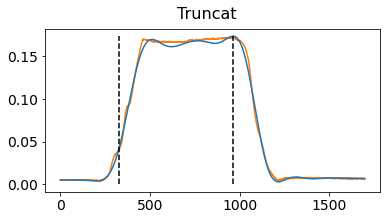


L0WsSi6-16Trek10kVHVTop - Trial18 - Seg2
Avg. Pressure of zipping = 0.156 (bar), Max. P. = 0.172 (bar) in 0.634 (sec)

(1700,)
0.24033343117361686
0.17837472358842002


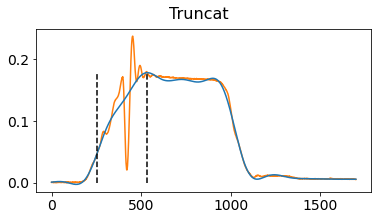


L0WsSi6-16Trek10kVHVTop - Trial19 - Seg1
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.238 (bar) in 0.284 (sec)

(1700,)
0.16194044850396655
0.15505516621479098


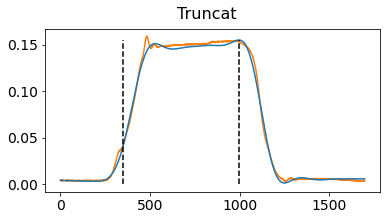


L0WsSi6-16Trek10kVHVTop - Trial19 - Seg2
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.159 (bar) in 0.649 (sec)

(1700,)
0.2389702144127903
0.1822545509119751


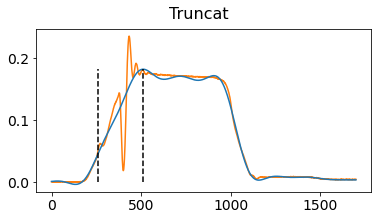


L0WsSi6-16Trek10kVHVTop - Trial20 - Seg1
Avg. Pressure of zipping = 0.125 (bar), Max. P. = 0.236 (bar) in 0.253 (sec)

(1700,)
0.1651319795087252
0.1566892567341846


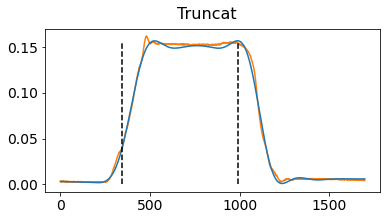


L0WsSi6-16Trek10kVHVTop - Trial20 - Seg2
Avg. Pressure of zipping = 0.142 (bar), Max. P. = 0.162 (bar) in 0.645 (sec)

(1700,)
0.09937681810414947
0.0962113680986371


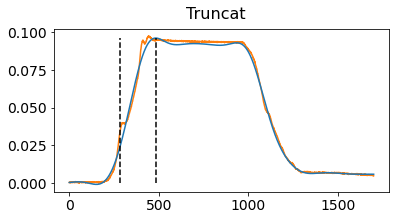


L0WsSi5-20sTrek9kVHVBot - Trial01 - Seg1
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.097 (bar) in 0.199 (sec)

(1700,)
0.10455704179529045
0.09826646989972469


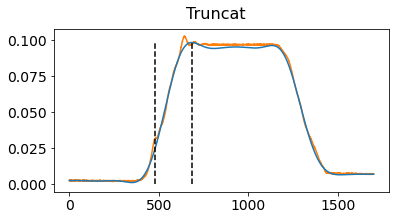


L0WsSi5-20sTrek9kVHVBot - Trial01 - Seg2
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.103 (bar) in 0.205 (sec)

(1700,)
0.08818240282112658
0.08553072123279264


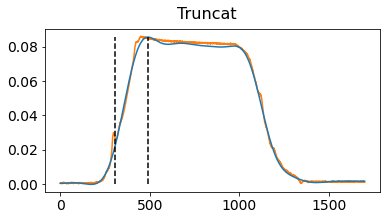


L0WsSi5-20sTrek9kVHVBot - Trial02 - Seg1
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.086 (bar) in 0.185 (sec)

(1700,)
0.08500690966061292
0.08116676299672584


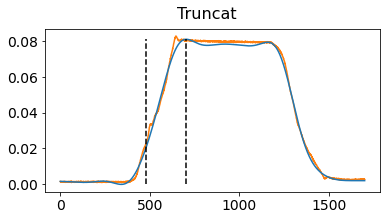


L0WsSi5-20sTrek9kVHVBot - Trial02 - Seg2
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.083 (bar) in 0.224 (sec)

(1700,)
0.08635408857719447
0.08313709435537697


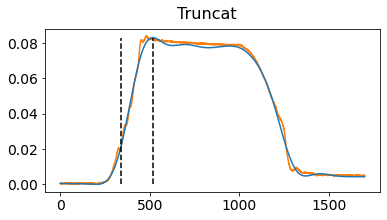


L0WsSi5-20sTrek9kVHVBot - Trial03 - Seg1
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.084 (bar) in 0.178 (sec)

(1700,)
0.09568811392779522
0.08432398020635112


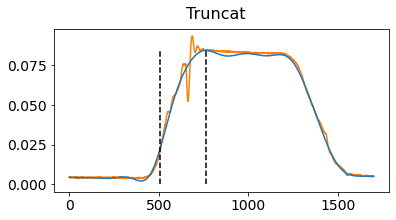


L0WsSi5-20sTrek9kVHVBot - Trial03 - Seg2
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.093 (bar) in 0.259 (sec)

(1700,)
0.08269746008933027
0.07623990844591616


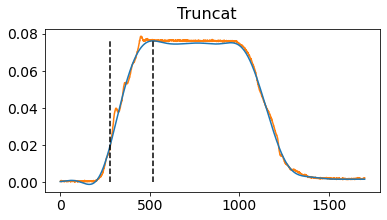


L0WsSi5-20sTrek9kVHVBot - Trial04 - Seg1
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.079 (bar) in 0.240 (sec)

(1700,)
0.08102952428784835
0.07520750726562403


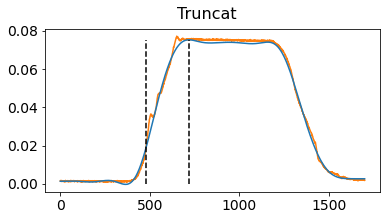


L0WsSi5-20sTrek9kVHVBot - Trial04 - Seg2
Avg. Pressure of zipping = 0.057 (bar), Max. P. = 0.077 (bar) in 0.239 (sec)

(1700,)
0.08024366991984244
0.07555353545784697


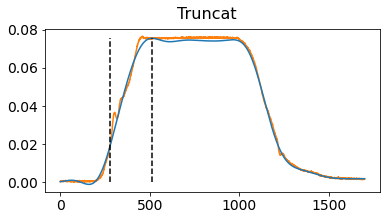


L0WsSi5-20sTrek9kVHVBot - Trial05 - Seg1
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.077 (bar) in 0.235 (sec)

(1700,)
0.08045216189502767
0.07597359583789547


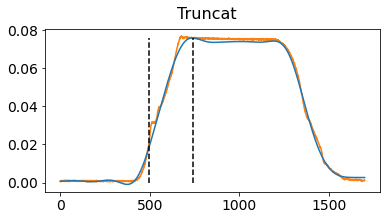


L0WsSi5-20sTrek9kVHVBot - Trial05 - Seg2
Avg. Pressure of zipping = 0.056 (bar), Max. P. = 0.077 (bar) in 0.241 (sec)



In [56]:
'''Measurement 2021'''
Fs = 1000

pressData = []
''' Process measurement data saved as individual csv files by trial '''
for root, directories, files in walk(".\data\ValidData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data, Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             (data[:segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa

''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data - calib[1]) * calib[0] # Unit conversion       
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa

''' Process data driven by reversed polarity from bipolar wearable controller '''                
for root, directories, files in walk(".\data\ValidData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):       
            condi, names, trialNum = decodeFileName(fileName)
            names = re.split('U6900V', names)[0] # Shorten the names

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')     
            
            data = (data[:,1] - calib[1]) * calib[0] # Unit conversion and only keep used channel (1)
            
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data
            
            inactivePressure = np.min(data[:int(0.5*Fs)])

            avgPressure, deltaT, maxPressure, segInd = processPressure(data[:int(3.5*Fs)], Fs, inactivePressure)
            P0 = data[segInd[0]]-inactivePressure
            
            print("\n%s - Trial%02d" % (names, trialNum))
            print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                  (avgPressure, maxPressure, deltaT)) 
            pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                             (data[:segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa

''' Process data switch two times with reversed polarity from bipolar HV Trek box (2022) '''
beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)
for root, directories, files in walk(".\data\TrekData2"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):
            condi, names, trialNum = decodeFileName(fileName)

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
            data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2) 
            dataMin = np.min(data) 
            if dataMin < 0:
                data = data-dataMin # Rectify data

            inactivePressure = np.min(data[:int(0.5*Fs)])

            for i in range(len(beginInd)): 
                avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
                P0 = data[beginInd[i]+segInd[0]]-inactivePressure # To remove DC pressure
                
                print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                      (avgPressure, maxPressure, deltaT))
                pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa
                                      
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex'])

for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
    allTrials = pressData[pressData['CondiName'] == aCondi]
    trialNum = allTrials.shape[0]
    if trialNum > 5:
        pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
        pressData = pressData.append(allTrials.iloc[:5])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")



In [57]:
print(sigData.head())
simData = pd.read_csv("./data./temp_result.csv") # Data from model simulation
simData.tail()

   CondiName                                       PressSig_kPa      SegIndex
0  6mLBOPP12  [0.08660435892309977, 0.09943463431911458, 0.0...  [1346, 1692]
1  6mLBOPP12  [0.11066112529062744, 0.09141571219660524, 0.1...  [1072, 1877]
2  6mLBOPP12  [0.05132110158405914, 0.06094380813107024, 0.0...  [1651, 2799]
3  6mLBOPP12  [0.12509518511114415, 0.06575516140457575, 0.0...  [1490, 2384]
4  6mLBOPP12  [0.08981192777210342, 0.08820814334760158, 0.1...  [1115, 1660]


CondiName      PFull_Pa    P1Expan_Pa    P2Expan_Pa  \
24        L0WsSi5-20Trek9kV  24613.793653  24527.192933  24361.871294   
25       L0WsSi5-20Trek10kV  30387.399571  30280.485103  30076.384313   
26   L0WsSi6-16Trek9kVHVTop  26660.655160  26752.465236  26823.201681   
27  L0WsSi6-16Trek10kVHVTop  32914.389087  33027.734859  33115.063804   
28  L0WsSi5-20sTrek9kVHVBot  23018.571641  23076.868762  23076.868762   

       P1Cell_Pa  EsFull_J  Es1Expan_J  Es2Expan_J  Es1Cell_J  dVFull_m3  \
24  26346.338099  0.295595    0.224426    0.153257   0.012050   0.000006   
25  32526.343333  0.364933    0.277070    0.189207   0.014876   0.000006   
26  28021.234350  0.319638    0.245677    0.173914   0.010129   0.000006   
27  34594.116481  0.394614    0.303305    0.214708   0.012505   0.000006   
28  24208.791110  0.276067    0.205426    0.136951   0.011963   0.000006   

    dV1Expan_m3  dV2Expan_m3    dV1Cell_m3    lossFactor  
24     0.000005     0.000003  2.286827e-07  1.098169e+08  
25     0.000005     0.000003  2.286827e-07  1.098169e+08  
26     0.000005     0.000003  1.807397e-07  1.098169e+08  
27     0.000005     0.000003  1.807397e-07  1.098169e+08  
28     0.000004     0.000003  2.470741e-07  1.098169e+08

6mLBOPP12 - For pressure increased from P0 = 1.113 kPa to P1 = 4.866 kPa
compressed-air steady state volume = 0.228741 mL
time avg. flow rate = -2.515 mL/s and pressure loss = -1.878 kPa
6mLBOPP12 - For pressure increased from P0 = 1.086 kPa to P1 = 5.050 kPa
compressed-air steady state volume = 0.214989 mL
time avg. flow rate = -0.957 mL/s and pressure loss = -0.715 kPa
6mLBOPP12 - For pressure increased from P0 = 1.217 kPa to P1 = 4.398 kPa
compressed-air steady state volume = 0.276805 mL
time avg. flow rate = -0.428 mL/s and pressure loss = -0.319 kPa
6mLBOPP12 - For pressure increased from P0 = 0.831 kPa to P1 = 3.124 kPa
compressed-air steady state volume = 0.265914 mL
time avg. flow rate = -0.909 mL/s and pressure loss = -0.679 kPa
6mLBOPP12 - For pressure increased from P0 = 0.999 kPa to P1 = 4.014 kPa
compressed-air steady state volume = 0.248901 mL
time avg. flow rate = -1.318 mL/s and pressure loss = -0.984 kPa
6mLBOPP16 - For pressure increased from P0 = 1.588 kPa to P1 = 4.

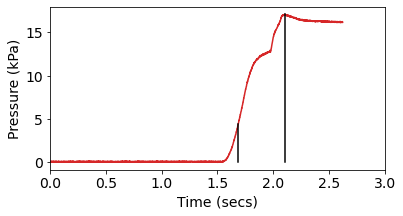

Mylar16NoShift - For pressure increased from P0 = 3.703 kPa to P1 = 14.530 kPa
compressed-air steady state volume = 0.254857 mL
time avg. flow rate = -0.248 mL/s and pressure loss = -0.185 kPa
Mylar16NoShift - For pressure increased from P0 = 4.324 kPa to P1 = 17.829 kPa
compressed-air steady state volume = 0.242511 mL
time avg. flow rate = -1.698 mL/s and pressure loss = -1.268 kPa


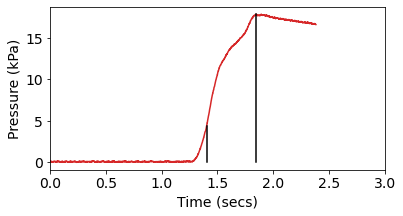

Mylar16NoShift - For pressure increased from P0 = 4.330 kPa to P1 = 16.471 kPa
compressed-air steady state volume = 0.262902 mL
time avg. flow rate = -0.404 mL/s and pressure loss = -0.302 kPa


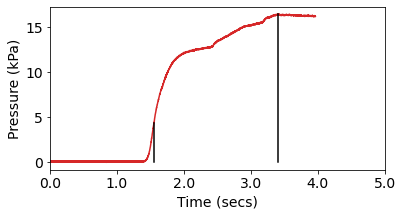

Mylar16NoShift - For pressure increased from P0 = 2.802 kPa to P1 = 10.753 kPa
compressed-air steady state volume = 0.260552 mL
time avg. flow rate = -0.794 mL/s and pressure loss = -0.593 kPa
BOPP16 - For pressure increased from P0 = 2.074 kPa to P1 = 7.903 kPa
compressed-air steady state volume = 0.262378 mL
time avg. flow rate = -0.674 mL/s and pressure loss = -0.503 kPa
BOPP16 - For pressure increased from P0 = 1.480 kPa to P1 = 5.650 kPa
compressed-air steady state volume = 0.261993 mL
time avg. flow rate = -0.893 mL/s and pressure loss = -0.667 kPa
BOPP16 - For pressure increased from P0 = 1.067 kPa to P1 = 4.160 kPa
compressed-air steady state volume = 0.256361 mL
time avg. flow rate = -0.188 mL/s and pressure loss = -0.141 kPa
BOPP16 - For pressure increased from P0 = 0.953 kPa to P1 = 3.737 kPa
compressed-air steady state volume = 0.254936 mL
time avg. flow rate = -0.618 mL/s and pressure loss = -0.461 kPa
BOPP16 - For pressure increased from P0 = 1.057 kPa to P1 = 3.907 kPa
c

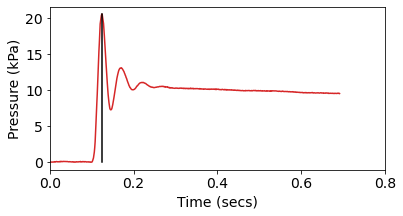

MLSi20B7kV - For pressure increased from P0 = 1.484 kPa to P1 = 23.112 kPa
compressed-air steady state volume = 0.064187 mL
time avg. flow rate = -15.222 mL/s and pressure loss = -1.672 kPa


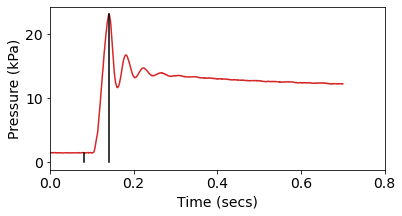

MLSi20B7kV - For pressure increased from P0 = 0.574 kPa to P1 = 14.423 kPa
compressed-air steady state volume = 0.039809 mL
time avg. flow rate = -14.564 mL/s and pressure loss = -1.599 kPa
MLSi20B7kV - For pressure increased from P0 = 0.130 kPa to P1 = 22.448 kPa
compressed-air steady state volume = 0.005787 mL
time avg. flow rate = -5.899 mL/s and pressure loss = -0.648 kPa


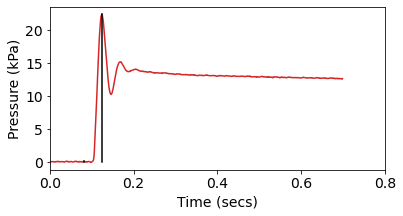

MLSi20B7kV - For pressure increased from P0 = 0.743 kPa to P1 = 24.280 kPa
compressed-air steady state volume = 0.030583 mL
time avg. flow rate = -12.973 mL/s and pressure loss = -1.425 kPa


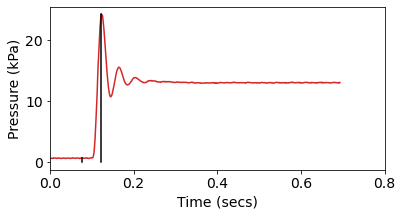

FR3Tube8mm - For pressure increased from P0 = 3.604 kPa to P1 = 14.577 kPa
compressed-air steady state volume = 0.247222 mL
time avg. flow rate = -0.897 mL/s and pressure loss = -0.132 kPa
FR3Tube8mm - For pressure increased from P0 = 3.777 kPa to P1 = 15.043 kPa
compressed-air steady state volume = 0.251066 mL
time avg. flow rate = -0.815 mL/s and pressure loss = -0.120 kPa


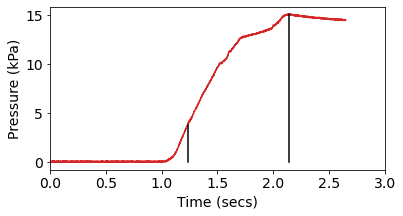

FR3Tube8mm - For pressure increased from P0 = 3.734 kPa to P1 = 14.681 kPa
compressed-air steady state volume = 0.254315 mL
time avg. flow rate = -0.851 mL/s and pressure loss = -0.126 kPa
FR3Tube8mm - For pressure increased from P0 = 3.167 kPa to P1 = 13.182 kPa
compressed-air steady state volume = 0.240297 mL
time avg. flow rate = -0.639 mL/s and pressure loss = -0.094 kPa
FR3Tube8mm - For pressure increased from P0 = 3.427 kPa to P1 = 13.974 kPa
compressed-air steady state volume = 0.245266 mL
time avg. flow rate = -1.235 mL/s and pressure loss = -0.182 kPa
FR3MedTube - For pressure increased from P0 = 2.661 kPa to P1 = 10.316 kPa
compressed-air steady state volume = 0.257929 mL
time avg. flow rate = -2.042 mL/s and pressure loss = -3.723 kPa
FR3MedTube - For pressure increased from P0 = 2.645 kPa to P1 = 10.700 kPa
compressed-air steady state volume = 0.247152 mL
time avg. flow rate = -1.081 mL/s and pressure loss = -1.971 kPa
FR3MedTube - For pressure increased from P0 = 2.314 kPa

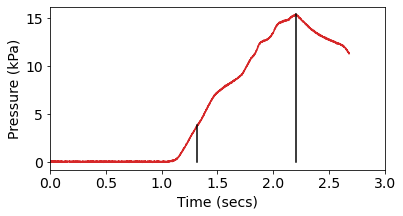

FR3MedTube - For pressure increased from P0 = 2.903 kPa to P1 = 11.481 kPa
compressed-air steady state volume = 0.252829 mL
time avg. flow rate = -0.993 mL/s and pressure loss = -1.810 kPa
L0WsSi5-20Trek8kV - For pressure increased from P0 = 2.164 kPa to P1 = 6.430 kPa
compressed-air steady state volume = 0.336493 mL
time avg. flow rate = -4.740 mL/s and pressure loss = -0.521 kPa
L0WsSi5-20Trek8kV - For pressure increased from P0 = 1.793 kPa to P1 = 6.423 kPa
compressed-air steady state volume = 0.279151 mL
time avg. flow rate = -4.510 mL/s and pressure loss = -0.495 kPa
L0WsSi5-20Trek8kV - For pressure increased from P0 = 1.825 kPa to P1 = 6.285 kPa
compressed-air steady state volume = 0.290380 mL
time avg. flow rate = -4.741 mL/s and pressure loss = -0.521 kPa
L0WsSi5-20Trek8kV - For pressure increased from P0 = 1.671 kPa to P1 = 6.194 kPa
compressed-air steady state volume = 0.269808 mL
time avg. flow rate = -4.850 mL/s and pressure loss = -0.533 kPa
L0WsSi5-20Trek8kV - For pressur

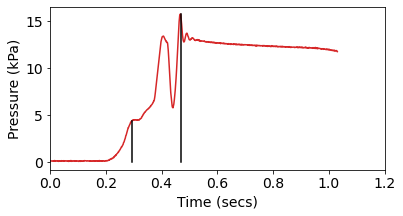

L0WsSi5-20Trek10kV - For pressure increased from P0 = 3.767 kPa to P1 = 13.095 kPa
compressed-air steady state volume = 0.287691 mL
time avg. flow rate = -4.415 mL/s and pressure loss = -0.485 kPa
L0WsSi6-16Trek9kVHVTop - For pressure increased from P0 = 3.681 kPa to P1 = 13.749 kPa
compressed-air steady state volume = 0.267701 mL
time avg. flow rate = -2.401 mL/s and pressure loss = -0.264 kPa
L0WsSi6-16Trek9kVHVTop - For pressure increased from P0 = 3.405 kPa to P1 = 13.401 kPa
compressed-air steady state volume = 0.254069 mL
time avg. flow rate = -5.480 mL/s and pressure loss = -0.602 kPa
L0WsSi6-16Trek9kVHVTop - For pressure increased from P0 = 4.160 kPa to P1 = 16.250 kPa
compressed-air steady state volume = 0.256021 mL
time avg. flow rate = -4.730 mL/s and pressure loss = -0.519 kPa


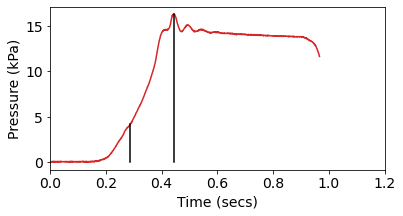

L0WsSi6-16Trek9kVHVTop - For pressure increased from P0 = 2.937 kPa to P1 = 12.027 kPa
compressed-air steady state volume = 0.244166 mL
time avg. flow rate = -4.971 mL/s and pressure loss = -0.546 kPa
L0WsSi6-16Trek9kVHVTop - For pressure increased from P0 = 3.661 kPa to P1 = 14.556 kPa
compressed-air steady state volume = 0.251543 mL
time avg. flow rate = -4.063 mL/s and pressure loss = -0.446 kPa
L0WsSi6-16Trek10kVHVTop - For pressure increased from P0 = 5.129 kPa to P1 = 24.610 kPa
compressed-air steady state volume = 0.208407 mL
time avg. flow rate = -4.662 mL/s and pressure loss = -0.512 kPa


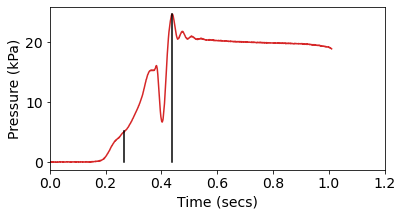

L0WsSi6-16Trek10kVHVTop - For pressure increased from P0 = 4.949 kPa to P1 = 19.837 kPa
compressed-air steady state volume = 0.249495 mL
time avg. flow rate = -5.642 mL/s and pressure loss = -0.620 kPa


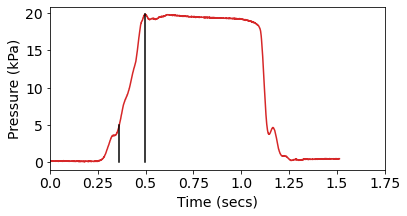

L0WsSi6-16Trek10kVHVTop - For pressure increased from P0 = 3.682 kPa to P1 = 14.813 kPa
compressed-air steady state volume = 0.248592 mL
time avg. flow rate = -7.452 mL/s and pressure loss = -0.818 kPa
L0WsSi6-16Trek10kVHVTop - For pressure increased from P0 = 3.541 kPa to P1 = 13.930 kPa
compressed-air steady state volume = 0.254202 mL
time avg. flow rate = -7.603 mL/s and pressure loss = -0.835 kPa
L0WsSi6-16Trek10kVHVTop - For pressure increased from P0 = 5.118 kPa to P1 = 18.410 kPa
compressed-air steady state volume = 0.277986 mL
time avg. flow rate = -5.477 mL/s and pressure loss = -0.601 kPa


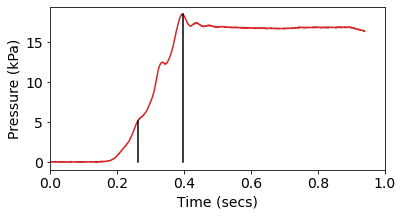

L0WsSi5-20sTrek9kVHVBot - For pressure increased from P0 = 3.445 kPa to P1 = 9.749 kPa
compressed-air steady state volume = 0.353348 mL
time avg. flow rate = -4.078 mL/s and pressure loss = -0.448 kPa
L0WsSi5-20sTrek9kVHVBot - For pressure increased from P0 = 3.161 kPa to P1 = 10.267 kPa
compressed-air steady state volume = 0.307873 mL
time avg. flow rate = -4.285 mL/s and pressure loss = -0.471 kPa
L0WsSi5-20sTrek9kVHVBot - For pressure increased from P0 = 2.707 kPa to P1 = 8.611 kPa
compressed-air steady state volume = 0.314397 mL
time avg. flow rate = -4.466 mL/s and pressure loss = -0.490 kPa
L0WsSi5-20sTrek9kVHVBot - For pressure increased from P0 = 2.232 kPa to P1 = 8.293 kPa
compressed-air steady state volume = 0.269194 mL
time avg. flow rate = -4.437 mL/s and pressure loss = -0.487 kPa
L0WsSi5-20sTrek9kVHVBot - For pressure increased from P0 = 2.037 kPa to P1 = 8.397 kPa
compressed-air steady state volume = 0.242552 mL
time avg. flow rate = -4.946 mL/s and pressure loss = -0.54

In [58]:
''' New estimation of air volume (2022.04.06) '''
airV0 = 1e-6 # Unit: m3, Initial air volume is roughly estimated to be 1? mL. (volume of inner tube is around 1.8 mL)
 
''' By law of P0V0 = P1V1, with P0 and P1 took from the measurement'''
avgPressLoss = []
for i in sigData.index:
#     airV0 = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0] # Incorrect Assume all oil pushed to tube
    
    i0 = sigData.loc[i,'SegIndex'][0] # Starting index at lowest pressure
    try:
        i1 = np.argwhere(sigData.loc[i,'PressSig_kPa'] == pressData.loc[i,'MaxPressure_kPa'])[0][0] # End index at max pressure
    except:
        i1 = sigData.loc[i,'SegIndex'][1]
    P0 = pressData.loc[i,'P0_kPa']
    P1 = pressData.loc[i,'MaxPressure_kPa']
    
    airV1 = airV0 * P0/P1
    print("%s - For pressure increased from P0 = %.3f kPa to P1 = %.3f kPa" % (sigData.loc[i,'CondiName'],
          pressData.loc[i,'P0_kPa'], pressData.loc[i,'MaxPressure_kPa']))
    print("compressed-air steady state volume = %.6f mL" % (airV1 * 1e6))
    
    filtPressure = lowpassFilter(sigData.loc[i,'PressSig_kPa'], 30, Fs, 6) # Smooth volume change before division
    airVi = airV1 * P1 / filtPressure[i0 : i1]  # Unit: m3
    
    Qi = np.diff(airVi) * Fs # Flow rate, Unit: m3/s
    
    PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi *1e-3 # Unit: kPa

    avgPLoss = np.mean(PiLoss) # Unit: kPa
    print("time avg. flow rate = %.3f mL/s and pressure loss = %.3f kPa" % (np.mean(Qi) * 1e6, avgPLoss))
    
    avgPressLoss.append(avgPLoss)
    
    if pressData.loc[i,'MaxPressure_kPa'] > 15: # Check signal 
        ax,_ = aPlot(dpi=72)
        ax.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
        
#         ax.plot(np.arange(i0+1,i1), PiLoss,color='tab:orange')
        
        ax.plot([i0, i0], [0, pressData.loc[i,'P0_kPa']], '-k')
        ax.plot([i1, i1], [0, pressData.loc[i,'MaxPressure_kPa']], '-k')
#         ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, pressData.loc[i,'MaxPressure_kPa']], '--k')
        ax.set_ylabel('Pressure (kPa)')
        
#         ax2 = ax.twinx() 
#         ax2.plot(np.arange(i0,i1), airVi,color='tab:blue')

        locs, _ = plt.xticks()
        plt.xticks(locs, locs/Fs)
        ax.set_xlim(0, locs[-1])
        ax.set_xlabel('Time (secs)')
        
        plt.show()
    
pressData['P1ExpanLoss_kPa'] = avgPressLoss
pressData.to_csv("Measurements.csv")     
    

In [ ]:
'''
Such estimation of pressure loss in tube is very inaccurate due to incorrect estimation of air volume
'''
''' Both Simulation and Measurement Data required '''
# print("Sampling frequency of current dataset = %.3f Hz" % Fs)

# sigData['V0'] = 0

# avgPressLoss = []
# for i in sigData.index:
#     deltaVolume = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0]

#     sigData.loc[i,'V0'] = deltaVolume / (1 - pressData.loc[i,'P0_kPa']/pressData.loc[i,'MaxPressure_kPa']) # Unit: m3
    
#     print("Initial Volume (mL) = %f" % (sigData.loc[i,'V0']*1e6))
#     print("Initial Pressure (kPa) = %f" % pressData.loc[i,'P0_kPa'])
#     print(sigData.loc[i,'SegIndex'])
    
#     print("%s inital air volume = %.6f mL" % (sigData.loc[i,'CondiName'], sigData.loc[i,'V0']*1e6)) 
    
#     ''' Realtime volume '''
# #     filteredPressure = lowpassFilter(sigData.loc[i,'PressSig_kPa'], 20, Fs, 8) # Smooth volume change before differentiation
    
    
#     Vi = sigData.loc[i,'V0'] * pressData.loc[i,'P0_kPa'] / (sigData.loc[i,'PressSig_kPa'] + 1e-3) # Unit: m3
    
#     zippingVi = Vi[sigData.loc[i,'SegIndex'][0]:sigData.loc[i,'SegIndex'][1]] # Unit: m3
    
# #     zippingVi = lowpassFilter(zippingVi, 20, Fs, 8) # Smooth volume change before differentiation
    
#     ''' Realtime volume flow rate '''
#     Qi = np.diff(zippingVi) * Fs # Unit: m3/s
#     avgQ = np.mean(Qi)
#     avgQRough = -deltaVolume * Fs/(sigData.loc[i,'SegIndex'][1] - sigData.loc[i,'SegIndex'][0])
    
#     print("Average flow rate estimated from realtime pressure = %.3f mL/s and from deltaV/zipTime = %.3f mL/s" %
#          (avgQ * 1e6, avgQRough * 1e6))
    
#     '''
#     Two methods: compute from realtime flow rate vs. volume change divided by rising time
#     '''
#     PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi *1e-3 # Unit: kPa 
    
#     avgPLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * avgQ *1e-3 # Unit: kPa  
#     if (avgPLoss > 0):
#         print("Incorrect Pressure loss")
#     else:
#         print("%s avg. pressure loss = %.2f kPa" % (sigData.loc[i,'CondiName'], avgPLoss))
        
#     avgPLossRough = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0]*avgQRough*1e-3 # Unit: kPa    
#     if (avgPLossRough > 0):
#         print("Incorrect Pressure loss (Rough)")
#     else:
#         print("%s avg. pressure loss = %.2f kPa (Rough)" % (sigData.loc[i,'CondiName'], avgPLossRough))    
        
        
#     avgPressLoss.append(avgPLoss)
    
#     segX = np.arange(sigData.loc[i,'SegIndex'][0], sigData.loc[i,'SegIndex'][1]) # For zipping process
#     ax,_=aPlot()
# #     ax.plot(segX, zippingVi,'tab:blue')
#     ax.plot(segX[1:], Qi * 1e6,'tab:blue')
#     ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 6e-6], '--k')
#     ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 6e-6], '--k')
# #     ax.set_ylabel('blue: Volume (m3)')
#     ax.set_ylabel('blue: Flow rate (mL/s)')
#     ax2 = ax.twinx() 
#     ax2.plot(segX[1:], PiLoss,color='tab:orange')
#     ax2.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
#     ax2.set_ylabel('orange: loss and\nred: measured\nPressure (kPa)')
#     plt.show();
    
# pressData['P1ExpanLoss_kPa'] = avgPressLoss
# pressData.to_csv("Measurements.csv") 